In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import io
import pandas as pd
from jax import grad
import jax.numpy as jnp
import seaborn as sns

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential      
from tensorflow.keras.layers import Dense           
from tensorflow.keras import optimizers            
from tensorflow.keras import regularizers           
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.random import set_seed

In [107]:
class neural_network:
    np.random.seed(1)
    def __init__(self, layers, activ_funcs, problem_type, lmbda=0):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.layers = layers
        self.n_layers = len(layers)
        self.activ_funcs = activ_funcs
        self.problem_type = problem_type
        self.lmbda = lmbda
        self.biases = [0.1*np.random.randn(y, 1) for y in layers[1:]]
        self.weights = [0.1*np.random.randn(y, x) for x, y in zip(layers[:-1], layers[1:])]


    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w, activ_func in zip(self.biases, self.weights, self.activ_funcs):
            #print(activ_func)
            if activ_func == 'identity':
                a = identity(np.dot(w, a) + b)

            elif activ_func == 'sigmoid':
                a = sigmoid(np.dot(w, a) + b)

            elif activ_func == 'relu':
                a = relu(np.dot(w, a) + b)

            elif activ_func == 'leaky_relu':
                a = leaky_relu(np.dot(w, a) + b)            

        return a

    def SGD(self, training_data, testing_data, n_epochs, mini_batch_size, eta):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs."""


        n_test = len(testing_data)
        n_train = len(training_data)
        
        test_results = []
        for i in range(n_epochs):
            np.random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n_train, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)

            if self.problem_type == 'regression':
                    print("Epoch {0}: {1}".format(i, self.evaluate_reg(testing_data)))
                    test_results.append(self.evaluate_reg(testing_data))
            
            elif self.problem_type == 'classification':
                    print("Epoch {0}: {1}".format(i, self.evaluate_class(testing_data) / len(testing_data)))
                    test_results.append(self.evaluate_class(testing_data) / len(testing_data))
                    
        return test_results
                    
    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]

        x = np.column_stack([i[0] for i in mini_batch])
        y = np.column_stack([i[1] for i in mini_batch])


        grad_b, grad_w = self.backprop(x, y)

        self.weights = [w * (1-self.lmbda) - (eta/len(mini_batch)) * nw  for  w, nw in zip(self.weights, grad_w)]

        self.biases = [b * (1-self.lmbda) - (eta/len(mini_batch)) * nb  for  b, nb in zip(self.biases, grad_b)]
        #print(len(self.weights))
        #print(len(self.biases))

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]

        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        #print(len(activations))
        zs = [] # list to store all the z vectors, layer by layer
        for b, w, activ_func in zip(self.biases, self.weights, self.activ_funcs):
            z = w @ activation + b
            zs.append(z)

            if activ_func == 'identity':
                activation = identity(z)
                activations.append(activation)

            elif activ_func == 'sigmoid':
                activation = sigmoid(z)
                activations.append(activation)

            elif activ_func == 'relu':
                activation = relu(z)
                activations.append(activation)

            elif activ_func == 'leaky_relu':
                activation = leaky_relu(z)
                activations.append(activation)
                
        #print(len(activations))

        if self.activ_funcs[-1] == 'identity':
            if self.problem_type == 'regression':
                cost_deriv = grad(self.reg_cost_func)
                deltas = cost_deriv(activations[-1], y) * d_identity(zs[-1])    
            elif self.problem_type == 'classification':
                cost_deriv = grad(self.class_cost_func)
                deltas = cost_deriv(activations[-1], y) * d_identity(zs[-1])   

        elif self.activ_funcs[-1] == 'sigmoid':
            if self.problem_type == 'regression':
                cost_deriv = grad(self.reg_cost_func)
                deltas = cost_deriv(activations[-1], y) * d_sigmoid(zs[-1])    
            elif self.problem_type == 'classification':
                cost_deriv = grad(self.class_cost_func)
                deltas = cost_deriv(activations[-1], y) * d_sigmoid(zs[-1])   

        elif self.activ_funcs[-1] == 'relu':
            if self.problem_type == 'regression':
                cost_deriv = grad(self.reg_cost_func)
                deltas = cost_deriv(activations[-1], y) * d_relu(zs[-1])    
            elif self.problem_type == 'classification':
                cost_deriv = grad(self.class_cost_func)
                deltas = cost_deriv(activations[-1], y) * d_relu(zs[-1])   

        elif self.activ_funcs[-1] == 'leaky_relu':
            if self.problem_type == 'regression':
                cost_deriv = grad(self.reg_cost_func)
                deltas = cost_deriv(activations[-1], y) * d_leaky_relu(zs[-1])    
            elif self.problem_type == 'classification':
                cost_deriv = grad(self.class_cost_func)
                deltas = cost_deriv(activations[-1], y) * d_leaky_relu(zs[-1])   

        grad_b[-1] = deltas.sum(axis=1).reshape((len(deltas), 1))
        grad_w[-1] = deltas @ activations[-2].transpose()

        for layer, activ_func in zip(range(2, self.n_layers), self.activ_funcs):
            #print(-layer, activ_func)
            z = zs[-layer]

            if activ_func == 'identity':
                sp = d_identity(z)

            elif activ_func == 'sigmoid':
                sp = d_sigmoid(z)

            elif activ_func == 'relu':
                sp = d_relu(z)

            elif activ_func == 'leaky_relu':
                sp = d_leaky_relu(z)

            deltas = (self.weights[-layer+1].transpose() @ deltas) * sp
            grad_b[-layer] = deltas.sum(axis=1).reshape((len(deltas), 1))
            grad_w[-layer] = deltas @ activations[-layer-1].transpose()

        return (grad_b, grad_w)

    def evaluate_reg(self, testing_data):
        """Computes the MSE"""

        sum_sq_errs = 0
        for (x, y) in testing_data:
            sum_sq_errs += (self.feedforward(x)-y)**2

        return (sum_sq_errs / len(testing_data))[0][0]


    def evaluate_class(self, testing_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in testing_data]
        #print(test_results)
        return sum(int(x == y) for (x, y) in test_results)


    def reg_cost_func(self, ypred, y):

        return jnp.sum((y-ypred)**2)/len(y)     

    def class_cost_func(self, ypred, y):

        return  -jnp.sum( jnp.multiply(jnp.log(ypred), y) + jnp.multiply(jnp.log(1-ypred), (1-y))) / len(y)

def identity(z):
    return z

def d_identity(z):
    return np.ones(z.shape)


def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def d_sigmoid(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

def relu(z):
    return np.maximum(z, 0)

def d_relu(z):
    return (z > 0)

def leaky_relu(z):
    if z.all() < 0:
        out = z*0.1
    else:
        out = z
    return out    

def d_leaky_relu(z):
    if z.all() < 0:
        out = 0.1
    else:
        out = 1
    return out


#####################################################################################################################

# Regression

#####################################################################################################################

### From Scratch

### ReLU hidden, 50 nodes test

In [122]:
npoints = 100
np.random.seed(1)
x = 3*np.random.rand(npoints,1)
y = 4 + 3*x + 2*x**2 + np.random.normal(0,0.1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

train = list(zip(X_train[:,0], y_train[:,0]))
test = list(zip(X_test[:,0], y_test[:,0]))

activ_funcs = ['relu', 'relu']
net_relu = neural_network([1, 50, 1], activ_funcs, 'regression', lmbda=0)

data_size = len(train)
n_epochs = 1000
eta = 0.01
test_mse_scratch_relu = net_relu.SGD(train, test, n_epochs, data_size, eta)

Epoch 0: 241.01339721679688
Epoch 1: 195.45416259765625
Epoch 2: 120.65340423583984
Epoch 3: 37.050048828125
Epoch 4: 3.622220993041992
Epoch 5: 3.5946948528289795
Epoch 6: 3.311697006225586
Epoch 7: 3.2478840351104736
Epoch 8: 3.158740997314453
Epoch 9: 3.0797336101531982
Epoch 10: 3.0048916339874268
Epoch 11: 2.9347589015960693
Epoch 12: 2.868978977203369
Epoch 13: 2.807276725769043
Epoch 14: 2.7493741512298584
Epoch 15: 2.6950438022613525
Epoch 16: 2.6440322399139404
Epoch 17: 2.595726490020752
Epoch 18: 2.5506114959716797
Epoch 19: 2.5081794261932373
Epoch 20: 2.468108654022217
Epoch 21: 2.430565357208252
Epoch 22: 2.395216703414917
Epoch 23: 2.3619461059570312
Epoch 24: 2.330571174621582
Epoch 25: 2.3010520935058594
Epoch 26: 2.2730298042297363
Epoch 27: 2.2468209266662598
Epoch 28: 2.221435070037842
Epoch 29: 2.198042154312134
Epoch 30: 2.1752076148986816
Epoch 31: 2.153923511505127
Epoch 32: 2.133992910385132
Epoch 33: 2.1148629188537598
Epoch 34: 2.0970466136932373
Epoch 35: 2.

Epoch 305: 0.6854658722877502
Epoch 306: 0.6823960542678833
Epoch 307: 0.6782023310661316
Epoch 308: 0.6745319962501526
Epoch 309: 0.6714791059494019
Epoch 310: 0.6673792004585266
Epoch 311: 0.6643233299255371
Epoch 312: 0.6602439880371094
Epoch 313: 0.6572154760360718
Epoch 314: 0.6531761288642883
Epoch 315: 0.6501978039741516
Epoch 316: 0.646192193031311
Epoch 317: 0.6432138681411743
Epoch 318: 0.6392476558685303
Epoch 319: 0.6364503502845764
Epoch 320: 0.6327559351921082
Epoch 321: 0.6290726065635681
Epoch 322: 0.62623530626297
Epoch 323: 0.6225872039794922
Epoch 324: 0.6195447444915771
Epoch 325: 0.6156468987464905
Epoch 326: 0.6129406690597534
Epoch 327: 0.610036313533783
Epoch 328: 0.607146143913269
Epoch 329: 0.6040018200874329
Epoch 330: 0.6008262634277344
Epoch 331: 0.5976805090904236
Epoch 332: 0.5945436358451843
Epoch 333: 0.5914380550384521
Epoch 334: 0.5883237719535828
Epoch 335: 0.5852316617965698
Epoch 336: 0.5821506977081299
Epoch 337: 0.5790864825248718
Epoch 338: 0.57

Epoch 592: 0.16366569697856903
Epoch 593: 0.16286331415176392
Epoch 594: 0.16206777095794678
Epoch 595: 0.16127684712409973
Epoch 596: 0.16049203276634216
Epoch 597: 0.1597127616405487
Epoch 598: 0.15893830358982086
Epoch 599: 0.1581709384918213
Epoch 600: 0.15740807354450226
Epoch 601: 0.15665146708488464
Epoch 602: 0.15589958429336548
Epoch 603: 0.15515370666980743
Epoch 604: 0.15441392362117767
Epoch 605: 0.15367832779884338
Epoch 606: 0.15294861793518066
Epoch 607: 0.15222494304180145
Epoch 608: 0.15150544047355652
Epoch 609: 0.15079258382320404
Epoch 610: 0.1500840038061142
Epoch 611: 0.14938144385814667
Epoch 612: 0.14868398010730743
Epoch 613: 0.1479911357164383
Epoch 614: 0.1473042219877243
Epoch 615: 0.14662203192710876
Epoch 616: 0.14594559371471405
Epoch 617: 0.14527392387390137
Epoch 618: 0.1446075588464737
Epoch 619: 0.14394573867321014
Epoch 620: 0.1432889997959137
Epoch 621: 0.14263874292373657
Epoch 622: 0.14199216663837433
Epoch 623: 0.14135047793388367
Epoch 624: 0.14

Epoch 876: 0.0796348974108696
Epoch 877: 0.07960325479507446
Epoch 878: 0.07957624644041061
Epoch 879: 0.07954738289117813
Epoch 880: 0.07951944321393967
Epoch 881: 0.07949191331863403
Epoch 882: 0.07946472615003586
Epoch 883: 0.07941080629825592
Epoch 884: 0.07938696444034576
Epoch 885: 0.07934997975826263
Epoch 886: 0.07932274788618088
Epoch 887: 0.07910530269145966
Epoch 888: 0.07908855378627777
Epoch 889: 0.07898962497711182
Epoch 890: 0.07893277704715729
Epoch 891: 0.07886223495006561
Epoch 892: 0.07880286872386932
Epoch 893: 0.07874220609664917
Epoch 894: 0.07868563383817673
Epoch 895: 0.07863102108240128
Epoch 896: 0.07857915014028549
Epoch 897: 0.0785292536020279
Epoch 898: 0.07848130166530609
Epoch 899: 0.0784357339143753
Epoch 900: 0.078391432762146
Epoch 901: 0.07834956049919128
Epoch 902: 0.07830881327390671
Epoch 903: 0.07826836407184601
Epoch 904: 0.07823517918586731
Epoch 905: 0.07820052653551102
Epoch 906: 0.07816798239946365
Epoch 907: 0.07813629508018494
Epoch 908: 0.

In [123]:
print(min(test_mse_scratch_relu))

0.077565774


### sigmoid hidden, 50 nodes test

In [124]:
npoints = 100
np.random.seed(1)
x = 3*np.random.rand(npoints,1)
y = 4 + 3*x + 2*x**2 + np.random.normal(0,0.1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

train = list(zip(X_train[:,0], y_train[:,0]))
test = list(zip(X_test[:,0], y_test[:,0]))

activ_funcs = ['sigmoid', 'relu']
net_relu = neural_network([1, 50, 1], activ_funcs, 'regression', lmbda=0)

data_size = len(train)
n_epochs = 1000
eta = 0.01
test_mse_scratch_sig = net_relu.SGD(train, test, n_epochs, data_size, eta)

Epoch 0: 161.87197875976562
Epoch 1: 106.1419906616211
Epoch 2: 73.36019134521484
Epoch 3: 54.29802322387695
Epoch 4: 43.405216217041016
Epoch 5: 37.203460693359375
Epoch 6: 33.60169219970703
Epoch 7: 31.413219451904297
Epoch 8: 29.993785858154297
Epoch 9: 29.00128173828125
Epoch 10: 28.254169464111328
Epoch 11: 27.65445899963379
Epoch 12: 27.14778709411621
Epoch 13: 26.70298194885254
Epoch 14: 26.301528930664062
Epoch 15: 25.93210220336914
Epoch 16: 25.58751106262207
Epoch 17: 25.263057708740234
Epoch 18: 24.95553970336914
Epoch 19: 24.662689208984375
Epoch 20: 24.3828067779541
Epoch 21: 24.114606857299805
Epoch 22: 23.857023239135742
Epoch 23: 23.609169006347656
Epoch 24: 23.370281219482422
Epoch 25: 23.13970375061035
Epoch 26: 22.91680145263672
Epoch 27: 22.701053619384766
Epoch 28: 22.491966247558594
Epoch 29: 22.289073944091797
Epoch 30: 22.09194564819336
Epoch 31: 21.900211334228516
Epoch 32: 21.713497161865234
Epoch 33: 21.53146743774414
Epoch 34: 21.35382843017578
Epoch 35: 21.

Epoch 304: 2.6524722576141357
Epoch 305: 2.6426784992218018
Epoch 306: 2.632965087890625
Epoch 307: 2.6233315467834473
Epoch 308: 2.613778829574585
Epoch 309: 2.604306936264038
Epoch 310: 2.5949113368988037
Epoch 311: 2.585594654083252
Epoch 312: 2.576350450515747
Epoch 313: 2.567183494567871
Epoch 314: 2.558091163635254
Epoch 315: 2.5490686893463135
Epoch 316: 2.5401225090026855
Epoch 317: 2.5312447547912598
Epoch 318: 2.5224368572235107
Epoch 319: 2.5136992931365967
Epoch 320: 2.5050296783447266
Epoch 321: 2.496428966522217
Epoch 322: 2.4878945350646973
Epoch 323: 2.4794249534606934
Epoch 324: 2.4710214138031006
Epoch 325: 2.4626822471618652
Epoch 326: 2.4544081687927246
Epoch 327: 2.446195125579834
Epoch 328: 2.4380438327789307
Epoch 329: 2.429955005645752
Epoch 330: 2.421924114227295
Epoch 331: 2.413957118988037
Epoch 332: 2.4060463905334473
Epoch 333: 2.3981966972351074
Epoch 334: 2.3904025554656982
Epoch 335: 2.3826658725738525
Epoch 336: 2.3749852180480957
Epoch 337: 2.367361545

Epoch 604: 1.2972089052200317
Epoch 605: 1.2949501276016235
Epoch 606: 1.2926982641220093
Epoch 607: 1.290453553199768
Epoch 608: 1.288214921951294
Epoch 609: 1.2859818935394287
Epoch 610: 1.283756971359253
Epoch 611: 1.281536340713501
Epoch 612: 1.2793222665786743
Epoch 613: 1.2771152257919312
Epoch 614: 1.2749130725860596
Epoch 615: 1.2727198600769043
Epoch 616: 1.2705304622650146
Epoch 617: 1.2683473825454712
Epoch 618: 1.2661707401275635
Epoch 619: 1.2639998197555542
Epoch 620: 1.2618365287780762
Epoch 621: 1.2596768140792847
Epoch 622: 1.25752592086792
Epoch 623: 1.2553775310516357
Epoch 624: 1.253238320350647
Epoch 625: 1.2511026859283447
Epoch 626: 1.2489746809005737
Epoch 627: 1.2468492984771729
Epoch 628: 1.2447326183319092
Epoch 629: 1.242621898651123
Epoch 630: 1.240516185760498
Epoch 631: 1.2384142875671387
Epoch 632: 1.236319899559021
Epoch 633: 1.2342311143875122
Epoch 634: 1.2321484088897705
Epoch 635: 1.2300702333450317
Epoch 636: 1.22799813747406
Epoch 637: 1.225931525

Epoch 903: 0.8140711784362793
Epoch 904: 0.8128944635391235
Epoch 905: 0.8117175102233887
Epoch 906: 0.8105448484420776
Epoch 907: 0.8093731999397278
Epoch 908: 0.8082030415534973
Epoch 909: 0.8070356249809265
Epoch 910: 0.8058697581291199
Epoch 911: 0.8047063946723938
Epoch 912: 0.8035451173782349
Epoch 913: 0.802385151386261
Epoch 914: 0.8012282252311707
Epoch 915: 0.8000717163085938
Epoch 916: 0.7989184260368347
Epoch 917: 0.7977679371833801
Epoch 918: 0.7966175079345703
Epoch 919: 0.795469343662262
Epoch 920: 0.7943249940872192
Epoch 921: 0.7931796908378601
Epoch 922: 0.7920389771461487
Epoch 923: 0.7908979058265686
Epoch 924: 0.7897598147392273
Epoch 925: 0.7886242866516113
Epoch 926: 0.7874902486801147
Epoch 927: 0.7863577604293823
Epoch 928: 0.7852268815040588
Epoch 929: 0.7840988636016846
Epoch 930: 0.7829717993736267
Epoch 931: 0.7818464040756226
Epoch 932: 0.7807236313819885
Epoch 933: 0.7796024084091187
Epoch 934: 0.7784842252731323
Epoch 935: 0.7773668766021729
Epoch 936: 0

In [125]:
print(min(test_mse_scratch_sig))

0.7095449


### leaky relu hidden, 50 nodes test

In [126]:
npoints = 100
np.random.seed(1)
x = 3*np.random.rand(npoints,1)
y = 4 + 3*x + 2*x**2 + np.random.normal(0,0.1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

train = list(zip(X_train[:,0], y_train[:,0]))
test = list(zip(X_test[:,0], y_test[:,0]))

activ_funcs = ['leaky_relu', 'relu']
net_relu = neural_network([1, 50, 1], activ_funcs, 'regression', lmbda=0)

data_size = len(train)
n_epochs = 1000
eta = 0.01
test_mse_scratch_leaky = net_relu.SGD(train, test, n_epochs, data_size, eta)

Epoch 0: 227.92919921875
Epoch 1: 166.3505859375
Epoch 2: 79.19602966308594
Epoch 3: 12.799036026000977
Epoch 4: 3.2957847118377686
Epoch 5: 3.4267191886901855
Epoch 6: 3.2897086143493652
Epoch 7: 3.2058327198028564
Epoch 8: 3.1204044818878174
Epoch 9: 3.0416531562805176
Epoch 10: 2.9678120613098145
Epoch 11: 2.8987622261047363
Epoch 12: 2.83414888381958
Epoch 13: 2.7736785411834717
Epoch 14: 2.717078685760498
Epoch 15: 2.664090633392334
Epoch 16: 2.614478588104248
Epoch 17: 2.5680150985717773
Epoch 18: 2.524501085281372
Epoch 19: 2.4837381839752197
Epoch 20: 2.4455440044403076
Epoch 21: 2.4097518920898438
Epoch 22: 2.376209020614624
Epoch 23: 2.3447632789611816
Epoch 24: 2.3152801990509033
Epoch 25: 2.2876334190368652
Epoch 26: 2.2617006301879883
Epoch 27: 2.2373714447021484
Epoch 28: 2.2145421504974365
Epoch 29: 2.1931164264678955
Epoch 30: 2.1730031967163086
Epoch 31: 2.1541178226470947
Epoch 32: 2.1363797187805176
Epoch 33: 2.1197166442871094
Epoch 34: 2.1040616035461426
Epoch 35: 

Epoch 287: 1.8468377590179443
Epoch 288: 1.8468377590179443
Epoch 289: 1.8468377590179443
Epoch 290: 1.8468377590179443
Epoch 291: 1.8468377590179443
Epoch 292: 1.8468377590179443
Epoch 293: 1.8468377590179443
Epoch 294: 1.8468377590179443
Epoch 295: 1.8468377590179443
Epoch 296: 1.8468377590179443
Epoch 297: 1.8468377590179443
Epoch 298: 1.8468377590179443
Epoch 299: 1.8468376398086548
Epoch 300: 1.8468376398086548
Epoch 301: 1.8468379974365234
Epoch 302: 1.8468379974365234
Epoch 303: 1.8468377590179443
Epoch 304: 1.8468377590179443
Epoch 305: 1.8468377590179443
Epoch 306: 1.8468377590179443
Epoch 307: 1.8468377590179443
Epoch 308: 1.8468377590179443
Epoch 309: 1.8468377590179443
Epoch 310: 1.8468377590179443
Epoch 311: 1.8468377590179443
Epoch 312: 1.8468377590179443
Epoch 313: 1.8468377590179443
Epoch 314: 1.8468377590179443
Epoch 315: 1.8468377590179443
Epoch 316: 1.8468377590179443
Epoch 317: 1.8468377590179443
Epoch 318: 1.8468377590179443
Epoch 319: 1.8468377590179443
Epoch 320:

Epoch 570: 1.8468376398086548
Epoch 571: 1.8468376398086548
Epoch 572: 1.8468376398086548
Epoch 573: 1.8468376398086548
Epoch 574: 1.8468376398086548
Epoch 575: 1.8468376398086548
Epoch 576: 1.8468376398086548
Epoch 577: 1.8468376398086548
Epoch 578: 1.8468376398086548
Epoch 579: 1.8468376398086548
Epoch 580: 1.8468376398086548
Epoch 581: 1.8468376398086548
Epoch 582: 1.8468376398086548
Epoch 583: 1.8468376398086548
Epoch 584: 1.8468376398086548
Epoch 585: 1.8468376398086548
Epoch 586: 1.8468376398086548
Epoch 587: 1.8468376398086548
Epoch 588: 1.8468376398086548
Epoch 589: 1.8468376398086548
Epoch 590: 1.8468376398086548
Epoch 591: 1.8468376398086548
Epoch 592: 1.8468376398086548
Epoch 593: 1.8468376398086548
Epoch 594: 1.8468376398086548
Epoch 595: 1.8468376398086548
Epoch 596: 1.8468376398086548
Epoch 597: 1.8468376398086548
Epoch 598: 1.8468376398086548
Epoch 599: 1.8468376398086548
Epoch 600: 1.8468376398086548
Epoch 601: 1.8468376398086548
Epoch 602: 1.8468376398086548
Epoch 603:

Epoch 853: 1.8468377590179443
Epoch 854: 1.8468377590179443
Epoch 855: 1.8468377590179443
Epoch 856: 1.8468377590179443
Epoch 857: 1.8468377590179443
Epoch 858: 1.8468377590179443
Epoch 859: 1.8468377590179443
Epoch 860: 1.8468377590179443
Epoch 861: 1.8468377590179443
Epoch 862: 1.8468377590179443
Epoch 863: 1.8468377590179443
Epoch 864: 1.8468377590179443
Epoch 865: 1.8468377590179443
Epoch 866: 1.8468377590179443
Epoch 867: 1.8468377590179443
Epoch 868: 1.8468377590179443
Epoch 869: 1.8468377590179443
Epoch 870: 1.8468377590179443
Epoch 871: 1.8468377590179443
Epoch 872: 1.8468377590179443
Epoch 873: 1.8468377590179443
Epoch 874: 1.8468377590179443
Epoch 875: 1.8468377590179443
Epoch 876: 1.8468377590179443
Epoch 877: 1.8468377590179443
Epoch 878: 1.8468377590179443
Epoch 879: 1.8468377590179443
Epoch 880: 1.8468377590179443
Epoch 881: 1.8468377590179443
Epoch 882: 1.8468377590179443
Epoch 883: 1.8468377590179443
Epoch 884: 1.8468377590179443
Epoch 885: 1.8468377590179443
Epoch 886:

In [127]:
print(min(test_mse_scratch_leaky))

1.8468374


### two ReLU hidden, 50 nodes test

In [129]:
npoints = 100
np.random.seed(1)
x = 3*np.random.rand(npoints,1)
y = 4 + 3*x + 2*x**2 + np.random.normal(0,0.1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

train = list(zip(X_train[:,0], y_train[:,0]))
test = list(zip(X_test[:,0], y_test[:,0]))

activ_funcs = ['relu', 'relu', 'relu']
net_relu = neural_network([1, 50, 50, 1], activ_funcs, 'regression', lmbda=0)

data_size = len(train)
n_epochs = 1000
eta = 0.01
test_mse_scratch_relu_2 = net_relu.SGD(train, test, n_epochs, data_size, eta)

Epoch 0: 280.6593017578125
Epoch 1: 260.18865966796875
Epoch 2: 232.671630859375
Epoch 3: 175.71697998046875
Epoch 4: 49.25536346435547
Epoch 5: 75.14744567871094
Epoch 6: 194.11557006835938
Epoch 7: 104.1498794555664
Epoch 8: 7.6536993980407715
Epoch 9: 6.7272210121154785
Epoch 10: 27.93745994567871
Epoch 11: 72.52799224853516
Epoch 12: 35.879150390625
Epoch 13: 96.77021026611328
Epoch 14: 9.654897689819336
Epoch 15: 13.588714599609375
Epoch 16: 54.4557991027832
Epoch 17: 144.80264282226562
Epoch 18: 23.02763557434082
Epoch 19: 60.80900955200195
Epoch 20: 151.72445678710938
Epoch 21: 41.79996871948242
Epoch 22: 47.09488296508789
Epoch 23: 115.14033508300781
Epoch 24: 6.5227370262146
Epoch 25: 27.331104278564453
Epoch 26: 62.077919006347656
Epoch 27: 22.539194107055664
Epoch 28: 48.29546356201172
Epoch 29: 34.104976654052734
Epoch 30: 79.91411590576172
Epoch 31: 6.46462869644165
Epoch 32: 5.9536824226379395
Epoch 33: 25.71683120727539
Epoch 34: 58.06715774536133
Epoch 35: 21.9883308410

Epoch 302: 6.499320983886719
Epoch 303: 6.113377571105957
Epoch 304: 6.39827823638916
Epoch 305: 5.986538887023926
Epoch 306: 6.302184104919434
Epoch 307: 5.86881685256958
Epoch 308: 6.203886985778809
Epoch 309: 5.752706527709961
Epoch 310: 6.111025810241699
Epoch 311: 5.647438049316406
Epoch 312: 6.02475643157959
Epoch 313: 5.5483880043029785
Epoch 314: 5.935739040374756
Epoch 315: 5.4489946365356445
Epoch 316: 5.8564863204956055
Epoch 317: 5.357843399047852
Epoch 318: 5.775155067443848
Epoch 319: 5.269096851348877
Epoch 320: 5.697925090789795
Epoch 321: 5.187607288360596
Epoch 322: 5.623583793640137
Epoch 323: 5.107422828674316
Epoch 324: 5.551825523376465
Epoch 325: 5.031044960021973
Epoch 326: 5.4796295166015625
Epoch 327: 4.9541425704956055
Epoch 328: 5.4111833572387695
Epoch 329: 4.874843597412109
Epoch 330: 5.3439812660217285
Epoch 331: 4.80340051651001
Epoch 332: 5.269437789916992
Epoch 333: 4.723110198974609
Epoch 334: 5.197978496551514
Epoch 335: 4.641837120056152
Epoch 336: 

Epoch 604: 1.3638278245925903
Epoch 605: 1.261780023574829
Epoch 606: 1.3547942638397217
Epoch 607: 1.255265474319458
Epoch 608: 1.3461341857910156
Epoch 609: 1.2490885257720947
Epoch 610: 1.3374342918395996
Epoch 611: 1.2426602840423584
Epoch 612: 1.3288484811782837
Epoch 613: 1.2362388372421265
Epoch 614: 1.3202139139175415
Epoch 615: 1.2296850681304932
Epoch 616: 1.3117945194244385
Epoch 617: 1.2233127355575562
Epoch 618: 1.3028247356414795
Epoch 619: 1.216255784034729
Epoch 620: 1.2938544750213623
Epoch 621: 1.2091639041900635
Epoch 622: 1.2848414182662964
Epoch 623: 1.2019561529159546
Epoch 624: 1.2758320569992065
Epoch 625: 1.1947238445281982
Epoch 626: 1.2668201923370361
Epoch 627: 1.187209963798523
Epoch 628: 1.2569901943206787
Epoch 629: 1.178968906402588
Epoch 630: 1.2473046779632568
Epoch 631: 1.1708781719207764
Epoch 632: 1.2378628253936768
Epoch 633: 1.1630913019180298
Epoch 634: 1.228426218032837
Epoch 635: 1.1552759408950806
Epoch 636: 1.2192656993865967
Epoch 637: 1.147

Epoch 884: 0.6056160926818848
Epoch 885: 0.6595554351806641
Epoch 886: 0.6030369997024536
Epoch 887: 0.6571306586265564
Epoch 888: 0.6008526086807251
Epoch 889: 0.6551740765571594
Epoch 890: 0.5970273613929749
Epoch 891: 0.6508423686027527
Epoch 892: 0.5935462713241577
Epoch 893: 0.6470804810523987
Epoch 894: 0.5906231999397278
Epoch 895: 0.6440207958221436
Epoch 896: 0.5879961848258972
Epoch 897: 0.6412808895111084
Epoch 898: 0.5858249068260193
Epoch 899: 0.6390833854675293
Epoch 900: 0.5840696692466736
Epoch 901: 0.6373809576034546
Epoch 902: 0.5826667547225952
Epoch 903: 0.6360491514205933
Epoch 904: 0.5815816521644592
Epoch 905: 0.6350535750389099
Epoch 906: 0.5808076858520508
Epoch 907: 0.6344106197357178
Epoch 908: 0.5805021524429321
Epoch 909: 0.6336637139320374
Epoch 910: 0.5795687437057495
Epoch 911: 0.6330142021179199
Epoch 912: 0.5791003704071045
Epoch 913: 0.6328116059303284
Epoch 914: 0.5787634253501892
Epoch 915: 0.6327084898948669
Epoch 916: 0.5786958932876587
Epoch 917:

In [130]:
print(min(test_mse_scratch_relu_2))

0.5169137


### relu hidden, 100 nodes test (more nodes)

In [133]:
npoints = 100
np.random.seed(1)
x = 3*np.random.rand(npoints,1)
y = 4 + 3*x + 2*x**2 + np.random.normal(0,0.1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

train = list(zip(X_train[:,0], y_train[:,0]))
test = list(zip(X_test[:,0], y_test[:,0]))

activ_funcs = ['relu', 'relu']
net_relu = neural_network([1, 100, 1], activ_funcs, 'regression', lmbda=0)

data_size = len(train)
n_epochs = 1000
eta = 0.01
test_mse_scratch_relu_100 = net_relu.SGD(train, test, n_epochs, data_size, eta)

Epoch 0: 281.44427490234375
Epoch 1: 281.44427490234375
Epoch 2: 281.44427490234375
Epoch 3: 281.44427490234375
Epoch 4: 281.44427490234375
Epoch 5: 281.44427490234375
Epoch 6: 281.44427490234375
Epoch 7: 281.44427490234375
Epoch 8: 281.44427490234375
Epoch 9: 281.44427490234375
Epoch 10: 281.44427490234375
Epoch 11: 281.44427490234375
Epoch 12: 281.44427490234375
Epoch 13: 281.44427490234375
Epoch 14: 281.44427490234375
Epoch 15: 281.44427490234375
Epoch 16: 281.44427490234375
Epoch 17: 281.44427490234375
Epoch 18: 281.44427490234375
Epoch 19: 281.44427490234375
Epoch 20: 281.44427490234375
Epoch 21: 281.44427490234375
Epoch 22: 281.44427490234375
Epoch 23: 281.44427490234375
Epoch 24: 281.44427490234375
Epoch 25: 281.44427490234375
Epoch 26: 281.44427490234375
Epoch 27: 281.44427490234375
Epoch 28: 281.44427490234375
Epoch 29: 281.44427490234375
Epoch 30: 281.44427490234375
Epoch 31: 281.44427490234375
Epoch 32: 281.44427490234375
Epoch 33: 281.44427490234375
Epoch 34: 281.4442749023

Epoch 281: 281.44427490234375
Epoch 282: 281.44427490234375
Epoch 283: 281.44427490234375
Epoch 284: 281.44427490234375
Epoch 285: 281.44427490234375
Epoch 286: 281.44427490234375
Epoch 287: 281.44427490234375
Epoch 288: 281.44427490234375
Epoch 289: 281.44427490234375
Epoch 290: 281.44427490234375
Epoch 291: 281.44427490234375
Epoch 292: 281.44427490234375
Epoch 293: 281.44427490234375
Epoch 294: 281.44427490234375
Epoch 295: 281.44427490234375
Epoch 296: 281.44427490234375
Epoch 297: 281.44427490234375
Epoch 298: 281.44427490234375
Epoch 299: 281.44427490234375
Epoch 300: 281.44427490234375
Epoch 301: 281.44427490234375
Epoch 302: 281.44427490234375
Epoch 303: 281.44427490234375
Epoch 304: 281.44427490234375
Epoch 305: 281.44427490234375
Epoch 306: 281.44427490234375
Epoch 307: 281.44427490234375
Epoch 308: 281.44427490234375
Epoch 309: 281.44427490234375
Epoch 310: 281.44427490234375
Epoch 311: 281.44427490234375
Epoch 312: 281.44427490234375
Epoch 313: 281.44427490234375
Epoch 314:

Epoch 568: 281.44427490234375
Epoch 569: 281.44427490234375
Epoch 570: 281.44427490234375
Epoch 571: 281.44427490234375
Epoch 572: 281.44427490234375
Epoch 573: 281.44427490234375
Epoch 574: 281.44427490234375
Epoch 575: 281.44427490234375
Epoch 576: 281.44427490234375
Epoch 577: 281.44427490234375
Epoch 578: 281.44427490234375
Epoch 579: 281.44427490234375
Epoch 580: 281.44427490234375
Epoch 581: 281.44427490234375
Epoch 582: 281.44427490234375
Epoch 583: 281.44427490234375
Epoch 584: 281.44427490234375
Epoch 585: 281.44427490234375
Epoch 586: 281.44427490234375
Epoch 587: 281.44427490234375
Epoch 588: 281.44427490234375
Epoch 589: 281.44427490234375
Epoch 590: 281.44427490234375
Epoch 591: 281.44427490234375
Epoch 592: 281.44427490234375
Epoch 593: 281.44427490234375
Epoch 594: 281.44427490234375
Epoch 595: 281.44427490234375
Epoch 596: 281.44427490234375
Epoch 597: 281.44427490234375
Epoch 598: 281.44427490234375
Epoch 599: 281.44427490234375
Epoch 600: 281.44427490234375
Epoch 601:

Epoch 854: 281.44427490234375
Epoch 855: 281.44427490234375
Epoch 856: 281.44427490234375
Epoch 857: 281.44427490234375
Epoch 858: 281.44427490234375
Epoch 859: 281.44427490234375
Epoch 860: 281.44427490234375
Epoch 861: 281.44427490234375
Epoch 862: 281.44427490234375
Epoch 863: 281.44427490234375
Epoch 864: 281.44427490234375
Epoch 865: 281.44427490234375
Epoch 866: 281.44427490234375
Epoch 867: 281.44427490234375
Epoch 868: 281.44427490234375
Epoch 869: 281.44427490234375
Epoch 870: 281.44427490234375
Epoch 871: 281.44427490234375
Epoch 872: 281.44427490234375
Epoch 873: 281.44427490234375
Epoch 874: 281.44427490234375
Epoch 875: 281.44427490234375
Epoch 876: 281.44427490234375
Epoch 877: 281.44427490234375
Epoch 878: 281.44427490234375
Epoch 879: 281.44427490234375
Epoch 880: 281.44427490234375
Epoch 881: 281.44427490234375
Epoch 882: 281.44427490234375
Epoch 883: 281.44427490234375
Epoch 884: 281.44427490234375
Epoch 885: 281.44427490234375
Epoch 886: 281.44427490234375
Epoch 887:

In [132]:
print(min(test_mse_scratch_relu_100))

281.44427


## Grid search using the best model (1 hidden relu, 50 nodes). Takes a few minutes to run...

In [140]:
npoints = 100
np.random.seed(1)
x = 3*np.random.rand(npoints,1)
y = 4 + 3*x + 2*x**2 + np.random.normal(0,0.1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

train = list(zip(X_train[:,0], y_train[:,0]))
test = list(zip(X_test[:,0], y_test[:,0]))

activ_funcs = ['relu', 'relu']
etas = np.array([1e-3, 1e-2, 1e-1])
lmbdas = np.array([0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
n_epochs = 1000
data_size = len(train)
nn_reg_grid = np.zeros((len(etas), len(lmbdas)))
                        
for eta,i in zip(etas, range(len(etas))):
    for lmbd,j in zip(lmbdas, range(len(lmbdas))):
        
        net_reg = neural_network([1, 50, 1], activ_funcs, 'regression', lmbda=lmbd)
        test_mses = net_reg.SGD(train, test, n_epochs, data_size, eta)
                        
        final_mse = test_mses[-1]
        nn_reg_grid[i,j] = final_mse
        
    print(i)

Epoch 0: 267.27191162109375
Epoch 1: 264.29132080078125
Epoch 2: 261.2443542480469
Epoch 3: 258.1396789550781
Epoch 4: 254.90475463867188
Epoch 5: 251.49026489257812
Epoch 6: 247.872314453125
Epoch 7: 244.0247344970703
Epoch 8: 239.92654418945312
Epoch 9: 235.5795440673828
Epoch 10: 230.93972778320312
Epoch 11: 225.9785614013672
Epoch 12: 220.6769561767578
Epoch 13: 215.01907348632812
Epoch 14: 208.99008178710938
Epoch 15: 202.57620239257812
Epoch 16: 195.7718505859375
Epoch 17: 188.5764923095703
Epoch 18: 180.9971466064453
Epoch 19: 173.0489501953125
Epoch 20: 164.75531005859375
Epoch 21: 156.1484832763672
Epoch 22: 147.27073669433594
Epoch 23: 138.17494201660156
Epoch 24: 128.92327880859375
Epoch 25: 119.58625793457031
Epoch 26: 110.24019622802734
Epoch 27: 100.96757507324219
Epoch 28: 91.85255432128906
Epoch 29: 82.97929382324219
Epoch 30: 74.4285659790039
Epoch 31: 66.27436828613281
Epoch 32: 58.58165740966797
Epoch 33: 51.40346145629883
Epoch 34: 44.77985763549805
Epoch 35: 38.736

Epoch 288: 2.1835250854492188
Epoch 289: 2.1814045906066895
Epoch 290: 2.1792922019958496
Epoch 291: 2.177203893661499
Epoch 292: 2.175114870071411
Epoch 293: 2.173048973083496
Epoch 294: 2.1709961891174316
Epoch 295: 2.1689538955688477
Epoch 296: 2.1669116020202637
Epoch 297: 2.1648950576782227
Epoch 298: 2.1628870964050293
Epoch 299: 2.1608924865722656
Epoch 300: 2.1589081287384033
Epoch 301: 2.1569385528564453
Epoch 302: 2.154977560043335
Epoch 303: 2.1530165672302246
Epoch 304: 2.151080369949341
Epoch 305: 2.149141788482666
Epoch 306: 2.1472268104553223
Epoch 307: 2.1453232765197754
Epoch 308: 2.14342999458313
Epoch 309: 2.1415491104125977
Epoch 310: 2.139665365219116
Epoch 311: 2.137805461883545
Epoch 312: 2.135958433151245
Epoch 313: 2.1341214179992676
Epoch 314: 2.132294178009033
Epoch 315: 2.1304049491882324
Epoch 316: 2.128532886505127
Epoch 317: 2.126676082611084
Epoch 318: 2.124826192855835
Epoch 319: 2.1229889392852783
Epoch 320: 2.1211791038513184
Epoch 321: 2.119384288787

Epoch 572: 1.8655096292495728
Epoch 573: 1.8649721145629883
Epoch 574: 1.8644359111785889
Epoch 575: 1.8639034032821655
Epoch 576: 1.8633636236190796
Epoch 577: 1.8628284931182861
Epoch 578: 1.8623037338256836
Epoch 579: 1.861785650253296
Epoch 580: 1.86126708984375
Epoch 581: 1.860750436782837
Epoch 582: 1.860234022140503
Epoch 583: 1.8597228527069092
Epoch 584: 1.859204649925232
Epoch 585: 1.8586673736572266
Epoch 586: 1.8581373691558838
Epoch 587: 1.8576109409332275
Epoch 588: 1.8570903539657593
Epoch 589: 1.8565715551376343
Epoch 590: 1.8560569286346436
Epoch 591: 1.855463981628418
Epoch 592: 1.854882836341858
Epoch 593: 1.8543119430541992
Epoch 594: 1.853742241859436
Epoch 595: 1.8531776666641235
Epoch 596: 1.8526341915130615
Epoch 597: 1.852097511291504
Epoch 598: 1.851565957069397
Epoch 599: 1.8510373830795288
Epoch 600: 1.850518822669983
Epoch 601: 1.8499927520751953
Epoch 602: 1.8494840860366821
Epoch 603: 1.8489799499511719
Epoch 604: 1.8484728336334229
Epoch 605: 1.847972631

Epoch 876: 1.7423311471939087
Epoch 877: 1.741991400718689
Epoch 878: 1.741647720336914
Epoch 879: 1.7412970066070557
Epoch 880: 1.7409608364105225
Epoch 881: 1.7406257390975952
Epoch 882: 1.7402899265289307
Epoch 883: 1.7399547100067139
Epoch 884: 1.7396202087402344
Epoch 885: 1.7392761707305908
Epoch 886: 1.7389328479766846
Epoch 887: 1.7386010885238647
Epoch 888: 1.7382652759552002
Epoch 889: 1.7378944158554077
Epoch 890: 1.7375160455703735
Epoch 891: 1.7371536493301392
Epoch 892: 1.736790418624878
Epoch 893: 1.7364336252212524
Epoch 894: 1.7360767126083374
Epoch 895: 1.7357127666473389
Epoch 896: 1.7353508472442627
Epoch 897: 1.7350009679794312
Epoch 898: 1.734651803970337
Epoch 899: 1.7343015670776367
Epoch 900: 1.7339423894882202
Epoch 901: 1.7335989475250244
Epoch 902: 1.7332541942596436
Epoch 903: 1.7329105138778687
Epoch 904: 1.732568383216858
Epoch 905: 1.7322261333465576
Epoch 906: 1.7318763732910156
Epoch 907: 1.7315260171890259
Epoch 908: 1.7311875820159912
Epoch 909: 1.73

Epoch 160: 281.44427490234375
Epoch 161: 281.44427490234375
Epoch 162: 281.44427490234375
Epoch 163: 281.44427490234375
Epoch 164: 281.44427490234375
Epoch 165: 281.44427490234375
Epoch 166: 281.44427490234375
Epoch 167: 281.44427490234375
Epoch 168: 281.44427490234375
Epoch 169: 281.44427490234375
Epoch 170: 281.44427490234375
Epoch 171: 281.44427490234375
Epoch 172: 281.44427490234375
Epoch 173: 281.44427490234375
Epoch 174: 281.44427490234375
Epoch 175: 281.44427490234375
Epoch 176: 281.44427490234375
Epoch 177: 281.44427490234375
Epoch 178: 281.44427490234375
Epoch 179: 281.44427490234375
Epoch 180: 281.44427490234375
Epoch 181: 281.44427490234375
Epoch 182: 281.44427490234375
Epoch 183: 281.44427490234375
Epoch 184: 281.44427490234375
Epoch 185: 281.44427490234375
Epoch 186: 281.44427490234375
Epoch 187: 281.44427490234375
Epoch 188: 281.44427490234375
Epoch 189: 281.44427490234375
Epoch 190: 281.44427490234375
Epoch 191: 281.44427490234375
Epoch 192: 281.44427490234375
Epoch 193:

Epoch 446: 281.44427490234375
Epoch 447: 281.44427490234375
Epoch 448: 281.44427490234375
Epoch 449: 281.44427490234375
Epoch 450: 281.44427490234375
Epoch 451: 281.44427490234375
Epoch 452: 281.44427490234375
Epoch 453: 281.44427490234375
Epoch 454: 281.44427490234375
Epoch 455: 281.44427490234375
Epoch 456: 281.44427490234375
Epoch 457: 281.44427490234375
Epoch 458: 281.44427490234375
Epoch 459: 281.44427490234375
Epoch 460: 281.44427490234375
Epoch 461: 281.44427490234375
Epoch 462: 281.44427490234375
Epoch 463: 281.44427490234375
Epoch 464: 281.44427490234375
Epoch 465: 281.44427490234375
Epoch 466: 281.44427490234375
Epoch 467: 281.44427490234375
Epoch 468: 281.44427490234375
Epoch 469: 281.44427490234375
Epoch 470: 281.44427490234375
Epoch 471: 281.44427490234375
Epoch 472: 281.44427490234375
Epoch 473: 281.44427490234375
Epoch 474: 281.44427490234375
Epoch 475: 281.44427490234375
Epoch 476: 281.44427490234375
Epoch 477: 281.44427490234375
Epoch 478: 281.44427490234375
Epoch 479:

Epoch 725: 281.44427490234375
Epoch 726: 281.44427490234375
Epoch 727: 281.44427490234375
Epoch 728: 281.44427490234375
Epoch 729: 281.44427490234375
Epoch 730: 281.44427490234375
Epoch 731: 281.44427490234375
Epoch 732: 281.44427490234375
Epoch 733: 281.44427490234375
Epoch 734: 281.44427490234375
Epoch 735: 281.44427490234375
Epoch 736: 281.44427490234375
Epoch 737: 281.44427490234375
Epoch 738: 281.44427490234375
Epoch 739: 281.44427490234375
Epoch 740: 281.44427490234375
Epoch 741: 281.44427490234375
Epoch 742: 281.44427490234375
Epoch 743: 281.44427490234375
Epoch 744: 281.44427490234375
Epoch 745: 281.44427490234375
Epoch 746: 281.44427490234375
Epoch 747: 281.44427490234375
Epoch 748: 281.44427490234375
Epoch 749: 281.44427490234375
Epoch 750: 281.44427490234375
Epoch 751: 281.44427490234375
Epoch 752: 281.44427490234375
Epoch 753: 281.44427490234375
Epoch 754: 281.44427490234375
Epoch 755: 281.44427490234375
Epoch 756: 281.44427490234375
Epoch 757: 281.44427490234375
Epoch 758:

Epoch 9: 239.6384735107422
Epoch 10: 235.2235565185547
Epoch 11: 230.4929962158203
Epoch 12: 225.4280548095703
Epoch 13: 220.0102996826172
Epoch 14: 214.2181396484375
Epoch 15: 208.03378295898438
Epoch 16: 201.45947265625
Epoch 17: 194.4936981201172
Epoch 18: 187.13638305664062
Epoch 19: 179.39512634277344
Epoch 20: 171.28414916992188
Epoch 21: 162.83392333984375
Epoch 22: 154.08201599121094
Epoch 23: 145.06454467773438
Epoch 24: 135.81602478027344
Epoch 25: 126.43199157714844
Epoch 26: 116.9817886352539
Epoch 27: 107.5000991821289
Epoch 28: 98.14799499511719
Epoch 29: 89.00971984863281
Epoch 30: 80.16697692871094
Epoch 31: 71.69607543945312
Epoch 32: 63.66652297973633
Epoch 33: 56.13690185546875
Epoch 34: 49.153076171875
Epoch 35: 42.74710464477539
Epoch 36: 36.936546325683594
Epoch 37: 31.724857330322266
Epoch 38: 27.10223960876465
Epoch 39: 23.047313690185547
Epoch 40: 19.529186248779297
Epoch 41: 16.50967025756836
Epoch 42: 13.945663452148438
Epoch 43: 11.79131031036377
Epoch 44: 9

Epoch 292: 2.2399203777313232
Epoch 293: 2.237367868423462
Epoch 294: 2.23484468460083
Epoch 295: 2.232325553894043
Epoch 296: 2.229835033416748
Epoch 297: 2.2273483276367188
Epoch 298: 2.224889039993286
Epoch 299: 2.222429037094116
Epoch 300: 2.2199974060058594
Epoch 301: 2.2175703048706055
Epoch 302: 2.215169668197632
Epoch 303: 2.2127604484558105
Epoch 304: 2.2103817462921143
Epoch 305: 2.207996129989624
Epoch 306: 2.2056405544281006
Epoch 307: 2.203287363052368
Epoch 308: 2.2009618282318115
Epoch 309: 2.1986377239227295
Epoch 310: 2.196340799331665
Epoch 311: 2.194044589996338
Epoch 312: 2.191776752471924
Epoch 313: 2.189509868621826
Epoch 314: 2.1872689723968506
Epoch 315: 2.1850268840789795
Epoch 316: 2.1828155517578125
Epoch 317: 2.180603504180908
Epoch 318: 2.178419589996338
Epoch 319: 2.176234245300293
Epoch 320: 2.174076557159424
Epoch 321: 2.171919822692871
Epoch 322: 2.1697885990142822
Epoch 323: 2.167679786682129
Epoch 324: 2.165545701980591
Epoch 325: 2.163459062576294
Ep

Epoch 574: 1.8569438457489014
Epoch 575: 1.8563108444213867
Epoch 576: 1.8557121753692627
Epoch 577: 1.855084776878357
Epoch 578: 1.8544895648956299
Epoch 579: 1.8538691997528076
Epoch 580: 1.8532917499542236
Epoch 581: 1.8526824712753296
Epoch 582: 1.8520870208740234
Epoch 583: 1.8514820337295532
Epoch 584: 1.8508946895599365
Epoch 585: 1.850295066833496
Epoch 586: 1.8497117757797241
Epoch 587: 1.8491194248199463
Epoch 588: 1.848541259765625
Epoch 589: 1.8479540348052979
Epoch 590: 1.84738028049469
Epoch 591: 1.8467975854873657
Epoch 592: 1.846229910850525
Epoch 593: 1.8456531763076782
Epoch 594: 1.8450924158096313
Epoch 595: 1.8445205688476562
Epoch 596: 1.843963623046875
Epoch 597: 1.8433977365493774
Epoch 598: 1.842846155166626
Epoch 599: 1.84228515625
Epoch 600: 1.8417387008666992
Epoch 601: 1.8411823511123657
Epoch 602: 1.8406394720077515
Epoch 603: 1.8400884866714478
Epoch 604: 1.8395497798919678
Epoch 605: 1.839002013206482
Epoch 606: 1.8384701013565063
Epoch 607: 1.83792757987

Epoch 852: 1.7518737316131592
Epoch 853: 1.7516138553619385
Epoch 854: 1.7513511180877686
Epoch 855: 1.7510969638824463
Epoch 856: 1.7508376836776733
Epoch 857: 1.7505686283111572
Epoch 858: 1.750331163406372
Epoch 859: 1.7500648498535156
Epoch 860: 1.7498304843902588
Epoch 861: 1.7495676279067993
Epoch 862: 1.7493340969085693
Epoch 863: 1.7490555047988892
Epoch 864: 1.7488353252410889
Epoch 865: 1.748570203781128
Epoch 866: 1.7483494281768799
Epoch 867: 1.748085379600525
Epoch 868: 1.7478679418563843
Epoch 869: 1.7476049661636353
Epoch 870: 1.7473680973052979
Epoch 871: 1.7471282482147217
Epoch 872: 1.7468944787979126
Epoch 873: 1.7466545104980469
Epoch 874: 1.7463830709457397
Epoch 875: 1.7461106777191162
Epoch 876: 1.7458471059799194
Epoch 877: 1.7455803155899048
Epoch 878: 1.7453216314315796
Epoch 879: 1.745038628578186
Epoch 880: 1.7447423934936523
Epoch 881: 1.7444770336151123
Epoch 882: 1.7441858053207397
Epoch 883: 1.7439237833023071
Epoch 884: 1.743634581565857
Epoch 885: 1.74

Epoch 139: 281.44427490234375
Epoch 140: 281.44427490234375
Epoch 141: 281.44427490234375
Epoch 142: 281.44427490234375
Epoch 143: 281.44427490234375
Epoch 144: 281.44427490234375
Epoch 145: 281.44427490234375
Epoch 146: 281.44427490234375
Epoch 147: 281.44427490234375
Epoch 148: 281.44427490234375
Epoch 149: 281.44427490234375
Epoch 150: 281.44427490234375
Epoch 151: 281.44427490234375
Epoch 152: 281.44427490234375
Epoch 153: 281.44427490234375
Epoch 154: 281.44427490234375
Epoch 155: 281.44427490234375
Epoch 156: 281.44427490234375
Epoch 157: 281.44427490234375
Epoch 158: 281.44427490234375
Epoch 159: 281.44427490234375
Epoch 160: 281.44427490234375
Epoch 161: 281.44427490234375
Epoch 162: 281.44427490234375
Epoch 163: 281.44427490234375
Epoch 164: 281.44427490234375
Epoch 165: 281.44427490234375
Epoch 166: 281.44427490234375
Epoch 167: 281.44427490234375
Epoch 168: 281.44427490234375
Epoch 169: 281.44427490234375
Epoch 170: 281.44427490234375
Epoch 171: 281.44427490234375
Epoch 172:

Epoch 422: 281.44427490234375
Epoch 423: 281.44427490234375
Epoch 424: 281.44427490234375
Epoch 425: 281.44427490234375
Epoch 426: 281.44427490234375
Epoch 427: 281.44427490234375
Epoch 428: 281.44427490234375
Epoch 429: 281.44427490234375
Epoch 430: 281.44427490234375
Epoch 431: 281.44427490234375
Epoch 432: 281.44427490234375
Epoch 433: 281.44427490234375
Epoch 434: 281.44427490234375
Epoch 435: 281.44427490234375
Epoch 436: 281.44427490234375
Epoch 437: 281.44427490234375
Epoch 438: 281.44427490234375
Epoch 439: 281.44427490234375
Epoch 440: 281.44427490234375
Epoch 441: 281.44427490234375
Epoch 442: 281.44427490234375
Epoch 443: 281.44427490234375
Epoch 444: 281.44427490234375
Epoch 445: 281.44427490234375
Epoch 446: 281.44427490234375
Epoch 447: 281.44427490234375
Epoch 448: 281.44427490234375
Epoch 449: 281.44427490234375
Epoch 450: 281.44427490234375
Epoch 451: 281.44427490234375
Epoch 452: 281.44427490234375
Epoch 453: 281.44427490234375
Epoch 454: 281.44427490234375
Epoch 455:

Epoch 708: 281.44427490234375
Epoch 709: 281.44427490234375
Epoch 710: 281.44427490234375
Epoch 711: 281.44427490234375
Epoch 712: 281.44427490234375
Epoch 713: 281.44427490234375
Epoch 714: 281.44427490234375
Epoch 715: 281.44427490234375
Epoch 716: 281.44427490234375
Epoch 717: 281.44427490234375
Epoch 718: 281.44427490234375
Epoch 719: 281.44427490234375
Epoch 720: 281.44427490234375
Epoch 721: 281.44427490234375
Epoch 722: 281.44427490234375
Epoch 723: 281.44427490234375
Epoch 724: 281.44427490234375
Epoch 725: 281.44427490234375
Epoch 726: 281.44427490234375
Epoch 727: 281.44427490234375
Epoch 728: 281.44427490234375
Epoch 729: 281.44427490234375
Epoch 730: 281.44427490234375
Epoch 731: 281.44427490234375
Epoch 732: 281.44427490234375
Epoch 733: 281.44427490234375
Epoch 734: 281.44427490234375
Epoch 735: 281.44427490234375
Epoch 736: 281.44427490234375
Epoch 737: 281.44427490234375
Epoch 738: 281.44427490234375
Epoch 739: 281.44427490234375
Epoch 740: 281.44427490234375
Epoch 741:

Epoch 996: 281.44427490234375
Epoch 997: 281.44427490234375
Epoch 998: 281.44427490234375
Epoch 999: 281.44427490234375
Epoch 0: 281.44427490234375
Epoch 1: 281.44427490234375
Epoch 2: 281.44427490234375
Epoch 3: 281.44427490234375
Epoch 4: 281.44427490234375
Epoch 5: 281.44427490234375
Epoch 6: 281.44427490234375
Epoch 7: 281.44427490234375
Epoch 8: 281.44427490234375
Epoch 9: 281.44427490234375
Epoch 10: 281.44427490234375
Epoch 11: 281.44427490234375
Epoch 12: 281.44427490234375
Epoch 13: 281.44427490234375
Epoch 14: 281.44427490234375
Epoch 15: 281.44427490234375
Epoch 16: 281.44427490234375
Epoch 17: 281.44427490234375
Epoch 18: 281.44427490234375
Epoch 19: 281.44427490234375
Epoch 20: 281.44427490234375
Epoch 21: 281.44427490234375
Epoch 22: 281.44427490234375
Epoch 23: 281.44427490234375
Epoch 24: 281.44427490234375
Epoch 25: 281.44427490234375
Epoch 26: 281.44427490234375
Epoch 27: 281.44427490234375
Epoch 28: 281.44427490234375
Epoch 29: 281.44427490234375
Epoch 30: 281.444274

Epoch 282: 281.44427490234375
Epoch 283: 281.44427490234375
Epoch 284: 281.44427490234375
Epoch 285: 281.44427490234375
Epoch 286: 281.44427490234375
Epoch 287: 281.44427490234375
Epoch 288: 281.44427490234375
Epoch 289: 281.44427490234375
Epoch 290: 281.44427490234375
Epoch 291: 281.44427490234375
Epoch 292: 281.44427490234375
Epoch 293: 281.44427490234375
Epoch 294: 281.44427490234375
Epoch 295: 281.44427490234375
Epoch 296: 281.44427490234375
Epoch 297: 281.44427490234375
Epoch 298: 281.44427490234375
Epoch 299: 281.44427490234375
Epoch 300: 281.44427490234375
Epoch 301: 281.44427490234375
Epoch 302: 281.44427490234375
Epoch 303: 281.44427490234375
Epoch 304: 281.44427490234375
Epoch 305: 281.44427490234375
Epoch 306: 281.44427490234375
Epoch 307: 281.44427490234375
Epoch 308: 281.44427490234375
Epoch 309: 281.44427490234375
Epoch 310: 281.44427490234375
Epoch 311: 281.44427490234375
Epoch 312: 281.44427490234375
Epoch 313: 281.44427490234375
Epoch 314: 281.44427490234375
Epoch 315:

Epoch 565: 281.44427490234375
Epoch 566: 281.44427490234375
Epoch 567: 281.44427490234375
Epoch 568: 281.44427490234375
Epoch 569: 281.44427490234375
Epoch 570: 281.44427490234375
Epoch 571: 281.44427490234375
Epoch 572: 281.44427490234375
Epoch 573: 281.44427490234375
Epoch 574: 281.44427490234375
Epoch 575: 281.44427490234375
Epoch 576: 281.44427490234375
Epoch 577: 281.44427490234375
Epoch 578: 281.44427490234375
Epoch 579: 281.44427490234375
Epoch 580: 281.44427490234375
Epoch 581: 281.44427490234375
Epoch 582: 281.44427490234375
Epoch 583: 281.44427490234375
Epoch 584: 281.44427490234375
Epoch 585: 281.44427490234375
Epoch 586: 281.44427490234375
Epoch 587: 281.44427490234375
Epoch 588: 281.44427490234375
Epoch 589: 281.44427490234375
Epoch 590: 281.44427490234375
Epoch 591: 281.44427490234375
Epoch 592: 281.44427490234375
Epoch 593: 281.44427490234375
Epoch 594: 281.44427490234375
Epoch 595: 281.44427490234375
Epoch 596: 281.44427490234375
Epoch 597: 281.44427490234375
Epoch 598:

Epoch 853: 281.44427490234375
Epoch 854: 281.44427490234375
Epoch 855: 281.44427490234375
Epoch 856: 281.44427490234375
Epoch 857: 281.44427490234375
Epoch 858: 281.44427490234375
Epoch 859: 281.44427490234375
Epoch 860: 281.44427490234375
Epoch 861: 281.44427490234375
Epoch 862: 281.44427490234375
Epoch 863: 281.44427490234375
Epoch 864: 281.44427490234375
Epoch 865: 281.44427490234375
Epoch 866: 281.44427490234375
Epoch 867: 281.44427490234375
Epoch 868: 281.44427490234375
Epoch 869: 281.44427490234375
Epoch 870: 281.44427490234375
Epoch 871: 281.44427490234375
Epoch 872: 281.44427490234375
Epoch 873: 281.44427490234375
Epoch 874: 281.44427490234375
Epoch 875: 281.44427490234375
Epoch 876: 281.44427490234375
Epoch 877: 281.44427490234375
Epoch 878: 281.44427490234375
Epoch 879: 281.44427490234375
Epoch 880: 281.44427490234375
Epoch 881: 281.44427490234375
Epoch 882: 281.44427490234375
Epoch 883: 281.44427490234375
Epoch 884: 281.44427490234375
Epoch 885: 281.44427490234375
Epoch 886:

Epoch 136: 273.00164794921875
Epoch 137: 273.00164794921875
Epoch 138: 273.0016784667969
Epoch 139: 273.0016784667969
Epoch 140: 273.0016784667969
Epoch 141: 273.0016784667969
Epoch 142: 273.0016784667969
Epoch 143: 273.0016784667969
Epoch 144: 273.0016784667969
Epoch 145: 273.0016784667969
Epoch 146: 273.0016784667969
Epoch 147: 273.001708984375
Epoch 148: 273.0017395019531
Epoch 149: 273.0017395019531
Epoch 150: 273.0017395019531
Epoch 151: 273.00177001953125
Epoch 152: 273.00177001953125
Epoch 153: 273.00177001953125
Epoch 154: 273.00177001953125
Epoch 155: 273.00177001953125
Epoch 156: 273.00177001953125
Epoch 157: 273.00177001953125
Epoch 158: 273.00177001953125
Epoch 159: 273.00177001953125
Epoch 160: 273.00177001953125
Epoch 161: 273.00177001953125
Epoch 162: 273.00177001953125
Epoch 163: 273.00177001953125
Epoch 164: 273.00177001953125
Epoch 165: 273.00177001953125
Epoch 166: 273.00177001953125
Epoch 167: 273.00177001953125
Epoch 168: 273.00177001953125
Epoch 169: 273.001770019

Epoch 420: 273.00177001953125
Epoch 421: 273.00177001953125
Epoch 422: 273.00177001953125
Epoch 423: 273.00177001953125
Epoch 424: 273.00177001953125
Epoch 425: 273.00177001953125
Epoch 426: 273.00177001953125
Epoch 427: 273.00177001953125
Epoch 428: 273.00177001953125
Epoch 429: 273.00177001953125
Epoch 430: 273.00177001953125
Epoch 431: 273.00177001953125
Epoch 432: 273.00177001953125
Epoch 433: 273.00177001953125
Epoch 434: 273.00177001953125
Epoch 435: 273.00177001953125
Epoch 436: 273.00177001953125
Epoch 437: 273.00177001953125
Epoch 438: 273.00177001953125
Epoch 439: 273.00177001953125
Epoch 440: 273.00177001953125
Epoch 441: 273.00177001953125
Epoch 442: 273.00177001953125
Epoch 443: 273.00177001953125
Epoch 444: 273.00177001953125
Epoch 445: 273.00177001953125
Epoch 446: 273.00177001953125
Epoch 447: 273.00177001953125
Epoch 448: 273.00177001953125
Epoch 449: 273.00177001953125
Epoch 450: 273.00177001953125
Epoch 451: 273.00177001953125
Epoch 452: 273.00177001953125
Epoch 453:

Epoch 708: 273.00177001953125
Epoch 709: 273.00177001953125
Epoch 710: 273.00177001953125
Epoch 711: 273.00177001953125
Epoch 712: 273.00177001953125
Epoch 713: 273.00177001953125
Epoch 714: 273.00177001953125
Epoch 715: 273.00177001953125
Epoch 716: 273.00177001953125
Epoch 717: 273.00177001953125
Epoch 718: 273.00177001953125
Epoch 719: 273.00177001953125
Epoch 720: 273.00177001953125
Epoch 721: 273.00177001953125
Epoch 722: 273.00177001953125
Epoch 723: 273.00177001953125
Epoch 724: 273.00177001953125
Epoch 725: 273.00177001953125
Epoch 726: 273.00177001953125
Epoch 727: 273.00177001953125
Epoch 728: 273.00177001953125
Epoch 729: 273.00177001953125
Epoch 730: 273.00177001953125
Epoch 731: 273.00177001953125
Epoch 732: 273.00177001953125
Epoch 733: 273.00177001953125
Epoch 734: 273.00177001953125
Epoch 735: 273.00177001953125
Epoch 736: 273.00177001953125
Epoch 737: 273.00177001953125
Epoch 738: 273.00177001953125
Epoch 739: 273.00177001953125
Epoch 740: 273.00177001953125
Epoch 741:

Epoch 995: 273.00177001953125
Epoch 996: 273.00177001953125
Epoch 997: 273.00177001953125
Epoch 998: 273.00177001953125
Epoch 999: 273.00177001953125
0
Epoch 0: 250.75357055664062
Epoch 1: 215.7413330078125
Epoch 2: 155.56808471679688
Epoch 3: 71.48358917236328
Epoch 4: 11.38148021697998
Epoch 5: 3.7460036277770996
Epoch 6: 3.8208401203155518
Epoch 7: 3.670171022415161
Epoch 8: 3.5626933574676514
Epoch 9: 3.457298994064331
Epoch 10: 3.3593242168426514
Epoch 11: 3.267468214035034
Epoch 12: 3.181419849395752
Epoch 13: 3.10080623626709
Epoch 14: 3.025142192840576
Epoch 15: 2.9542431831359863
Epoch 16: 2.887744426727295
Epoch 17: 2.825369358062744
Epoch 18: 2.766894578933716
Epoch 19: 2.7120561599731445
Epoch 20: 2.6606192588806152
Epoch 21: 2.6123709678649902
Epoch 22: 2.5670166015625
Epoch 23: 2.5244345664978027
Epoch 24: 2.4844167232513428
Epoch 25: 2.446737766265869
Epoch 26: 2.411238193511963
Epoch 27: 2.3777916431427
Epoch 28: 2.3464572429656982
Epoch 29: 2.316877841949463
Epoch 30: 

Epoch 281: 0.8312256932258606
Epoch 282: 0.8259857296943665
Epoch 283: 0.8208531141281128
Epoch 284: 0.81572026014328
Epoch 285: 0.8106235265731812
Epoch 286: 0.8055459260940552
Epoch 287: 0.8004950284957886
Epoch 288: 0.7954787015914917
Epoch 289: 0.7904905080795288
Epoch 290: 0.7855277061462402
Epoch 291: 0.7805894613265991
Epoch 292: 0.7756814956665039
Epoch 293: 0.7708011865615845
Epoch 294: 0.7662588357925415
Epoch 295: 0.7617535591125488
Epoch 296: 0.7569267749786377
Epoch 297: 0.7522261738777161
Epoch 298: 0.7477749586105347
Epoch 299: 0.743043065071106
Epoch 300: 0.7386908531188965
Epoch 301: 0.7341958284378052
Epoch 302: 0.7303332686424255
Epoch 303: 0.726103663444519
Epoch 304: 0.7215458750724792
Epoch 305: 0.7169231176376343
Epoch 306: 0.7127605080604553
Epoch 307: 0.7083232998847961
Epoch 308: 0.7037710547447205
Epoch 309: 0.6996844410896301
Epoch 310: 0.6952285170555115
Epoch 311: 0.6909711956977844
Epoch 312: 0.6864819526672363
Epoch 313: 0.6824718713760376
Epoch 314: 0.6

Epoch 566: 0.17320767045021057
Epoch 567: 0.1723586916923523
Epoch 568: 0.17151594161987305
Epoch 569: 0.1706790328025818
Epoch 570: 0.16984841227531433
Epoch 571: 0.16902340948581696
Epoch 572: 0.16820552945137024
Epoch 573: 0.16739247739315033
Epoch 574: 0.16658630967140198
Epoch 575: 0.16578593850135803
Epoch 576: 0.16499167680740356
Epoch 577: 0.1642034947872162
Epoch 578: 0.16342045366764069
Epoch 579: 0.16264452040195465
Epoch 580: 0.16187293827533722
Epoch 581: 0.16110804677009583
Epoch 582: 0.1603485643863678
Epoch 583: 0.15959559381008148
Epoch 584: 0.15884742140769958
Epoch 585: 0.15810540318489075
Epoch 586: 0.15736913681030273
Epoch 587: 0.1564859300851822
Epoch 588: 0.15579362213611603
Epoch 589: 0.15503934025764465
Epoch 590: 0.15431629121303558
Epoch 591: 0.15359041094779968
Epoch 592: 0.15287384390830994
Epoch 593: 0.15215900540351868
Epoch 594: 0.15145243704319
Epoch 595: 0.1505669206380844
Epoch 596: 0.14988824725151062
Epoch 597: 0.14914119243621826
Epoch 598: 0.1484

Epoch 845: 0.07748524844646454
Epoch 846: 0.07745195925235748
Epoch 847: 0.07741858810186386
Epoch 848: 0.07738722860813141
Epoch 849: 0.07735627144575119
Epoch 850: 0.07732641696929932
Epoch 851: 0.0772978663444519
Epoch 852: 0.07727043330669403
Epoch 853: 0.07724344730377197
Epoch 854: 0.07721781730651855
Epoch 855: 0.07719311863183975
Epoch 856: 0.0771692544221878
Epoch 857: 0.07714621722698212
Epoch 858: 0.0771239846944809
Epoch 859: 0.07710300385951996
Epoch 860: 0.07708243280649185
Epoch 861: 0.0770631805062294
Epoch 862: 0.07704490423202515
Epoch 863: 0.07702715694904327
Epoch 864: 0.07701031863689423
Epoch 865: 0.07699447125196457
Epoch 866: 0.07691114395856857
Epoch 867: 0.0768977701663971
Epoch 868: 0.07685638964176178
Epoch 869: 0.07683003693819046
Epoch 870: 0.07680089771747589
Epoch 871: 0.07677540183067322
Epoch 872: 0.07675047963857651
Epoch 873: 0.07669515162706375
Epoch 874: 0.07667353004217148
Epoch 875: 0.07664106041193008
Epoch 876: 0.07661633938550949
Epoch 877: 0.

Epoch 133: 281.44427490234375
Epoch 134: 281.44427490234375
Epoch 135: 281.44427490234375
Epoch 136: 281.44427490234375
Epoch 137: 281.44427490234375
Epoch 138: 281.44427490234375
Epoch 139: 281.44427490234375
Epoch 140: 281.44427490234375
Epoch 141: 281.44427490234375
Epoch 142: 281.44427490234375
Epoch 143: 281.44427490234375
Epoch 144: 281.44427490234375
Epoch 145: 281.44427490234375
Epoch 146: 281.44427490234375
Epoch 147: 281.44427490234375
Epoch 148: 281.44427490234375
Epoch 149: 281.44427490234375
Epoch 150: 281.44427490234375
Epoch 151: 281.44427490234375
Epoch 152: 281.44427490234375
Epoch 153: 281.44427490234375
Epoch 154: 281.44427490234375
Epoch 155: 281.44427490234375
Epoch 156: 281.44427490234375
Epoch 157: 281.44427490234375
Epoch 158: 281.44427490234375
Epoch 159: 281.44427490234375
Epoch 160: 281.44427490234375
Epoch 161: 281.44427490234375
Epoch 162: 281.44427490234375
Epoch 163: 281.44427490234375
Epoch 164: 281.44427490234375
Epoch 165: 281.44427490234375
Epoch 166:

Epoch 409: 281.44427490234375
Epoch 410: 281.44427490234375
Epoch 411: 281.44427490234375
Epoch 412: 281.44427490234375
Epoch 413: 281.44427490234375
Epoch 414: 281.44427490234375
Epoch 415: 281.44427490234375
Epoch 416: 281.44427490234375
Epoch 417: 281.44427490234375
Epoch 418: 281.44427490234375
Epoch 419: 281.44427490234375
Epoch 420: 281.44427490234375
Epoch 421: 281.44427490234375
Epoch 422: 281.44427490234375
Epoch 423: 281.44427490234375
Epoch 424: 281.44427490234375
Epoch 425: 281.44427490234375
Epoch 426: 281.44427490234375
Epoch 427: 281.44427490234375
Epoch 428: 281.44427490234375
Epoch 429: 281.44427490234375
Epoch 430: 281.44427490234375
Epoch 431: 281.44427490234375
Epoch 432: 281.44427490234375
Epoch 433: 281.44427490234375
Epoch 434: 281.44427490234375
Epoch 435: 281.44427490234375
Epoch 436: 281.44427490234375
Epoch 437: 281.44427490234375
Epoch 438: 281.44427490234375
Epoch 439: 281.44427490234375
Epoch 440: 281.44427490234375
Epoch 441: 281.44427490234375
Epoch 442:

Epoch 710: 281.44427490234375
Epoch 711: 281.44427490234375
Epoch 712: 281.44427490234375
Epoch 713: 281.44427490234375
Epoch 714: 281.44427490234375
Epoch 715: 281.44427490234375
Epoch 716: 281.44427490234375
Epoch 717: 281.44427490234375
Epoch 718: 281.44427490234375
Epoch 719: 281.44427490234375
Epoch 720: 281.44427490234375
Epoch 721: 281.44427490234375
Epoch 722: 281.44427490234375
Epoch 723: 281.44427490234375
Epoch 724: 281.44427490234375
Epoch 725: 281.44427490234375
Epoch 726: 281.44427490234375
Epoch 727: 281.44427490234375
Epoch 728: 281.44427490234375
Epoch 729: 281.44427490234375
Epoch 730: 281.44427490234375
Epoch 731: 281.44427490234375
Epoch 732: 281.44427490234375
Epoch 733: 281.44427490234375
Epoch 734: 281.44427490234375
Epoch 735: 281.44427490234375
Epoch 736: 281.44427490234375
Epoch 737: 281.44427490234375
Epoch 738: 281.44427490234375
Epoch 739: 281.44427490234375
Epoch 740: 281.44427490234375
Epoch 741: 281.44427490234375
Epoch 742: 281.44427490234375
Epoch 743:

Epoch 9: 281.44427490234375
Epoch 10: 281.44427490234375
Epoch 11: 281.44427490234375
Epoch 12: 281.44427490234375
Epoch 13: 281.44427490234375
Epoch 14: 281.44427490234375
Epoch 15: 281.44427490234375
Epoch 16: 281.44427490234375
Epoch 17: 281.44427490234375
Epoch 18: 281.44427490234375
Epoch 19: 281.44427490234375
Epoch 20: 281.44427490234375
Epoch 21: 281.44427490234375
Epoch 22: 281.44427490234375
Epoch 23: 281.44427490234375
Epoch 24: 281.44427490234375
Epoch 25: 281.44427490234375
Epoch 26: 281.44427490234375
Epoch 27: 281.44427490234375
Epoch 28: 281.44427490234375
Epoch 29: 281.44427490234375
Epoch 30: 281.44427490234375
Epoch 31: 281.44427490234375
Epoch 32: 281.44427490234375
Epoch 33: 281.44427490234375
Epoch 34: 281.44427490234375
Epoch 35: 281.44427490234375
Epoch 36: 281.44427490234375
Epoch 37: 281.44427490234375
Epoch 38: 281.44427490234375
Epoch 39: 281.44427490234375
Epoch 40: 281.44427490234375
Epoch 41: 281.44427490234375
Epoch 42: 281.44427490234375
Epoch 43: 281.4

Epoch 297: 281.44427490234375
Epoch 298: 281.44427490234375
Epoch 299: 281.44427490234375
Epoch 300: 281.44427490234375
Epoch 301: 281.44427490234375
Epoch 302: 281.44427490234375
Epoch 303: 281.44427490234375
Epoch 304: 281.44427490234375
Epoch 305: 281.44427490234375
Epoch 306: 281.44427490234375
Epoch 307: 281.44427490234375
Epoch 308: 281.44427490234375
Epoch 309: 281.44427490234375
Epoch 310: 281.44427490234375
Epoch 311: 281.44427490234375
Epoch 312: 281.44427490234375
Epoch 313: 281.44427490234375
Epoch 314: 281.44427490234375
Epoch 315: 281.44427490234375
Epoch 316: 281.44427490234375
Epoch 317: 281.44427490234375
Epoch 318: 281.44427490234375
Epoch 319: 281.44427490234375
Epoch 320: 281.44427490234375
Epoch 321: 281.44427490234375
Epoch 322: 281.44427490234375
Epoch 323: 281.44427490234375
Epoch 324: 281.44427490234375
Epoch 325: 281.44427490234375
Epoch 326: 281.44427490234375
Epoch 327: 281.44427490234375
Epoch 328: 281.44427490234375
Epoch 329: 281.44427490234375
Epoch 330:

Epoch 583: 281.44427490234375
Epoch 584: 281.44427490234375
Epoch 585: 281.44427490234375
Epoch 586: 281.44427490234375
Epoch 587: 281.44427490234375
Epoch 588: 281.44427490234375
Epoch 589: 281.44427490234375
Epoch 590: 281.44427490234375
Epoch 591: 281.44427490234375
Epoch 592: 281.44427490234375
Epoch 593: 281.44427490234375
Epoch 594: 281.44427490234375
Epoch 595: 281.44427490234375
Epoch 596: 281.44427490234375
Epoch 597: 281.44427490234375
Epoch 598: 281.44427490234375
Epoch 599: 281.44427490234375
Epoch 600: 281.44427490234375
Epoch 601: 281.44427490234375
Epoch 602: 281.44427490234375
Epoch 603: 281.44427490234375
Epoch 604: 281.44427490234375
Epoch 605: 281.44427490234375
Epoch 606: 281.44427490234375
Epoch 607: 281.44427490234375
Epoch 608: 281.44427490234375
Epoch 609: 281.44427490234375
Epoch 610: 281.44427490234375
Epoch 611: 281.44427490234375
Epoch 612: 281.44427490234375
Epoch 613: 281.44427490234375
Epoch 614: 281.44427490234375
Epoch 615: 281.44427490234375
Epoch 616:

Epoch 862: 281.44427490234375
Epoch 863: 281.44427490234375
Epoch 864: 281.44427490234375
Epoch 865: 281.44427490234375
Epoch 866: 281.44427490234375
Epoch 867: 281.44427490234375
Epoch 868: 281.44427490234375
Epoch 869: 281.44427490234375
Epoch 870: 281.44427490234375
Epoch 871: 281.44427490234375
Epoch 872: 281.44427490234375
Epoch 873: 281.44427490234375
Epoch 874: 281.44427490234375
Epoch 875: 281.44427490234375
Epoch 876: 281.44427490234375
Epoch 877: 281.44427490234375
Epoch 878: 281.44427490234375
Epoch 879: 281.44427490234375
Epoch 880: 281.44427490234375
Epoch 881: 281.44427490234375
Epoch 882: 281.44427490234375
Epoch 883: 281.44427490234375
Epoch 884: 281.44427490234375
Epoch 885: 281.44427490234375
Epoch 886: 281.44427490234375
Epoch 887: 281.44427490234375
Epoch 888: 281.44427490234375
Epoch 889: 281.44427490234375
Epoch 890: 281.44427490234375
Epoch 891: 281.44427490234375
Epoch 892: 281.44427490234375
Epoch 893: 281.44427490234375
Epoch 894: 281.44427490234375
Epoch 895:

Epoch 149: 281.44427490234375
Epoch 150: 281.44427490234375
Epoch 151: 281.44427490234375
Epoch 152: 281.44427490234375
Epoch 153: 281.44427490234375
Epoch 154: 281.44427490234375
Epoch 155: 281.44427490234375
Epoch 156: 281.44427490234375
Epoch 157: 281.44427490234375
Epoch 158: 281.44427490234375
Epoch 159: 281.44427490234375
Epoch 160: 281.44427490234375
Epoch 161: 281.44427490234375
Epoch 162: 281.44427490234375
Epoch 163: 281.44427490234375
Epoch 164: 281.44427490234375
Epoch 165: 281.44427490234375
Epoch 166: 281.44427490234375
Epoch 167: 281.44427490234375
Epoch 168: 281.44427490234375
Epoch 169: 281.44427490234375
Epoch 170: 281.44427490234375
Epoch 171: 281.44427490234375
Epoch 172: 281.44427490234375
Epoch 173: 281.44427490234375
Epoch 174: 281.44427490234375
Epoch 175: 281.44427490234375
Epoch 176: 281.44427490234375
Epoch 177: 281.44427490234375
Epoch 178: 281.44427490234375
Epoch 179: 281.44427490234375
Epoch 180: 281.44427490234375
Epoch 181: 281.44427490234375
Epoch 182:

Epoch 432: 281.44427490234375
Epoch 433: 281.44427490234375
Epoch 434: 281.44427490234375
Epoch 435: 281.44427490234375
Epoch 436: 281.44427490234375
Epoch 437: 281.44427490234375
Epoch 438: 281.44427490234375
Epoch 439: 281.44427490234375
Epoch 440: 281.44427490234375
Epoch 441: 281.44427490234375
Epoch 442: 281.44427490234375
Epoch 443: 281.44427490234375
Epoch 444: 281.44427490234375
Epoch 445: 281.44427490234375
Epoch 446: 281.44427490234375
Epoch 447: 281.44427490234375
Epoch 448: 281.44427490234375
Epoch 449: 281.44427490234375
Epoch 450: 281.44427490234375
Epoch 451: 281.44427490234375
Epoch 452: 281.44427490234375
Epoch 453: 281.44427490234375
Epoch 454: 281.44427490234375
Epoch 455: 281.44427490234375
Epoch 456: 281.44427490234375
Epoch 457: 281.44427490234375
Epoch 458: 281.44427490234375
Epoch 459: 281.44427490234375
Epoch 460: 281.44427490234375
Epoch 461: 281.44427490234375
Epoch 462: 281.44427490234375
Epoch 463: 281.44427490234375
Epoch 464: 281.44427490234375
Epoch 465:

Epoch 715: 281.44427490234375
Epoch 716: 281.44427490234375
Epoch 717: 281.44427490234375
Epoch 718: 281.44427490234375
Epoch 719: 281.44427490234375
Epoch 720: 281.44427490234375
Epoch 721: 281.44427490234375
Epoch 722: 281.44427490234375
Epoch 723: 281.44427490234375
Epoch 724: 281.44427490234375
Epoch 725: 281.44427490234375
Epoch 726: 281.44427490234375
Epoch 727: 281.44427490234375
Epoch 728: 281.44427490234375
Epoch 729: 281.44427490234375
Epoch 730: 281.44427490234375
Epoch 731: 281.44427490234375
Epoch 732: 281.44427490234375
Epoch 733: 281.44427490234375
Epoch 734: 281.44427490234375
Epoch 735: 281.44427490234375
Epoch 736: 281.44427490234375
Epoch 737: 281.44427490234375
Epoch 738: 281.44427490234375
Epoch 739: 281.44427490234375
Epoch 740: 281.44427490234375
Epoch 741: 281.44427490234375
Epoch 742: 281.44427490234375
Epoch 743: 281.44427490234375
Epoch 744: 281.44427490234375
Epoch 745: 281.44427490234375
Epoch 746: 281.44427490234375
Epoch 747: 281.44427490234375
Epoch 748:

Epoch 1: 219.7498321533203
Epoch 2: 160.70614624023438
Epoch 3: 77.37291717529297
Epoch 4: 14.38037395477295
Epoch 5: 3.568709135055542
Epoch 6: 3.5758697986602783
Epoch 7: 3.4252688884735107
Epoch 8: 3.3129830360412598
Epoch 9: 3.2056078910827637
Epoch 10: 3.106541872024536
Epoch 11: 3.0146677494049072
Epoch 12: 2.9294447898864746
Epoch 13: 2.850353717803955
Epoch 14: 2.776927947998047
Epoch 15: 2.708716630935669
Epoch 16: 2.645322322845459
Epoch 17: 2.586390733718872
Epoch 18: 2.531588077545166
Epoch 19: 2.4805996417999268
Epoch 20: 2.4331467151641846
Epoch 21: 2.3889617919921875
Epoch 22: 2.3478026390075684
Epoch 23: 2.3094449043273926
Epoch 24: 2.2736899852752686
Epoch 25: 2.240344524383545
Epoch 26: 2.209237575531006
Epoch 27: 2.1802151203155518
Epoch 28: 2.153118371963501
Epoch 29: 2.1278157234191895
Epoch 30: 2.1041786670684814
Epoch 31: 2.0820939540863037
Epoch 32: 2.0614497661590576
Epoch 33: 2.042147159576416
Epoch 34: 2.024087429046631
Epoch 35: 2.0071916580200195
Epoch 36: 

Epoch 287: 1.749090552330017
Epoch 288: 1.7490947246551514
Epoch 289: 1.7491018772125244
Epoch 290: 1.7491077184677124
Epoch 291: 1.7491133213043213
Epoch 292: 1.7491201162338257
Epoch 293: 1.7491252422332764
Epoch 294: 1.749129056930542
Epoch 295: 1.7491363286972046
Epoch 296: 1.7491436004638672
Epoch 297: 1.749145269393921
Epoch 298: 1.749153733253479
Epoch 299: 1.7491567134857178
Epoch 300: 1.7491620779037476
Epoch 301: 1.7491645812988281
Epoch 302: 1.7491719722747803
Epoch 303: 1.7491756677627563
Epoch 304: 1.7491815090179443
Epoch 305: 1.74918532371521
Epoch 306: 1.7491899728775024
Epoch 307: 1.7491958141326904
Epoch 308: 1.7491981983184814
Epoch 309: 1.749203085899353
Epoch 310: 1.7492077350616455
Epoch 311: 1.7492107152938843
Epoch 312: 1.7492154836654663
Epoch 313: 1.7492183446884155
Epoch 314: 1.7492244243621826
Epoch 315: 1.7492268085479736
Epoch 316: 1.7492297887802124
Epoch 317: 1.7492339611053467
Epoch 318: 1.7492393255233765
Epoch 319: 1.7492420673370361
Epoch 320: 1.7492

Epoch 572: 1.7498430013656616
Epoch 573: 1.749842643737793
Epoch 574: 1.7498447895050049
Epoch 575: 1.74984610080719
Epoch 576: 1.749847173690796
Epoch 577: 1.7498470544815063
Epoch 578: 1.7498490810394287
Epoch 579: 1.74984872341156
Epoch 580: 1.749849557876587
Epoch 581: 1.749852180480957
Epoch 582: 1.7498509883880615
Epoch 583: 1.7498533725738525
Epoch 584: 1.7498537302017212
Epoch 585: 1.7498540878295898
Epoch 586: 1.7498552799224854
Epoch 587: 1.7498559951782227
Epoch 588: 1.7498573064804077
Epoch 589: 1.7498581409454346
Epoch 590: 1.7498571872711182
Epoch 591: 1.7498598098754883
Epoch 592: 1.7498594522476196
Epoch 593: 1.749860167503357
Epoch 594: 1.7498605251312256
Epoch 595: 1.7498611211776733
Epoch 596: 1.7498632669448853
Epoch 597: 1.7498639822006226
Epoch 598: 1.7498623132705688
Epoch 599: 1.7498626708984375
Epoch 600: 1.7498645782470703
Epoch 601: 1.7498648166656494
Epoch 602: 1.749866247177124
Epoch 603: 1.7498661279678345
Epoch 604: 1.7498667240142822
Epoch 605: 1.7498657

Epoch 855: 1.750043272972107
Epoch 856: 1.7500425577163696
Epoch 857: 1.7500426769256592
Epoch 858: 1.750043272972107
Epoch 859: 1.7500429153442383
Epoch 860: 1.7500431537628174
Epoch 861: 1.7500429153442383
Epoch 862: 1.7500441074371338
Epoch 863: 1.7500438690185547
Epoch 864: 1.750044584274292
Epoch 865: 1.7500426769256592
Epoch 866: 1.750043511390686
Epoch 867: 1.7500436305999756
Epoch 868: 1.7500431537628174
Epoch 869: 1.7500442266464233
Epoch 870: 1.750043272972107
Epoch 871: 1.7500429153442383
Epoch 872: 1.750043272972107
Epoch 873: 1.750044584274292
Epoch 874: 1.750043511390686
Epoch 875: 1.7500431537628174
Epoch 876: 1.7500419616699219
Epoch 877: 1.7500441074371338
Epoch 878: 1.750043272972107
Epoch 879: 1.7500431537628174
Epoch 880: 1.7500426769256592
Epoch 881: 1.7500423192977905
Epoch 882: 1.7500441074371338
Epoch 883: 1.7500426769256592
Epoch 884: 1.7500412464141846
Epoch 885: 1.7500425577163696
Epoch 886: 1.7500436305999756
Epoch 887: 1.7500423192977905
Epoch 888: 1.750044

Epoch 138: 7.373696804046631
Epoch 139: 7.373696804046631
Epoch 140: 7.373696804046631
Epoch 141: 7.373696327209473
Epoch 142: 7.373696804046631
Epoch 143: 7.373696804046631
Epoch 144: 7.373696804046631
Epoch 145: 7.373699188232422
Epoch 146: 7.373696804046631
Epoch 147: 7.373696804046631
Epoch 148: 7.373696804046631
Epoch 149: 7.373696804046631
Epoch 150: 7.373696804046631
Epoch 151: 7.373696804046631
Epoch 152: 7.373696804046631
Epoch 153: 7.373696804046631
Epoch 154: 7.373696804046631
Epoch 155: 7.373696804046631
Epoch 156: 7.373696804046631
Epoch 157: 7.373696804046631
Epoch 158: 7.373696804046631
Epoch 159: 7.373696804046631
Epoch 160: 7.373696804046631
Epoch 161: 7.373696804046631
Epoch 162: 7.373696804046631
Epoch 163: 7.373696804046631
Epoch 164: 7.373696804046631
Epoch 165: 7.373696804046631
Epoch 166: 7.373696804046631
Epoch 167: 7.373696804046631
Epoch 168: 7.373696804046631
Epoch 169: 7.373696804046631
Epoch 170: 7.373696804046631
Epoch 171: 7.373696804046631
Epoch 172: 7.3

Epoch 427: 7.3736982345581055
Epoch 428: 7.373696804046631
Epoch 429: 7.373696804046631
Epoch 430: 7.3736982345581055
Epoch 431: 7.373696804046631
Epoch 432: 7.373696804046631
Epoch 433: 7.373696804046631
Epoch 434: 7.373696804046631
Epoch 435: 7.3736982345581055
Epoch 436: 7.373696804046631
Epoch 437: 7.373696804046631
Epoch 438: 7.373696804046631
Epoch 439: 7.373696804046631
Epoch 440: 7.373697757720947
Epoch 441: 7.373696804046631
Epoch 442: 7.373696804046631
Epoch 443: 7.373696804046631
Epoch 444: 7.373696327209473
Epoch 445: 7.3736982345581055
Epoch 446: 7.373696804046631
Epoch 447: 7.373696804046631
Epoch 448: 7.373696804046631
Epoch 449: 7.373696804046631
Epoch 450: 7.373696327209473
Epoch 451: 7.373696804046631
Epoch 452: 7.373696327209473
Epoch 453: 7.373696804046631
Epoch 454: 7.373696804046631
Epoch 455: 7.373696804046631
Epoch 456: 7.373696804046631
Epoch 457: 7.373697757720947
Epoch 458: 7.373696327209473
Epoch 459: 7.373696327209473
Epoch 460: 7.373696804046631
Epoch 461:

Epoch 712: 7.373696804046631
Epoch 713: 7.373696804046631
Epoch 714: 7.373697757720947
Epoch 715: 7.373697757720947
Epoch 716: 7.373696804046631
Epoch 717: 7.373696804046631
Epoch 718: 7.373697757720947
Epoch 719: 7.373696804046631
Epoch 720: 7.373696804046631
Epoch 721: 7.373696804046631
Epoch 722: 7.373696804046631
Epoch 723: 7.373696804046631
Epoch 724: 7.373696804046631
Epoch 725: 7.373696327209473
Epoch 726: 7.373696804046631
Epoch 727: 7.373696804046631
Epoch 728: 7.373696804046631
Epoch 729: 7.373697757720947
Epoch 730: 7.373697757720947
Epoch 731: 7.373696804046631
Epoch 732: 7.373696804046631
Epoch 733: 7.373696804046631
Epoch 734: 7.3736982345581055
Epoch 735: 7.373696804046631
Epoch 736: 7.373696804046631
Epoch 737: 7.373696804046631
Epoch 738: 7.373696804046631
Epoch 739: 7.373696804046631
Epoch 740: 7.373697757720947
Epoch 741: 7.373697757720947
Epoch 742: 7.373697757720947
Epoch 743: 7.373696804046631
Epoch 744: 7.373696804046631
Epoch 745: 7.373697757720947
Epoch 746: 7.

Epoch 997: 7.373696804046631
Epoch 998: 7.373696804046631
Epoch 999: 7.373696804046631
1
Epoch 0: 13.759600639343262
Epoch 1: 1639.2808837890625
Epoch 2: 281.44427490234375
Epoch 3: 281.44427490234375
Epoch 4: 281.44427490234375
Epoch 5: 281.44427490234375
Epoch 6: 281.44427490234375
Epoch 7: 281.44427490234375
Epoch 8: 281.44427490234375
Epoch 9: 281.44427490234375
Epoch 10: 281.44427490234375
Epoch 11: 281.44427490234375
Epoch 12: 281.44427490234375
Epoch 13: 281.44427490234375
Epoch 14: 281.44427490234375
Epoch 15: 281.44427490234375
Epoch 16: 281.44427490234375
Epoch 17: 281.44427490234375
Epoch 18: 281.44427490234375
Epoch 19: 281.44427490234375
Epoch 20: 281.44427490234375
Epoch 21: 281.44427490234375
Epoch 22: 281.44427490234375
Epoch 23: 281.44427490234375
Epoch 24: 281.44427490234375
Epoch 25: 281.44427490234375
Epoch 26: 281.44427490234375
Epoch 27: 281.44427490234375
Epoch 28: 281.44427490234375
Epoch 29: 281.44427490234375
Epoch 30: 281.44427490234375
Epoch 31: 281.44427490

Epoch 279: 281.44427490234375
Epoch 280: 281.44427490234375
Epoch 281: 281.44427490234375
Epoch 282: 281.44427490234375
Epoch 283: 281.44427490234375
Epoch 284: 281.44427490234375
Epoch 285: 281.44427490234375
Epoch 286: 281.44427490234375
Epoch 287: 281.44427490234375
Epoch 288: 281.44427490234375
Epoch 289: 281.44427490234375
Epoch 290: 281.44427490234375
Epoch 291: 281.44427490234375
Epoch 292: 281.44427490234375
Epoch 293: 281.44427490234375
Epoch 294: 281.44427490234375
Epoch 295: 281.44427490234375
Epoch 296: 281.44427490234375
Epoch 297: 281.44427490234375
Epoch 298: 281.44427490234375
Epoch 299: 281.44427490234375
Epoch 300: 281.44427490234375
Epoch 301: 281.44427490234375
Epoch 302: 281.44427490234375
Epoch 303: 281.44427490234375
Epoch 304: 281.44427490234375
Epoch 305: 281.44427490234375
Epoch 306: 281.44427490234375
Epoch 307: 281.44427490234375
Epoch 308: 281.44427490234375
Epoch 309: 281.44427490234375
Epoch 310: 281.44427490234375
Epoch 311: 281.44427490234375
Epoch 312:

Epoch 561: 281.44427490234375
Epoch 562: 281.44427490234375
Epoch 563: 281.44427490234375
Epoch 564: 281.44427490234375
Epoch 565: 281.44427490234375
Epoch 566: 281.44427490234375
Epoch 567: 281.44427490234375
Epoch 568: 281.44427490234375
Epoch 569: 281.44427490234375
Epoch 570: 281.44427490234375
Epoch 571: 281.44427490234375
Epoch 572: 281.44427490234375
Epoch 573: 281.44427490234375
Epoch 574: 281.44427490234375
Epoch 575: 281.44427490234375
Epoch 576: 281.44427490234375
Epoch 577: 281.44427490234375
Epoch 578: 281.44427490234375
Epoch 579: 281.44427490234375
Epoch 580: 281.44427490234375
Epoch 581: 281.44427490234375
Epoch 582: 281.44427490234375
Epoch 583: 281.44427490234375
Epoch 584: 281.44427490234375
Epoch 585: 281.44427490234375
Epoch 586: 281.44427490234375
Epoch 587: 281.44427490234375
Epoch 588: 281.44427490234375
Epoch 589: 281.44427490234375
Epoch 590: 281.44427490234375
Epoch 591: 281.44427490234375
Epoch 592: 281.44427490234375
Epoch 593: 281.44427490234375
Epoch 594:

Epoch 846: 281.44427490234375
Epoch 847: 281.44427490234375
Epoch 848: 281.44427490234375
Epoch 849: 281.44427490234375
Epoch 850: 281.44427490234375
Epoch 851: 281.44427490234375
Epoch 852: 281.44427490234375
Epoch 853: 281.44427490234375
Epoch 854: 281.44427490234375
Epoch 855: 281.44427490234375
Epoch 856: 281.44427490234375
Epoch 857: 281.44427490234375
Epoch 858: 281.44427490234375
Epoch 859: 281.44427490234375
Epoch 860: 281.44427490234375
Epoch 861: 281.44427490234375
Epoch 862: 281.44427490234375
Epoch 863: 281.44427490234375
Epoch 864: 281.44427490234375
Epoch 865: 281.44427490234375
Epoch 866: 281.44427490234375
Epoch 867: 281.44427490234375
Epoch 868: 281.44427490234375
Epoch 869: 281.44427490234375
Epoch 870: 281.44427490234375
Epoch 871: 281.44427490234375
Epoch 872: 281.44427490234375
Epoch 873: 281.44427490234375
Epoch 874: 281.44427490234375
Epoch 875: 281.44427490234375
Epoch 876: 281.44427490234375
Epoch 877: 281.44427490234375
Epoch 878: 281.44427490234375
Epoch 879:

Epoch 130: 281.44427490234375
Epoch 131: 281.44427490234375
Epoch 132: 281.44427490234375
Epoch 133: 281.44427490234375
Epoch 134: 281.44427490234375
Epoch 135: 281.44427490234375
Epoch 136: 281.44427490234375
Epoch 137: 281.44427490234375
Epoch 138: 281.44427490234375
Epoch 139: 281.44427490234375
Epoch 140: 281.44427490234375
Epoch 141: 281.44427490234375
Epoch 142: 281.44427490234375
Epoch 143: 281.44427490234375
Epoch 144: 281.44427490234375
Epoch 145: 281.44427490234375
Epoch 146: 281.44427490234375
Epoch 147: 281.44427490234375
Epoch 148: 281.44427490234375
Epoch 149: 281.44427490234375
Epoch 150: 281.44427490234375
Epoch 151: 281.44427490234375
Epoch 152: 281.44427490234375
Epoch 153: 281.44427490234375
Epoch 154: 281.44427490234375
Epoch 155: 281.44427490234375
Epoch 156: 281.44427490234375
Epoch 157: 281.44427490234375
Epoch 158: 281.44427490234375
Epoch 159: 281.44427490234375
Epoch 160: 281.44427490234375
Epoch 161: 281.44427490234375
Epoch 162: 281.44427490234375
Epoch 163:

Epoch 408: 281.44427490234375
Epoch 409: 281.44427490234375
Epoch 410: 281.44427490234375
Epoch 411: 281.44427490234375
Epoch 412: 281.44427490234375
Epoch 413: 281.44427490234375
Epoch 414: 281.44427490234375
Epoch 415: 281.44427490234375
Epoch 416: 281.44427490234375
Epoch 417: 281.44427490234375
Epoch 418: 281.44427490234375
Epoch 419: 281.44427490234375
Epoch 420: 281.44427490234375
Epoch 421: 281.44427490234375
Epoch 422: 281.44427490234375
Epoch 423: 281.44427490234375
Epoch 424: 281.44427490234375
Epoch 425: 281.44427490234375
Epoch 426: 281.44427490234375
Epoch 427: 281.44427490234375
Epoch 428: 281.44427490234375
Epoch 429: 281.44427490234375
Epoch 430: 281.44427490234375
Epoch 431: 281.44427490234375
Epoch 432: 281.44427490234375
Epoch 433: 281.44427490234375
Epoch 434: 281.44427490234375
Epoch 435: 281.44427490234375
Epoch 436: 281.44427490234375
Epoch 437: 281.44427490234375
Epoch 438: 281.44427490234375
Epoch 439: 281.44427490234375
Epoch 440: 281.44427490234375
Epoch 441:

Epoch 684: 281.44427490234375
Epoch 685: 281.44427490234375
Epoch 686: 281.44427490234375
Epoch 687: 281.44427490234375
Epoch 688: 281.44427490234375
Epoch 689: 281.44427490234375
Epoch 690: 281.44427490234375
Epoch 691: 281.44427490234375
Epoch 692: 281.44427490234375
Epoch 693: 281.44427490234375
Epoch 694: 281.44427490234375
Epoch 695: 281.44427490234375
Epoch 696: 281.44427490234375
Epoch 697: 281.44427490234375
Epoch 698: 281.44427490234375
Epoch 699: 281.44427490234375
Epoch 700: 281.44427490234375
Epoch 701: 281.44427490234375
Epoch 702: 281.44427490234375
Epoch 703: 281.44427490234375
Epoch 704: 281.44427490234375
Epoch 705: 281.44427490234375
Epoch 706: 281.44427490234375
Epoch 707: 281.44427490234375
Epoch 708: 281.44427490234375
Epoch 709: 281.44427490234375
Epoch 710: 281.44427490234375
Epoch 711: 281.44427490234375
Epoch 712: 281.44427490234375
Epoch 713: 281.44427490234375
Epoch 714: 281.44427490234375
Epoch 715: 281.44427490234375
Epoch 716: 281.44427490234375
Epoch 717:

Epoch 962: 281.44427490234375
Epoch 963: 281.44427490234375
Epoch 964: 281.44427490234375
Epoch 965: 281.44427490234375
Epoch 966: 281.44427490234375
Epoch 967: 281.44427490234375
Epoch 968: 281.44427490234375
Epoch 969: 281.44427490234375
Epoch 970: 281.44427490234375
Epoch 971: 281.44427490234375
Epoch 972: 281.44427490234375
Epoch 973: 281.44427490234375
Epoch 974: 281.44427490234375
Epoch 975: 281.44427490234375
Epoch 976: 281.44427490234375
Epoch 977: 281.44427490234375
Epoch 978: 281.44427490234375
Epoch 979: 281.44427490234375
Epoch 980: 281.44427490234375
Epoch 981: 281.44427490234375
Epoch 982: 281.44427490234375
Epoch 983: 281.44427490234375
Epoch 984: 281.44427490234375
Epoch 985: 281.44427490234375
Epoch 986: 281.44427490234375
Epoch 987: 281.44427490234375
Epoch 988: 281.44427490234375
Epoch 989: 281.44427490234375
Epoch 990: 281.44427490234375
Epoch 991: 281.44427490234375
Epoch 992: 281.44427490234375
Epoch 993: 281.44427490234375
Epoch 994: 281.44427490234375
Epoch 995:

Epoch 245: 281.44427490234375
Epoch 246: 281.44427490234375
Epoch 247: 281.44427490234375
Epoch 248: 281.44427490234375
Epoch 249: 281.44427490234375
Epoch 250: 281.44427490234375
Epoch 251: 281.44427490234375
Epoch 252: 281.44427490234375
Epoch 253: 281.44427490234375
Epoch 254: 281.44427490234375
Epoch 255: 281.44427490234375
Epoch 256: 281.44427490234375
Epoch 257: 281.44427490234375
Epoch 258: 281.44427490234375
Epoch 259: 281.44427490234375
Epoch 260: 281.44427490234375
Epoch 261: 281.44427490234375
Epoch 262: 281.44427490234375
Epoch 263: 281.44427490234375
Epoch 264: 281.44427490234375
Epoch 265: 281.44427490234375
Epoch 266: 281.44427490234375
Epoch 267: 281.44427490234375
Epoch 268: 281.44427490234375
Epoch 269: 281.44427490234375
Epoch 270: 281.44427490234375
Epoch 271: 281.44427490234375
Epoch 272: 281.44427490234375
Epoch 273: 281.44427490234375
Epoch 274: 281.44427490234375
Epoch 275: 281.44427490234375
Epoch 276: 281.44427490234375
Epoch 277: 281.44427490234375
Epoch 278:

Epoch 529: 281.44427490234375
Epoch 530: 281.44427490234375
Epoch 531: 281.44427490234375
Epoch 532: 281.44427490234375
Epoch 533: 281.44427490234375
Epoch 534: 281.44427490234375
Epoch 535: 281.44427490234375
Epoch 536: 281.44427490234375
Epoch 537: 281.44427490234375
Epoch 538: 281.44427490234375
Epoch 539: 281.44427490234375
Epoch 540: 281.44427490234375
Epoch 541: 281.44427490234375
Epoch 542: 281.44427490234375
Epoch 543: 281.44427490234375
Epoch 544: 281.44427490234375
Epoch 545: 281.44427490234375
Epoch 546: 281.44427490234375
Epoch 547: 281.44427490234375
Epoch 548: 281.44427490234375
Epoch 549: 281.44427490234375
Epoch 550: 281.44427490234375
Epoch 551: 281.44427490234375
Epoch 552: 281.44427490234375
Epoch 553: 281.44427490234375
Epoch 554: 281.44427490234375
Epoch 555: 281.44427490234375
Epoch 556: 281.44427490234375
Epoch 557: 281.44427490234375
Epoch 558: 281.44427490234375
Epoch 559: 281.44427490234375
Epoch 560: 281.44427490234375
Epoch 561: 281.44427490234375
Epoch 562:

Epoch 816: 281.44427490234375
Epoch 817: 281.44427490234375
Epoch 818: 281.44427490234375
Epoch 819: 281.44427490234375
Epoch 820: 281.44427490234375
Epoch 821: 281.44427490234375
Epoch 822: 281.44427490234375
Epoch 823: 281.44427490234375
Epoch 824: 281.44427490234375
Epoch 825: 281.44427490234375
Epoch 826: 281.44427490234375
Epoch 827: 281.44427490234375
Epoch 828: 281.44427490234375
Epoch 829: 281.44427490234375
Epoch 830: 281.44427490234375
Epoch 831: 281.44427490234375
Epoch 832: 281.44427490234375
Epoch 833: 281.44427490234375
Epoch 834: 281.44427490234375
Epoch 835: 281.44427490234375
Epoch 836: 281.44427490234375
Epoch 837: 281.44427490234375
Epoch 838: 281.44427490234375
Epoch 839: 281.44427490234375
Epoch 840: 281.44427490234375
Epoch 841: 281.44427490234375
Epoch 842: 281.44427490234375
Epoch 843: 281.44427490234375
Epoch 844: 281.44427490234375
Epoch 845: 281.44427490234375
Epoch 846: 281.44427490234375
Epoch 847: 281.44427490234375
Epoch 848: 281.44427490234375
Epoch 849:

Epoch 100: 281.44427490234375
Epoch 101: 281.44427490234375
Epoch 102: 281.44427490234375
Epoch 103: 281.44427490234375
Epoch 104: 281.44427490234375
Epoch 105: 281.44427490234375
Epoch 106: 281.44427490234375
Epoch 107: 281.44427490234375
Epoch 108: 281.44427490234375
Epoch 109: 281.44427490234375
Epoch 110: 281.44427490234375
Epoch 111: 281.44427490234375
Epoch 112: 281.44427490234375
Epoch 113: 281.44427490234375
Epoch 114: 281.44427490234375
Epoch 115: 281.44427490234375
Epoch 116: 281.44427490234375
Epoch 117: 281.44427490234375
Epoch 118: 281.44427490234375
Epoch 119: 281.44427490234375
Epoch 120: 281.44427490234375
Epoch 121: 281.44427490234375
Epoch 122: 281.44427490234375
Epoch 123: 281.44427490234375
Epoch 124: 281.44427490234375
Epoch 125: 281.44427490234375
Epoch 126: 281.44427490234375
Epoch 127: 281.44427490234375
Epoch 128: 281.44427490234375
Epoch 129: 281.44427490234375
Epoch 130: 281.44427490234375
Epoch 131: 281.44427490234375
Epoch 132: 281.44427490234375
Epoch 133:

Epoch 386: 281.44427490234375
Epoch 387: 281.44427490234375
Epoch 388: 281.44427490234375
Epoch 389: 281.44427490234375
Epoch 390: 281.44427490234375
Epoch 391: 281.44427490234375
Epoch 392: 281.44427490234375
Epoch 393: 281.44427490234375
Epoch 394: 281.44427490234375
Epoch 395: 281.44427490234375
Epoch 396: 281.44427490234375
Epoch 397: 281.44427490234375
Epoch 398: 281.44427490234375
Epoch 399: 281.44427490234375
Epoch 400: 281.44427490234375
Epoch 401: 281.44427490234375
Epoch 402: 281.44427490234375
Epoch 403: 281.44427490234375
Epoch 404: 281.44427490234375
Epoch 405: 281.44427490234375
Epoch 406: 281.44427490234375
Epoch 407: 281.44427490234375
Epoch 408: 281.44427490234375
Epoch 409: 281.44427490234375
Epoch 410: 281.44427490234375
Epoch 411: 281.44427490234375
Epoch 412: 281.44427490234375
Epoch 413: 281.44427490234375
Epoch 414: 281.44427490234375
Epoch 415: 281.44427490234375
Epoch 416: 281.44427490234375
Epoch 417: 281.44427490234375
Epoch 418: 281.44427490234375
Epoch 419:

Epoch 667: 281.44427490234375
Epoch 668: 281.44427490234375
Epoch 669: 281.44427490234375
Epoch 670: 281.44427490234375
Epoch 671: 281.44427490234375
Epoch 672: 281.44427490234375
Epoch 673: 281.44427490234375
Epoch 674: 281.44427490234375
Epoch 675: 281.44427490234375
Epoch 676: 281.44427490234375
Epoch 677: 281.44427490234375
Epoch 678: 281.44427490234375
Epoch 679: 281.44427490234375
Epoch 680: 281.44427490234375
Epoch 681: 281.44427490234375
Epoch 682: 281.44427490234375
Epoch 683: 281.44427490234375
Epoch 684: 281.44427490234375
Epoch 685: 281.44427490234375
Epoch 686: 281.44427490234375
Epoch 687: 281.44427490234375
Epoch 688: 281.44427490234375
Epoch 689: 281.44427490234375
Epoch 690: 281.44427490234375
Epoch 691: 281.44427490234375
Epoch 692: 281.44427490234375
Epoch 693: 281.44427490234375
Epoch 694: 281.44427490234375
Epoch 695: 281.44427490234375
Epoch 696: 281.44427490234375
Epoch 697: 281.44427490234375
Epoch 698: 281.44427490234375
Epoch 699: 281.44427490234375
Epoch 700:

Epoch 949: 281.44427490234375
Epoch 950: 281.44427490234375
Epoch 951: 281.44427490234375
Epoch 952: 281.44427490234375
Epoch 953: 281.44427490234375
Epoch 954: 281.44427490234375
Epoch 955: 281.44427490234375
Epoch 956: 281.44427490234375
Epoch 957: 281.44427490234375
Epoch 958: 281.44427490234375
Epoch 959: 281.44427490234375
Epoch 960: 281.44427490234375
Epoch 961: 281.44427490234375
Epoch 962: 281.44427490234375
Epoch 963: 281.44427490234375
Epoch 964: 281.44427490234375
Epoch 965: 281.44427490234375
Epoch 966: 281.44427490234375
Epoch 967: 281.44427490234375
Epoch 968: 281.44427490234375
Epoch 969: 281.44427490234375
Epoch 970: 281.44427490234375
Epoch 971: 281.44427490234375
Epoch 972: 281.44427490234375
Epoch 973: 281.44427490234375
Epoch 974: 281.44427490234375
Epoch 975: 281.44427490234375
Epoch 976: 281.44427490234375
Epoch 977: 281.44427490234375
Epoch 978: 281.44427490234375
Epoch 979: 281.44427490234375
Epoch 980: 281.44427490234375
Epoch 981: 281.44427490234375
Epoch 982:

Epoch 237: 281.44427490234375
Epoch 238: 281.44427490234375
Epoch 239: 281.44427490234375
Epoch 240: 281.44427490234375
Epoch 241: 281.44427490234375
Epoch 242: 281.44427490234375
Epoch 243: 281.44427490234375
Epoch 244: 281.44427490234375
Epoch 245: 281.44427490234375
Epoch 246: 281.44427490234375
Epoch 247: 281.44427490234375
Epoch 248: 281.44427490234375
Epoch 249: 281.44427490234375
Epoch 250: 281.44427490234375
Epoch 251: 281.44427490234375
Epoch 252: 281.44427490234375
Epoch 253: 281.44427490234375
Epoch 254: 281.44427490234375
Epoch 255: 281.44427490234375
Epoch 256: 281.44427490234375
Epoch 257: 281.44427490234375
Epoch 258: 281.44427490234375
Epoch 259: 281.44427490234375
Epoch 260: 281.44427490234375
Epoch 261: 281.44427490234375
Epoch 262: 281.44427490234375
Epoch 263: 281.44427490234375
Epoch 264: 281.44427490234375
Epoch 265: 281.44427490234375
Epoch 266: 281.44427490234375
Epoch 267: 281.44427490234375
Epoch 268: 281.44427490234375
Epoch 269: 281.44427490234375
Epoch 270:

Epoch 521: 281.44427490234375
Epoch 522: 281.44427490234375
Epoch 523: 281.44427490234375
Epoch 524: 281.44427490234375
Epoch 525: 281.44427490234375
Epoch 526: 281.44427490234375
Epoch 527: 281.44427490234375
Epoch 528: 281.44427490234375
Epoch 529: 281.44427490234375
Epoch 530: 281.44427490234375
Epoch 531: 281.44427490234375
Epoch 532: 281.44427490234375
Epoch 533: 281.44427490234375
Epoch 534: 281.44427490234375
Epoch 535: 281.44427490234375
Epoch 536: 281.44427490234375
Epoch 537: 281.44427490234375
Epoch 538: 281.44427490234375
Epoch 539: 281.44427490234375
Epoch 540: 281.44427490234375
Epoch 541: 281.44427490234375
Epoch 542: 281.44427490234375
Epoch 543: 281.44427490234375
Epoch 544: 281.44427490234375
Epoch 545: 281.44427490234375
Epoch 546: 281.44427490234375
Epoch 547: 281.44427490234375
Epoch 548: 281.44427490234375
Epoch 549: 281.44427490234375
Epoch 550: 281.44427490234375
Epoch 551: 281.44427490234375
Epoch 552: 281.44427490234375
Epoch 553: 281.44427490234375
Epoch 554:

Epoch 805: 281.44427490234375
Epoch 806: 281.44427490234375
Epoch 807: 281.44427490234375
Epoch 808: 281.44427490234375
Epoch 809: 281.44427490234375
Epoch 810: 281.44427490234375
Epoch 811: 281.44427490234375
Epoch 812: 281.44427490234375
Epoch 813: 281.44427490234375
Epoch 814: 281.44427490234375
Epoch 815: 281.44427490234375
Epoch 816: 281.44427490234375
Epoch 817: 281.44427490234375
Epoch 818: 281.44427490234375
Epoch 819: 281.44427490234375
Epoch 820: 281.44427490234375
Epoch 821: 281.44427490234375
Epoch 822: 281.44427490234375
Epoch 823: 281.44427490234375
Epoch 824: 281.44427490234375
Epoch 825: 281.44427490234375
Epoch 826: 281.44427490234375
Epoch 827: 281.44427490234375
Epoch 828: 281.44427490234375
Epoch 829: 281.44427490234375
Epoch 830: 281.44427490234375
Epoch 831: 281.44427490234375
Epoch 832: 281.44427490234375
Epoch 833: 281.44427490234375
Epoch 834: 281.44427490234375
Epoch 835: 281.44427490234375
Epoch 836: 281.44427490234375
Epoch 837: 281.44427490234375
Epoch 838:

Epoch 87: 281.44427490234375
Epoch 88: 281.44427490234375
Epoch 89: 281.44427490234375
Epoch 90: 281.44427490234375
Epoch 91: 281.44427490234375
Epoch 92: 281.44427490234375
Epoch 93: 281.44427490234375
Epoch 94: 281.44427490234375
Epoch 95: 281.44427490234375
Epoch 96: 281.44427490234375
Epoch 97: 281.44427490234375
Epoch 98: 281.44427490234375
Epoch 99: 281.44427490234375
Epoch 100: 281.44427490234375
Epoch 101: 281.44427490234375
Epoch 102: 281.44427490234375
Epoch 103: 281.44427490234375
Epoch 104: 281.44427490234375
Epoch 105: 281.44427490234375
Epoch 106: 281.44427490234375
Epoch 107: 281.44427490234375
Epoch 108: 281.44427490234375
Epoch 109: 281.44427490234375
Epoch 110: 281.44427490234375
Epoch 111: 281.44427490234375
Epoch 112: 281.44427490234375
Epoch 113: 281.44427490234375
Epoch 114: 281.44427490234375
Epoch 115: 281.44427490234375
Epoch 116: 281.44427490234375
Epoch 117: 281.44427490234375
Epoch 118: 281.44427490234375
Epoch 119: 281.44427490234375
Epoch 120: 281.44427490

Epoch 371: 281.44427490234375
Epoch 372: 281.44427490234375
Epoch 373: 281.44427490234375
Epoch 374: 281.44427490234375
Epoch 375: 281.44427490234375
Epoch 376: 281.44427490234375
Epoch 377: 281.44427490234375
Epoch 378: 281.44427490234375
Epoch 379: 281.44427490234375
Epoch 380: 281.44427490234375
Epoch 381: 281.44427490234375
Epoch 382: 281.44427490234375
Epoch 383: 281.44427490234375
Epoch 384: 281.44427490234375
Epoch 385: 281.44427490234375
Epoch 386: 281.44427490234375
Epoch 387: 281.44427490234375
Epoch 388: 281.44427490234375
Epoch 389: 281.44427490234375
Epoch 390: 281.44427490234375
Epoch 391: 281.44427490234375
Epoch 392: 281.44427490234375
Epoch 393: 281.44427490234375
Epoch 394: 281.44427490234375
Epoch 395: 281.44427490234375
Epoch 396: 281.44427490234375
Epoch 397: 281.44427490234375
Epoch 398: 281.44427490234375
Epoch 399: 281.44427490234375
Epoch 400: 281.44427490234375
Epoch 401: 281.44427490234375
Epoch 402: 281.44427490234375
Epoch 403: 281.44427490234375
Epoch 404:

Epoch 656: 281.44427490234375
Epoch 657: 281.44427490234375
Epoch 658: 281.44427490234375
Epoch 659: 281.44427490234375
Epoch 660: 281.44427490234375
Epoch 661: 281.44427490234375
Epoch 662: 281.44427490234375
Epoch 663: 281.44427490234375
Epoch 664: 281.44427490234375
Epoch 665: 281.44427490234375
Epoch 666: 281.44427490234375
Epoch 667: 281.44427490234375
Epoch 668: 281.44427490234375
Epoch 669: 281.44427490234375
Epoch 670: 281.44427490234375
Epoch 671: 281.44427490234375
Epoch 672: 281.44427490234375
Epoch 673: 281.44427490234375
Epoch 674: 281.44427490234375
Epoch 675: 281.44427490234375
Epoch 676: 281.44427490234375
Epoch 677: 281.44427490234375
Epoch 678: 281.44427490234375
Epoch 679: 281.44427490234375
Epoch 680: 281.44427490234375
Epoch 681: 281.44427490234375
Epoch 682: 281.44427490234375
Epoch 683: 281.44427490234375
Epoch 684: 281.44427490234375
Epoch 685: 281.44427490234375
Epoch 686: 281.44427490234375
Epoch 687: 281.44427490234375
Epoch 688: 281.44427490234375
Epoch 689:

Epoch 937: 281.44427490234375
Epoch 938: 281.44427490234375
Epoch 939: 281.44427490234375
Epoch 940: 281.44427490234375
Epoch 941: 281.44427490234375
Epoch 942: 281.44427490234375
Epoch 943: 281.44427490234375
Epoch 944: 281.44427490234375
Epoch 945: 281.44427490234375
Epoch 946: 281.44427490234375
Epoch 947: 281.44427490234375
Epoch 948: 281.44427490234375
Epoch 949: 281.44427490234375
Epoch 950: 281.44427490234375
Epoch 951: 281.44427490234375
Epoch 952: 281.44427490234375
Epoch 953: 281.44427490234375
Epoch 954: 281.44427490234375
Epoch 955: 281.44427490234375
Epoch 956: 281.44427490234375
Epoch 957: 281.44427490234375
Epoch 958: 281.44427490234375
Epoch 959: 281.44427490234375
Epoch 960: 281.44427490234375
Epoch 961: 281.44427490234375
Epoch 962: 281.44427490234375
Epoch 963: 281.44427490234375
Epoch 964: 281.44427490234375
Epoch 965: 281.44427490234375
Epoch 966: 281.44427490234375
Epoch 967: 281.44427490234375
Epoch 968: 281.44427490234375
Epoch 969: 281.44427490234375
Epoch 970:

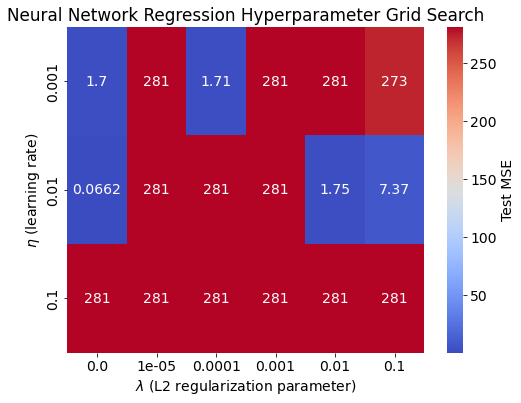

In [142]:
fig,ax = plt.subplots(figsize=(8,6))

sns.heatmap(nn_reg_grid, annot=True, cmap='coolwarm', fmt='.3g', cbar_kws={'label': 'Test MSE'})
ax.set_xticklabels(lmbdas.round(5))
ax.set_yticklabels(etas.round(5))
ax.set_ylabel("$\\eta$ (learning rate)")
ax.set_xlabel("$\\lambda$ (L2 regularization parameter)")
ax.set_title('Neural Network Regression Hyperparameter Grid Search')
fig.savefig('regression_nn_scratch_grid_search.jpg', dpi=1000, bbox_inches='tight')

### train this best model to 7500 epochs to reach lower error

In [143]:
npoints = 100
np.random.seed(1)
x = 3*np.random.rand(npoints,1)
y = 4 + 3*x + 2*x**2 + np.random.normal(0,0.1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

train = list(zip(X_train[:,0], y_train[:,0]))
test = list(zip(X_test[:,0], y_test[:,0]))

activ_funcs = ['relu', 'relu']
net_relu = neural_network([1, 50, 1], activ_funcs, 'regression', lmbda=0)

data_size = len(train)
n_epochs = 7500
eta = 0.01
test_mse_scratch_relu = net_relu.SGD(train, test, n_epochs, data_size, eta)

Epoch 0: 241.01339721679688
Epoch 1: 195.45416259765625
Epoch 2: 120.65340423583984
Epoch 3: 37.050048828125
Epoch 4: 3.622220993041992
Epoch 5: 3.5946948528289795
Epoch 6: 3.311697006225586
Epoch 7: 3.2478840351104736
Epoch 8: 3.158740997314453
Epoch 9: 3.0797336101531982
Epoch 10: 3.0048916339874268
Epoch 11: 2.9347589015960693
Epoch 12: 2.868978977203369
Epoch 13: 2.807276725769043
Epoch 14: 2.7493741512298584
Epoch 15: 2.6950438022613525
Epoch 16: 2.6440322399139404
Epoch 17: 2.595726490020752
Epoch 18: 2.5506114959716797
Epoch 19: 2.5081794261932373
Epoch 20: 2.468108654022217
Epoch 21: 2.430565357208252
Epoch 22: 2.395216703414917
Epoch 23: 2.3619461059570312
Epoch 24: 2.330571174621582
Epoch 25: 2.3010520935058594
Epoch 26: 2.2730298042297363
Epoch 27: 2.2468209266662598
Epoch 28: 2.221435070037842
Epoch 29: 2.198042154312134
Epoch 30: 2.1752076148986816
Epoch 31: 2.153923511505127
Epoch 32: 2.133992910385132
Epoch 33: 2.1148629188537598
Epoch 34: 2.0970466136932373
Epoch 35: 2.

Epoch 287: 0.7549763917922974
Epoch 288: 0.7509080171585083
Epoch 289: 0.7468501329421997
Epoch 290: 0.7428156733512878
Epoch 291: 0.7387884855270386
Epoch 292: 0.7347236275672913
Epoch 293: 0.7307290434837341
Epoch 294: 0.7267327308654785
Epoch 295: 0.7227563261985779
Epoch 296: 0.7188019752502441
Epoch 297: 0.7149385213851929
Epoch 298: 0.7123019695281982
Epoch 299: 0.7070481777191162
Epoch 300: 0.7050201296806335
Epoch 301: 0.6998475193977356
Epoch 302: 0.6968265175819397
Epoch 303: 0.6933536529541016
Epoch 304: 0.6892096996307373
Epoch 305: 0.6854658722877502
Epoch 306: 0.6823960542678833
Epoch 307: 0.6782023310661316
Epoch 308: 0.6745319962501526
Epoch 309: 0.6714791059494019
Epoch 310: 0.6673792004585266
Epoch 311: 0.6643233299255371
Epoch 312: 0.6602439880371094
Epoch 313: 0.6572154760360718
Epoch 314: 0.6531761288642883
Epoch 315: 0.6501978039741516
Epoch 316: 0.646192193031311
Epoch 317: 0.6432138681411743
Epoch 318: 0.6392476558685303
Epoch 319: 0.6364503502845764
Epoch 320: 

Epoch 571: 0.1818876564502716
Epoch 572: 0.18095818161964417
Epoch 573: 0.1800352782011032
Epoch 574: 0.17911826074123383
Epoch 575: 0.1782078742980957
Epoch 576: 0.17730417847633362
Epoch 577: 0.17640608549118042
Epoch 578: 0.175514355301857
Epoch 579: 0.1746281236410141
Epoch 580: 0.1737487018108368
Epoch 581: 0.1728755086660385
Epoch 582: 0.17200899124145508
Epoch 583: 0.1711474508047104
Epoch 584: 0.17029254138469696
Epoch 585: 0.16944286227226257
Epoch 586: 0.16860038042068481
Epoch 587: 0.16776332259178162
Epoch 588: 0.1669313609600067
Epoch 589: 0.1661064326763153
Epoch 590: 0.1652873456478119
Epoch 591: 0.16447319090366364
Epoch 592: 0.16366569697856903
Epoch 593: 0.16286331415176392
Epoch 594: 0.16206777095794678
Epoch 595: 0.16127684712409973
Epoch 596: 0.16049203276634216
Epoch 597: 0.1597127616405487
Epoch 598: 0.15893830358982086
Epoch 599: 0.1581709384918213
Epoch 600: 0.15740807354450226
Epoch 601: 0.15665146708488464
Epoch 602: 0.15589958429336548
Epoch 603: 0.155153706

Epoch 852: 0.08056507259607315
Epoch 853: 0.08051656186580658
Epoch 854: 0.08047085255384445
Epoch 855: 0.08042474091053009
Epoch 856: 0.0803801640868187
Epoch 857: 0.08033622056245804
Epoch 858: 0.08029282838106155
Epoch 859: 0.08025039732456207
Epoch 860: 0.08020852506160736
Epoch 861: 0.08016760647296906
Epoch 862: 0.08012723177671432
Epoch 863: 0.08008778840303421
Epoch 864: 0.0800488218665123
Epoch 865: 0.08001039177179337
Epoch 866: 0.07997304201126099
Epoch 867: 0.07993631064891815
Epoch 868: 0.07990007847547531
Epoch 869: 0.07986463606357574
Epoch 870: 0.07982992380857468
Epoch 871: 0.07979592680931091
Epoch 872: 0.0797625333070755
Epoch 873: 0.07972957193851471
Epoch 874: 0.0796973928809166
Epoch 875: 0.07966600358486176
Epoch 876: 0.0796348974108696
Epoch 877: 0.07960325479507446
Epoch 878: 0.07957624644041061
Epoch 879: 0.07954738289117813
Epoch 880: 0.07951944321393967
Epoch 881: 0.07949191331863403
Epoch 882: 0.07946472615003586
Epoch 883: 0.07941080629825592
Epoch 884: 0.

Epoch 1136: 0.05586184933781624
Epoch 1137: 0.05559848994016647
Epoch 1138: 0.05533823370933533
Epoch 1139: 0.05508187413215637
Epoch 1140: 0.05482954531908035
Epoch 1141: 0.054580651223659515
Epoch 1142: 0.05430570989847183
Epoch 1143: 0.05402286723256111
Epoch 1144: 0.053744006901979446
Epoch 1145: 0.05346925929188728
Epoch 1146: 0.05319823697209358
Epoch 1147: 0.052930623292922974
Epoch 1148: 0.0526670441031456
Epoch 1149: 0.052335429936647415
Epoch 1150: 0.05202009528875351
Epoch 1151: 0.051707733422517776
Epoch 1152: 0.05140460282564163
Epoch 1153: 0.051107265055179596
Epoch 1154: 0.05081669241189957
Epoch 1155: 0.050532110035419464
Epoch 1156: 0.050253260880708694
Epoch 1157: 0.0499800369143486
Epoch 1158: 0.04971224069595337
Epoch 1159: 0.04944957047700882
Epoch 1160: 0.049191683530807495
Epoch 1161: 0.04893890768289566
Epoch 1162: 0.0486907996237278
Epoch 1163: 0.04844715818762779
Epoch 1164: 0.04820765182375908
Epoch 1165: 0.047972701489925385
Epoch 1166: 0.047741424292325974


Epoch 1395: 0.02781641110777855
Epoch 1396: 0.027775337919592857
Epoch 1397: 0.027734538540244102
Epoch 1398: 0.02769363857805729
Epoch 1399: 0.027653168886899948
Epoch 1400: 0.027612458914518356
Epoch 1401: 0.02757211960852146
Epoch 1402: 0.02753133699297905
Epoch 1403: 0.027489859610795975
Epoch 1404: 0.027448344975709915
Epoch 1405: 0.027406802400946617
Epoch 1406: 0.027365734800696373
Epoch 1407: 0.02732464112341404
Epoch 1408: 0.027283569797873497
Epoch 1409: 0.02724277600646019
Epoch 1410: 0.02720187045633793
Epoch 1411: 0.02716115675866604
Epoch 1412: 0.02712045982480049
Epoch 1413: 0.027079608291387558
Epoch 1414: 0.027037790045142174
Epoch 1415: 0.026996323838829994
Epoch 1416: 0.026954924687743187
Epoch 1417: 0.02691357396543026
Epoch 1418: 0.0268722977489233
Epoch 1419: 0.026831086724996567
Epoch 1420: 0.026790115982294083
Epoch 1421: 0.026751607656478882
Epoch 1422: 0.02671116217970848
Epoch 1423: 0.026671480387449265
Epoch 1424: 0.026631776243448257
Epoch 1425: 0.026591498

Epoch 1650: 0.01930377259850502
Epoch 1651: 0.019281785935163498
Epoch 1652: 0.019259832799434662
Epoch 1653: 0.01923813670873642
Epoch 1654: 0.019216174259781837
Epoch 1655: 0.0191947091370821
Epoch 1656: 0.019172847270965576
Epoch 1657: 0.01915135234594345
Epoch 1658: 0.019129713997244835
Epoch 1659: 0.019108278676867485
Epoch 1660: 0.019086763262748718
Epoch 1661: 0.019065506756305695
Epoch 1662: 0.019044097512960434
Epoch 1663: 0.019022982567548752
Epoch 1664: 0.019001532346010208
Epoch 1665: 0.018980583176016808
Epoch 1666: 0.018959298729896545
Epoch 1667: 0.01893828809261322
Epoch 1668: 0.018917327746748924
Epoch 1669: 0.01889636740088463
Epoch 1670: 0.01887553557753563
Epoch 1671: 0.01885460503399372
Epoch 1672: 0.018833721056580544
Epoch 1673: 0.018813107162714005
Epoch 1674: 0.018792208284139633
Epoch 1675: 0.01877143420279026
Epoch 1676: 0.018751289695501328
Epoch 1677: 0.018730776384472847
Epoch 1678: 0.018710695207118988
Epoch 1679: 0.01869034580886364
Epoch 1680: 0.0186703

Epoch 1901: 0.015400322154164314
Epoch 1902: 0.015389049425721169
Epoch 1903: 0.015378134325146675
Epoch 1904: 0.01536691002547741
Epoch 1905: 0.015355847775936127
Epoch 1906: 0.015344846062362194
Epoch 1907: 0.015333722345530987
Epoch 1908: 0.015322779305279255
Epoch 1909: 0.015311673283576965
Epoch 1910: 0.015300842002034187
Epoch 1911: 0.01528969593346119
Epoch 1912: 0.01527868676930666
Epoch 1913: 0.015267735347151756
Epoch 1914: 0.01525682769715786
Epoch 1915: 0.015245871618390083
Epoch 1916: 0.015235004015266895
Epoch 1917: 0.015223902650177479
Epoch 1918: 0.015213075093925
Epoch 1919: 0.015202151611447334
Epoch 1920: 0.015191356651484966
Epoch 1921: 0.015180396847426891
Epoch 1922: 0.015169518068432808
Epoch 1923: 0.015158613212406635
Epoch 1924: 0.01514782477170229
Epoch 1925: 0.015136947855353355
Epoch 1926: 0.015126114711165428
Epoch 1927: 0.015115397050976753
Epoch 1928: 0.015104644000530243
Epoch 1929: 0.01509382389485836
Epoch 1930: 0.01508348435163498
Epoch 1931: 0.015073

Epoch 2172: 0.012853564694523811
Epoch 2173: 0.012846107594668865
Epoch 2174: 0.012838688679039478
Epoch 2175: 0.012831533327698708
Epoch 2176: 0.01282411627471447
Epoch 2177: 0.01281680166721344
Epoch 2178: 0.012809479609131813
Epoch 2179: 0.012802143581211567
Epoch 2180: 0.012794959358870983
Epoch 2181: 0.012787537649273872
Epoch 2182: 0.012780393473803997
Epoch 2183: 0.012773056514561176
Epoch 2184: 0.012765781953930855
Epoch 2185: 0.012758569791913033
Epoch 2186: 0.012751390226185322
Epoch 2187: 0.01274409331381321
Epoch 2188: 0.01273693609982729
Epoch 2189: 0.01272968202829361
Epoch 2190: 0.012722553685307503
Epoch 2191: 0.012715374119579792
Epoch 2192: 0.012708084657788277
Epoch 2193: 0.012701010331511497
Epoch 2194: 0.012693934142589569
Epoch 2195: 0.012686709873378277
Epoch 2196: 0.01267954707145691
Epoch 2197: 0.01267253141850233
Epoch 2198: 0.012665340676903725
Epoch 2199: 0.012658169493079185
Epoch 2200: 0.012651177123188972
Epoch 2201: 0.012643992900848389
Epoch 2202: 0.012

Epoch 2425: 0.011301353573799133
Epoch 2426: 0.011296374723315239
Epoch 2427: 0.011291378177702427
Epoch 2428: 0.011286324821412563
Epoch 2429: 0.011281445622444153
Epoch 2430: 0.011276465840637684
Epoch 2431: 0.01127155777066946
Epoch 2432: 0.011266535148024559
Epoch 2433: 0.01126151718199253
Epoch 2434: 0.011256605386734009
Epoch 2435: 0.01125171035528183
Epoch 2436: 0.011246778070926666
Epoch 2437: 0.011241781525313854
Epoch 2438: 0.011236986145377159
Epoch 2439: 0.011232128366827965
Epoch 2440: 0.011227240785956383
Epoch 2441: 0.0112222321331501
Epoch 2442: 0.011217307299375534
Epoch 2443: 0.01121254451572895
Epoch 2444: 0.0112077035009861
Epoch 2445: 0.011202815920114517
Epoch 2446: 0.011197932995855808
Epoch 2447: 0.011193137615919113
Epoch 2448: 0.011188209056854248
Epoch 2449: 0.011183442547917366
Epoch 2450: 0.011178631335496902
Epoch 2451: 0.01117398776113987
Epoch 2452: 0.0111690703779459
Epoch 2453: 0.011164309456944466
Epoch 2454: 0.0111595643684268
Epoch 2455: 0.011154633

Epoch 2678: 0.010258197784423828
Epoch 2679: 0.010254749096930027
Epoch 2680: 0.010251332074403763
Epoch 2681: 0.010247958824038506
Epoch 2682: 0.010244693607091904
Epoch 2683: 0.01024128682911396
Epoch 2684: 0.01023797132074833
Epoch 2685: 0.010234534740447998
Epoch 2686: 0.010231252759695053
Epoch 2687: 0.010227877646684647
Epoch 2688: 0.010224533267319202
Epoch 2689: 0.010221193544566631
Epoch 2690: 0.010218041948974133
Epoch 2691: 0.010214671492576599
Epoch 2692: 0.010211413726210594
Epoch 2693: 0.010208165273070335
Epoch 2694: 0.010204864665865898
Epoch 2695: 0.01020167674869299
Epoch 2696: 0.01019841618835926
Epoch 2697: 0.010195152834057808
Epoch 2698: 0.010191929526627064
Epoch 2699: 0.010188628919422626
Epoch 2700: 0.010185467079281807
Epoch 2701: 0.010182293131947517
Epoch 2702: 0.010179029777646065
Epoch 2703: 0.010175714269280434
Epoch 2704: 0.010172542184591293
Epoch 2705: 0.010169374756515026
Epoch 2706: 0.01016619335860014
Epoch 2707: 0.010163074359297752
Epoch 2708: 0.0

Epoch 2932: 0.009528505615890026
Epoch 2933: 0.009525911882519722
Epoch 2934: 0.009523297660052776
Epoch 2935: 0.009520845487713814
Epoch 2936: 0.00951826386153698
Epoch 2937: 0.009515810757875443
Epoch 2938: 0.009513193741440773
Epoch 2939: 0.009510746225714684
Epoch 2940: 0.009508178569376469
Epoch 2941: 0.009505699388682842
Epoch 2942: 0.009503144770860672
Epoch 2943: 0.00950060784816742
Epoch 2944: 0.009498095139861107
Epoch 2945: 0.009495656006038189
Epoch 2946: 0.00949313584715128
Epoch 2947: 0.009490612894296646
Epoch 2948: 0.00948813371360302
Epoch 2949: 0.009485647082328796
Epoch 2950: 0.009483160451054573
Epoch 2951: 0.00948059931397438
Epoch 2952: 0.009478174149990082
Epoch 2953: 0.009475590661168098
Epoch 2954: 0.00947315152734518
Epoch 2955: 0.009470682591199875
Epoch 2956: 0.009468126110732555
Epoch 2957: 0.009465700946748257
Epoch 2958: 0.009463290683925152
Epoch 2959: 0.00946076400578022
Epoch 2960: 0.009458270855247974
Epoch 2961: 0.00945592112839222
Epoch 2962: 0.0094

Epoch 3186: 0.008961277082562447
Epoch 3187: 0.008959311991930008
Epoch 3188: 0.008957249112427235
Epoch 3189: 0.00895518995821476
Epoch 3190: 0.008953193202614784
Epoch 3191: 0.008951233699917793
Epoch 3192: 0.008949154056608677
Epoch 3193: 0.008947215974330902
Epoch 3194: 0.008945191279053688
Epoch 3195: 0.008943213149905205
Epoch 3196: 0.008941171690821648
Epoch 3197: 0.00893917866051197
Epoch 3198: 0.008937103673815727
Epoch 3199: 0.008935166522860527
Epoch 3200: 0.008933115750551224
Epoch 3201: 0.008931154385209084
Epoch 3202: 0.00892912782728672
Epoch 3203: 0.008927206508815289
Epoch 3204: 0.00892520509660244
Epoch 3205: 0.00892320554703474
Epoch 3206: 0.008921155706048012
Epoch 3207: 0.00891916360706091
Epoch 3208: 0.008917230181396008
Epoch 3209: 0.008915253914892673
Epoch 3210: 0.008913256227970123
Epoch 3211: 0.008911331184208393
Epoch 3212: 0.008909479714930058
Epoch 3213: 0.008907568641006947
Epoch 3214: 0.008905751630663872
Epoch 3215: 0.008903825655579567
Epoch 3216: 0.00

Epoch 3460: 0.008503742516040802
Epoch 3461: 0.008502138778567314
Epoch 3462: 0.008500521071255207
Epoch 3463: 0.00849890522658825
Epoch 3464: 0.008497352711856365
Epoch 3465: 0.00849570520222187
Epoch 3466: 0.008494114503264427
Epoch 3467: 0.008492396213114262
Epoch 3468: 0.008490840904414654
Epoch 3469: 0.008489321917295456
Epoch 3470: 0.008487643674015999
Epoch 3471: 0.008486012928187847
Epoch 3472: 0.008484392426908016
Epoch 3473: 0.00848280731588602
Epoch 3474: 0.008481244556605816
Epoch 3475: 0.008479568175971508
Epoch 3476: 0.008478070609271526
Epoch 3477: 0.008476531133055687
Epoch 3478: 0.008474841713905334
Epoch 3479: 0.008473227731883526
Epoch 3480: 0.008471659384667873
Epoch 3481: 0.008470075204968452
Epoch 3482: 0.008468540385365486
Epoch 3483: 0.008466861210763454
Epoch 3484: 0.008465385995805264
Epoch 3485: 0.008463794365525246
Epoch 3486: 0.008462191559374332
Epoch 3487: 0.008460581302642822
Epoch 3488: 0.008459033444523811
Epoch 3489: 0.008457477204501629
Epoch 3490: 0

Epoch 3714: 0.008138410747051239
Epoch 3715: 0.008137105032801628
Epoch 3716: 0.008135792799293995
Epoch 3717: 0.008134456351399422
Epoch 3718: 0.008133315481245518
Epoch 3719: 0.00813186727464199
Epoch 3720: 0.00813065841794014
Epoch 3721: 0.008129391819238663
Epoch 3722: 0.008128134533762932
Epoch 3723: 0.008126772940158844
Epoch 3724: 0.00812549889087677
Epoch 3725: 0.008124208077788353
Epoch 3726: 0.008122995495796204
Epoch 3727: 0.008121594786643982
Epoch 3728: 0.008120345883071423
Epoch 3729: 0.008119077421724796
Epoch 3730: 0.008117832243442535
Epoch 3731: 0.008116491138935089
Epoch 3732: 0.008115232922136784
Epoch 3733: 0.008113970048725605
Epoch 3734: 0.008112716488540173
Epoch 3735: 0.008111365139484406
Epoch 3736: 0.008110079914331436
Epoch 3737: 0.00810888223350048
Epoch 3738: 0.008107539266347885
Epoch 3739: 0.00810631737112999
Epoch 3740: 0.008104975335299969
Epoch 3741: 0.008103691041469574
Epoch 3742: 0.008102474734187126
Epoch 3743: 0.00810119416564703
Epoch 3744: 0.00

Epoch 3968: 0.007829565554857254
Epoch 3969: 0.007828393951058388
Epoch 3970: 0.007827257737517357
Epoch 3971: 0.007826130837202072
Epoch 3972: 0.007824954576790333
Epoch 3973: 0.00782383419573307
Epoch 3974: 0.007822679355740547
Epoch 3975: 0.007821549661457539
Epoch 3976: 0.007820343598723412
Epoch 3977: 0.007819225080311298
Epoch 3978: 0.007818049751222134
Epoch 3979: 0.007816972211003304
Epoch 3980: 0.007815692573785782
Epoch 3981: 0.007814621552824974
Epoch 3982: 0.007813496515154839
Epoch 3983: 0.007812329567968845
Epoch 3984: 0.0078112357296049595
Epoch 3985: 0.0078100599348545074
Epoch 3986: 0.007808927446603775
Epoch 3987: 0.007807777728885412
Epoch 3988: 0.0078065707348287106
Epoch 3989: 0.007805473171174526
Epoch 3990: 0.007804335094988346
Epoch 3991: 0.007803252432495356
Epoch 3992: 0.0078020403161644936
Epoch 3993: 0.007800891064107418
Epoch 3994: 0.007799708750098944
Epoch 3995: 0.007798540405929089
Epoch 3996: 0.00779742980375886
Epoch 3997: 0.007796256337314844
Epoch 39

Epoch 4225: 0.007517366670072079
Epoch 4226: 0.007515744771808386
Epoch 4227: 0.007516123354434967
Epoch 4228: 0.00751431193202734
Epoch 4229: 0.00751366326585412
Epoch 4230: 0.007512444164603949
Epoch 4231: 0.007511422969400883
Epoch 4232: 0.007510365452617407
Epoch 4233: 0.0075093647465109825
Epoch 4234: 0.007508280221372843
Epoch 4235: 0.007507236208766699
Epoch 4236: 0.00750621547922492
Epoch 4237: 0.007505204528570175
Epoch 4238: 0.007504083216190338
Epoch 4239: 0.0075030820444226265
Epoch 4240: 0.007502069231122732
Epoch 4241: 0.007500407285988331
Epoch 4242: 0.00750079145655036
Epoch 4243: 0.0074989646673202515
Epoch 4244: 0.007498142775148153
Epoch 4245: 0.007496797479689121
Epoch 4246: 0.00749577209353447
Epoch 4247: 0.007494586519896984
Epoch 4248: 0.00749350618571043
Epoch 4249: 0.007492426782846451
Epoch 4250: 0.007491284050047398
Epoch 4251: 0.007490211166441441
Epoch 4252: 0.007489101029932499
Epoch 4253: 0.007487963885068893
Epoch 4254: 0.007486890070140362
Epoch 4255: 0

Epoch 4477: 0.007243012078106403
Epoch 4478: 0.007240727543830872
Epoch 4479: 0.007239616010338068
Epoch 4480: 0.007237911224365234
Epoch 4481: 0.007236098404973745
Epoch 4482: 0.00723602157086134
Epoch 4483: 0.007233854383230209
Epoch 4484: 0.0072326757945120335
Epoch 4485: 0.007231063209474087
Epoch 4486: 0.007229754235595465
Epoch 4487: 0.0072278352454304695
Epoch 4488: 0.007227879948914051
Epoch 4489: 0.007225784007459879
Epoch 4490: 0.00722469249740243
Epoch 4491: 0.007223113439977169
Epoch 4492: 0.007221406791359186
Epoch 4493: 0.00722142169252038
Epoch 4494: 0.007219328545033932
Epoch 4495: 0.007218276150524616
Epoch 4496: 0.007216735742986202
Epoch 4497: 0.007215561810880899
Epoch 4498: 0.007213623262941837
Epoch 4499: 0.007213870994746685
Epoch 4500: 0.007211742457002401
Epoch 4501: 0.007210790179669857
Epoch 4502: 0.00720931077376008
Epoch 4503: 0.007207604590803385
Epoch 4504: 0.007207744754850864
Epoch 4505: 0.007205639965832233
Epoch 4506: 0.007204656954854727
Epoch 4507: 

Epoch 4729: 0.0069895111955702305
Epoch 4730: 0.006987888365983963
Epoch 4731: 0.00698669720441103
Epoch 4732: 0.006986933294683695
Epoch 4733: 0.006985197309404612
Epoch 4734: 0.006984107196331024
Epoch 4735: 0.006984336767345667
Epoch 4736: 0.0069826520048081875
Epoch 4737: 0.006981699727475643
Epoch 4738: 0.006981813348829746
Epoch 4739: 0.006980161182582378
Epoch 4740: 0.006979038007557392
Epoch 4741: 0.006979240570217371
Epoch 4742: 0.006977608893066645
Epoch 4743: 0.006976485252380371
Epoch 4744: 0.0069767748937010765
Epoch 4745: 0.006975000258535147
Epoch 4746: 0.006973946932703257
Epoch 4747: 0.006974146701395512
Epoch 4748: 0.006972098257392645
Epoch 4749: 0.006972747389227152
Epoch 4750: 0.0069708265364170074
Epoch 4751: 0.0069698854349553585
Epoch 4752: 0.006970011629164219
Epoch 4753: 0.006968311034142971
Epoch 4754: 0.0069672539830207825
Epoch 4755: 0.006967474706470966
Epoch 4756: 0.0069657377898693085
Epoch 4757: 0.006964606232941151
Epoch 4758: 0.006964856293052435
Epoc

Epoch 4981: 0.0067877573892474174
Epoch 4982: 0.006785514298826456
Epoch 4983: 0.006786225829273462
Epoch 4984: 0.0067840018309652805
Epoch 4985: 0.006784313824027777
Epoch 4986: 0.006783731281757355
Epoch 4987: 0.006782046053558588
Epoch 4988: 0.006782562471926212
Epoch 4989: 0.006780358962714672
Epoch 4990: 0.0067810183390975
Epoch 4991: 0.006778826471418142
Epoch 4992: 0.006779532879590988
Epoch 4993: 0.00677731866016984
Epoch 4994: 0.006777906324714422
Epoch 4995: 0.006775701884180307
Epoch 4996: 0.006776431109756231
Epoch 4997: 0.006774186156690121
Epoch 4998: 0.006774961017072201
Epoch 4999: 0.006772639695554972
Epoch 5000: 0.006773400120437145
Epoch 5001: 0.006771107204258442
Epoch 5002: 0.006771506275981665
Epoch 5003: 0.006770967040210962
Epoch 5004: 0.00676935538649559
Epoch 5005: 0.006769669707864523
Epoch 5006: 0.00676762918010354
Epoch 5007: 0.0067682815715670586
Epoch 5008: 0.006765977945178747
Epoch 5009: 0.0067666745744645596
Epoch 5010: 0.006764412857592106
Epoch 5011:

Epoch 5230: 0.006608105264604092
Epoch 5231: 0.00660731503739953
Epoch 5232: 0.006607183255255222
Epoch 5233: 0.00660528102889657
Epoch 5234: 0.006605436094105244
Epoch 5235: 0.00660486426204443
Epoch 5236: 0.006603121757507324
Epoch 5237: 0.006603064481168985
Epoch 5238: 0.006602272391319275
Epoch 5239: 0.006602066103368998
Epoch 5240: 0.006600069347769022
Epoch 5241: 0.006600110325962305
Epoch 5242: 0.006599190644919872
Epoch 5243: 0.006599028594791889
Epoch 5244: 0.006597063038498163
Epoch 5245: 0.006597170140594244
Epoch 5246: 0.006596182473003864
Epoch 5247: 0.0065960451029241085
Epoch 5248: 0.0065940371714532375
Epoch 5249: 0.006594087928533554
Epoch 5250: 0.006593109108507633
Epoch 5251: 0.00659299036487937
Epoch 5252: 0.006590931676328182
Epoch 5253: 0.006591086741536856
Epoch 5254: 0.006590072996914387
Epoch 5255: 0.006589858792722225
Epoch 5256: 0.006587919779121876
Epoch 5257: 0.0065880222246050835
Epoch 5258: 0.006587089039385319
Epoch 5259: 0.006586901843547821
Epoch 5260:

Epoch 5484: 0.006422187201678753
Epoch 5485: 0.006421455182135105
Epoch 5486: 0.006420757621526718
Epoch 5487: 0.006420033983886242
Epoch 5488: 0.0064194402657449245
Epoch 5489: 0.0064185732044279575
Epoch 5490: 0.006418029312044382
Epoch 5491: 0.006417242344468832
Epoch 5492: 0.006416535470634699
Epoch 5493: 0.0064158751629292965
Epoch 5494: 0.006415178533643484
Epoch 5495: 0.006414479576051235
Epoch 5496: 0.006413787603378296
Epoch 5497: 0.006413119379431009
Epoch 5498: 0.00641234964132309
Epoch 5499: 0.0064117154106497765
Epoch 5500: 0.006411013659089804
Epoch 5501: 0.006410292349755764
Epoch 5502: 0.006409596651792526
Epoch 5503: 0.006408868823200464
Epoch 5504: 0.0064082071185112
Epoch 5505: 0.006407557986676693
Epoch 5506: 0.006406793836504221
Epoch 5507: 0.006406082771718502
Epoch 5508: 0.006405459251254797
Epoch 5509: 0.006404717918485403
Epoch 5510: 0.006404025945812464
Epoch 5511: 0.006403305567800999
Epoch 5512: 0.006402645260095596
Epoch 5513: 0.006401938386261463
Epoch 551

Epoch 5737: 0.0062409574165940285
Epoch 5738: 0.006240158807486296
Epoch 5739: 0.006239494774490595
Epoch 5740: 0.0062386998906731606
Epoch 5741: 0.006238074507564306
Epoch 5742: 0.006237249821424484
Epoch 5743: 0.0062365783378481865
Epoch 5744: 0.0062358565628528595
Epoch 5745: 0.00623504351824522
Epoch 5746: 0.006234318949282169
Epoch 5747: 0.006233524065464735
Epoch 5748: 0.006232880521565676
Epoch 5749: 0.006232088897377253
Epoch 5750: 0.006231370847672224
Epoch 5751: 0.006230649072676897
Epoch 5752: 0.006229935679584742
Epoch 5753: 0.006229187827557325
Epoch 5754: 0.006228314712643623
Epoch 5755: 0.00622770469635725
Epoch 5756: 0.006226902361959219
Epoch 5757: 0.0062262024730443954
Epoch 5758: 0.006225469056516886
Epoch 5759: 0.00622472632676363
Epoch 5760: 0.006224009208381176
Epoch 5761: 0.0062231989577412605
Epoch 5762: 0.0062225209549069405
Epoch 5763: 0.006221707910299301
Epoch 5764: 0.006221025250852108
Epoch 5765: 0.00621825223788619
Epoch 5766: 0.006217694375663996
Epoch 5

Epoch 5992: 0.006024553440511227
Epoch 5993: 0.006023784633725882
Epoch 5994: 0.006023051217198372
Epoch 5995: 0.006022258196026087
Epoch 5996: 0.006021571811288595
Epoch 5997: 0.0060208626091480255
Epoch 5998: 0.006020053289830685
Epoch 5999: 0.0060193222016096115
Epoch 6000: 0.006018609739840031
Epoch 6001: 0.006017880514264107
Epoch 6002: 0.006017104722559452
Epoch 6003: 0.006016362924128771
Epoch 6004: 0.006015567108988762
Epoch 6005: 0.006014871411025524
Epoch 6006: 0.00601415429264307
Epoch 6007: 0.006013284437358379
Epoch 6008: 0.006012639496475458
Epoch 6009: 0.006011892110109329
Epoch 6010: 0.006011110730469227
Epoch 6011: 0.006010418292135
Epoch 6012: 0.006009644828736782
Epoch 6013: 0.006008909083902836
Epoch 6014: 0.006008123513311148
Epoch 6015: 0.006007402669638395
Epoch 6016: 0.006006662268191576
Epoch 6017: 0.006005971226841211
Epoch 6018: 0.006005192641168833
Epoch 6019: 0.006004379130899906
Epoch 6020: 0.006003646645694971
Epoch 6021: 0.0060029360465705395
Epoch 6022:

Epoch 6243: 0.005835987627506256
Epoch 6244: 0.005835187621414661
Epoch 6245: 0.005834478884935379
Epoch 6246: 0.005833745934069157
Epoch 6247: 0.00583302229642868
Epoch 6248: 0.0058321477845311165
Epoch 6249: 0.005831488408148289
Epoch 6250: 0.005830720998346806
Epoch 6251: 0.0058300187811255455
Epoch 6252: 0.005829219706356525
Epoch 6253: 0.005828536115586758
Epoch 6254: 0.005827742163091898
Epoch 6255: 0.005826974753290415
Epoch 6256: 0.005826273467391729
Epoch 6257: 0.005825474858283997
Epoch 6258: 0.005824797321110964
Epoch 6259: 0.005824018735438585
Epoch 6260: 0.00582327414304018
Epoch 6261: 0.005822514649480581
Epoch 6262: 0.005821821745485067
Epoch 6263: 0.00582101522013545
Epoch 6264: 0.005820292513817549
Epoch 6265: 0.005819583777338266
Epoch 6266: 0.005818788427859545
Epoch 6267: 0.005818113684654236
Epoch 6268: 0.005817281547933817
Epoch 6269: 0.005816557444632053
Epoch 6270: 0.005815859884023666
Epoch 6271: 0.005815000738948584
Epoch 6272: 0.0058142999187111855
Epoch 6273

Epoch 6493: 0.005671746097505093
Epoch 6494: 0.005672105122357607
Epoch 6495: 0.005670567508786917
Epoch 6496: 0.005671355873346329
Epoch 6497: 0.0056697772815823555
Epoch 6498: 0.005669191479682922
Epoch 6499: 0.005669593811035156
Epoch 6500: 0.005667940713465214
Epoch 6501: 0.005668855272233486
Epoch 6502: 0.00566718028858304
Epoch 6503: 0.0056665921583771706
Epoch 6504: 0.0056669809855520725
Epoch 6505: 0.005665407050400972
Epoch 6506: 0.005666199140250683
Epoch 6507: 0.005664566997438669
Epoch 6508: 0.005663973279297352
Epoch 6509: 0.0056643737480044365
Epoch 6510: 0.0056627714075148106
Epoch 6511: 0.005663613323122263
Epoch 6512: 0.005662024486809969
Epoch 6513: 0.005661401432007551
Epoch 6514: 0.005661764182150364
Epoch 6515: 0.005660095252096653
Epoch 6516: 0.005661009345203638
Epoch 6517: 0.005659224931150675
Epoch 6518: 0.0056601702235639095
Epoch 6519: 0.005658451467752457
Epoch 6520: 0.005657908506691456
Epoch 6521: 0.0056582605466246605
Epoch 6522: 0.00565666239708662
Epoch

Epoch 6768: 0.005542940925806761
Epoch 6769: 0.005543277598917484
Epoch 6770: 0.0055429404601454735
Epoch 6771: 0.0055415877141058445
Epoch 6772: 0.00554195512086153
Epoch 6773: 0.005541613791137934
Epoch 6774: 0.005540278274565935
Epoch 6775: 0.005540800280869007
Epoch 6776: 0.0055390396155416965
Epoch 6777: 0.005539626814424992
Epoch 6778: 0.005539196077734232
Epoch 6779: 0.00553789222612977
Epoch 6780: 0.005538222845643759
Epoch 6781: 0.005537909921258688
Epoch 6782: 0.00553656741976738
Epoch 6783: 0.00553687009960413
Epoch 6784: 0.005536581389605999
Epoch 6785: 0.005535208620131016
Epoch 6786: 0.005535537842661142
Epoch 6787: 0.005535265430808067
Epoch 6788: 0.005533899180591106
Epoch 6789: 0.005534277763217688
Epoch 6790: 0.005533877294510603
Epoch 6791: 0.00553255807608366
Epoch 6792: 0.005532895680516958
Epoch 6793: 0.005532498005777597
Epoch 6794: 0.0055311755277216434
Epoch 6795: 0.0055315569043159485
Epoch 6796: 0.005531139671802521
Epoch 6797: 0.005529876798391342
Epoch 6798

Epoch 7043: 0.005426649935543537
Epoch 7044: 0.005425979383289814
Epoch 7045: 0.005425859242677689
Epoch 7046: 0.005425342358648777
Epoch 7047: 0.005425059236586094
Epoch 7048: 0.005424712784588337
Epoch 7049: 0.005424319766461849
Epoch 7050: 0.005424003582447767
Epoch 7051: 0.0054236529394984245
Epoch 7052: 0.005423345137387514
Epoch 7053: 0.005423114635050297
Epoch 7054: 0.005421563051640987
Epoch 7055: 0.005421891342848539
Epoch 7056: 0.0054212044924497604
Epoch 7057: 0.005421004723757505
Epoch 7058: 0.0054206266067922115
Epoch 7059: 0.005420262459665537
Epoch 7060: 0.005419916473329067
Epoch 7061: 0.00541955279186368
Epoch 7062: 0.005419215187430382
Epoch 7063: 0.005418844986706972
Epoch 7064: 0.0054184808395802975
Epoch 7065: 0.005418164189904928
Epoch 7066: 0.005417708307504654
Epoch 7067: 0.005417411215603352
Epoch 7068: 0.005417057313024998
Epoch 7069: 0.005416837986558676
Epoch 7070: 0.005415256135165691
Epoch 7071: 0.0054154833778738976
Epoch 7072: 0.005414861720055342
Epoch 

Epoch 7292: 0.005325006786733866
Epoch 7293: 0.005324547179043293
Epoch 7294: 0.0053241075947880745
Epoch 7295: 0.005323692224919796
Epoch 7296: 0.005323260091245174
Epoch 7297: 0.005322830285876989
Epoch 7298: 0.00532241677865386
Epoch 7299: 0.005321943201124668
Epoch 7300: 0.00532145332545042
Epoch 7301: 0.005321016069501638
Epoch 7302: 0.005320609547197819
Epoch 7303: 0.005320148542523384
Epoch 7304: 0.0053196800872683525
Epoch 7305: 0.005319290794432163
Epoch 7306: 0.005318753886967897
Epoch 7307: 0.005318358540534973
Epoch 7308: 0.005317848641425371
Epoch 7309: 0.005317388102412224
Epoch 7310: 0.005316936410963535
Epoch 7311: 0.005316594149917364
Epoch 7312: 0.005316069349646568
Epoch 7313: 0.0053156036883592606
Epoch 7314: 0.0053152055479586124
Epoch 7315: 0.005314757116138935
Epoch 7316: 0.005314289592206478
Epoch 7317: 0.005313758738338947
Epoch 7318: 0.005313345231115818
Epoch 7319: 0.005312917288392782
Epoch 7320: 0.005312423687428236
Epoch 7321: 0.005312038119882345
Epoch 73

C:\Users\owehuf\AppData\Local\Temp\ipykernel_22424\3613085993.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axins.set_xticklabels(range(6950, 7250, 50));


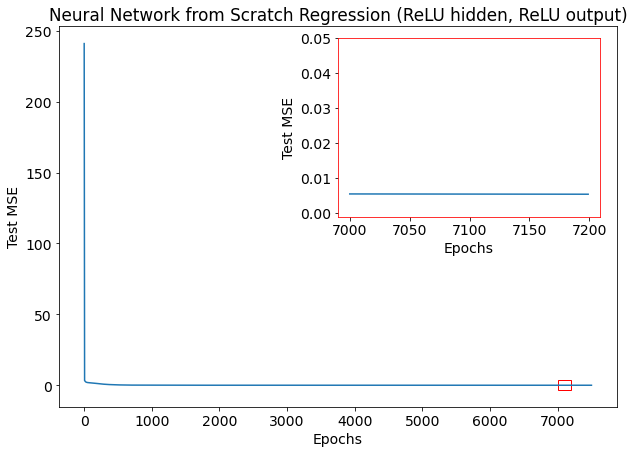

In [144]:
plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(figsize=(10,7))

ax.plot(test_mse_scratch_relu)
ax.set_ylabel('Test MSE')
ax.set_xlabel('Epochs')
rect = patches.Rectangle((7000, -3), 200, 7, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.set_title('Neural Network from Scratch Regression (ReLU hidden, ReLU output)')


axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47]);
axins.plot(test_mse_scratch_relu[7000:7200])
axins.set_xticklabels(range(6950, 7250, 50));
axins.set_ylabel('Test MSE')
axins.set_xlabel('Epochs')
axins.set_ylim(-0.001, 0.05)
plt.setp(axins.spines.values(), color='red');
fig.savefig('regression_nn_scratch_convergence.jpg', dpi=1000, bbox_inches='tight')

### Tensorflow

In [145]:
set_seed(5)
model = Sequential([
Dense(50, activation='relu'),
Dense(1, activation='relu')
])
n_epochs = 7500
model.compile(loss=mse, optimizer=optimizers.SGD(learning_rate=eta), metrics=['mse'])

train_history = model.fit(X_train, y_train, epochs=n_epochs, validation_data=(X_test, y_test))



Epoch 1/7500
3/3 [==============================] - 0s 63ms/step - loss: 193.6542 - mse: 193.6542 - val_loss: 22.3236 - val_mse: 22.3236
Epoch 2/7500
3/3 [==============================] - 0s 13ms/step - loss: 11.7522 - mse: 11.7522 - val_loss: 2.8896 - val_mse: 2.8896
Epoch 3/7500
3/3 [==============================] - 0s 14ms/step - loss: 3.1054 - mse: 3.1054 - val_loss: 2.5694 - val_mse: 2.5694
Epoch 4/7500
3/3 [==============================] - 0s 14ms/step - loss: 2.7936 - mse: 2.7936 - val_loss: 2.1380 - val_mse: 2.1380
Epoch 5/7500
3/3 [==============================] - 0s 13ms/step - loss: 2.6541 - mse: 2.6541 - val_loss: 2.8460 - val_mse: 2.8460
Epoch 6/7500
3/3 [==============================] - 0s 14ms/step - loss: 2.4121 - mse: 2.4121 - val_loss: 3.2683 - val_mse: 3.2683
Epoch 7/7500
3/3 [==============================] - 0s 13ms/step - loss: 2.2794 - mse: 2.2794 - val_loss: 2.1525 - val_mse: 2.1525
Epoch 8/7500
3/3 [==============================] - 0s 12ms/step - loss: 2.

3/3 [==============================] - 0s 14ms/step - loss: 1.8472 - mse: 1.8472 - val_loss: 1.3432 - val_mse: 1.3432
Epoch 64/7500
3/3 [==============================] - 0s 13ms/step - loss: 1.9675 - mse: 1.9675 - val_loss: 1.2662 - val_mse: 1.2662
Epoch 65/7500
3/3 [==============================] - 0s 12ms/step - loss: 1.8315 - mse: 1.8315 - val_loss: 1.5123 - val_mse: 1.5123
Epoch 66/7500
3/3 [==============================] - 0s 12ms/step - loss: 1.7913 - mse: 1.7913 - val_loss: 1.3303 - val_mse: 1.3303
Epoch 67/7500
3/3 [==============================] - 0s 13ms/step - loss: 1.7983 - mse: 1.7983 - val_loss: 1.2953 - val_mse: 1.2953
Epoch 68/7500
3/3 [==============================] - 0s 12ms/step - loss: 1.8496 - mse: 1.8496 - val_loss: 2.4573 - val_mse: 2.4573
Epoch 69/7500
3/3 [==============================] - 0s 13ms/step - loss: 2.0066 - mse: 2.0066 - val_loss: 2.8849 - val_mse: 2.8849
Epoch 70/7500
3/3 [==============================] - 0s 14ms/step - loss: 2.1514 - mse: 2.

Epoch 125/7500
3/3 [==============================] - 0s 11ms/step - loss: 1.3713 - mse: 1.3713 - val_loss: 1.2146 - val_mse: 1.2146
Epoch 126/7500
3/3 [==============================] - 0s 12ms/step - loss: 1.4555 - mse: 1.4555 - val_loss: 1.4034 - val_mse: 1.4034
Epoch 127/7500
3/3 [==============================] - 0s 11ms/step - loss: 1.3553 - mse: 1.3553 - val_loss: 1.2453 - val_mse: 1.2453
Epoch 128/7500
3/3 [==============================] - 0s 12ms/step - loss: 1.4264 - mse: 1.4264 - val_loss: 1.0578 - val_mse: 1.0578
Epoch 129/7500
3/3 [==============================] - 0s 12ms/step - loss: 1.3783 - mse: 1.3783 - val_loss: 1.2290 - val_mse: 1.2290
Epoch 130/7500
3/3 [==============================] - 0s 12ms/step - loss: 1.6598 - mse: 1.6598 - val_loss: 1.5010 - val_mse: 1.5010
Epoch 131/7500
3/3 [==============================] - 0s 12ms/step - loss: 1.3563 - mse: 1.3563 - val_loss: 1.1430 - val_mse: 1.1430
Epoch 132/7500
3/3 [==============================] - 0s 12ms/step - 

3/3 [==============================] - 0s 12ms/step - loss: 0.9094 - mse: 0.9094 - val_loss: 0.8383 - val_mse: 0.8383
Epoch 187/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.8177 - mse: 0.8177 - val_loss: 0.9844 - val_mse: 0.9844
Epoch 188/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.8326 - mse: 0.8326 - val_loss: 0.7947 - val_mse: 0.7947
Epoch 189/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.7601 - mse: 0.7601 - val_loss: 0.8213 - val_mse: 0.8213
Epoch 190/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.7471 - mse: 0.7471 - val_loss: 0.7042 - val_mse: 0.7042
Epoch 191/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.7448 - mse: 0.7448 - val_loss: 0.5261 - val_mse: 0.5261
Epoch 192/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.8407 - mse: 0.8407 - val_loss: 0.5631 - val_mse: 0.5631
Epoch 193/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.7589 - 

Epoch 248/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.3636 - mse: 0.3636 - val_loss: 0.2473 - val_mse: 0.2473
Epoch 249/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.4019 - mse: 0.4019 - val_loss: 0.2458 - val_mse: 0.2458
Epoch 250/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.3628 - mse: 0.3628 - val_loss: 0.5293 - val_mse: 0.5293
Epoch 251/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.3563 - mse: 0.3563 - val_loss: 0.4378 - val_mse: 0.4378
Epoch 252/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.4024 - mse: 0.4024 - val_loss: 0.2390 - val_mse: 0.2390
Epoch 253/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.3397 - mse: 0.3397 - val_loss: 0.3117 - val_mse: 0.3117
Epoch 254/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.3289 - mse: 0.3289 - val_loss: 0.2606 - val_mse: 0.2606
Epoch 255/7500
3/3 [==============================] - 0s 12ms/step - 

3/3 [==============================] - 0s 12ms/step - loss: 0.2341 - mse: 0.2341 - val_loss: 0.1193 - val_mse: 0.1193
Epoch 310/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.1718 - mse: 0.1718 - val_loss: 0.2945 - val_mse: 0.2945
Epoch 311/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1977 - mse: 0.1977 - val_loss: 0.3826 - val_mse: 0.3826
Epoch 312/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.2852 - mse: 0.2852 - val_loss: 0.1734 - val_mse: 0.1734
Epoch 313/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.1850 - mse: 0.1850 - val_loss: 0.1227 - val_mse: 0.1227
Epoch 314/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1989 - mse: 0.1989 - val_loss: 0.1577 - val_mse: 0.1577
Epoch 315/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1818 - mse: 0.1818 - val_loss: 0.2416 - val_mse: 0.2416
Epoch 316/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.2090 - 

Epoch 371/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1157 - mse: 0.1157 - val_loss: 0.0898 - val_mse: 0.0898
Epoch 372/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1151 - mse: 0.1151 - val_loss: 0.1131 - val_mse: 0.1131
Epoch 373/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1175 - mse: 0.1175 - val_loss: 0.1273 - val_mse: 0.1273
Epoch 374/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1681 - mse: 0.1681 - val_loss: 0.0948 - val_mse: 0.0948
Epoch 375/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.1253 - mse: 0.1253 - val_loss: 0.0952 - val_mse: 0.0952
Epoch 376/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1131 - mse: 0.1131 - val_loss: 0.1106 - val_mse: 0.1106
Epoch 377/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1129 - mse: 0.1129 - val_loss: 0.1016 - val_mse: 0.1016
Epoch 378/7500
3/3 [==============================] - 0s 11ms/step - 

3/3 [==============================] - 0s 12ms/step - loss: 0.1158 - mse: 0.1158 - val_loss: 0.1186 - val_mse: 0.1186
Epoch 433/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1024 - mse: 0.1024 - val_loss: 0.1060 - val_mse: 0.1060
Epoch 434/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.1026 - mse: 0.1026 - val_loss: 0.1160 - val_mse: 0.1160
Epoch 435/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.1059 - mse: 0.1059 - val_loss: 0.1083 - val_mse: 0.1083
Epoch 436/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1048 - mse: 0.1048 - val_loss: 0.1530 - val_mse: 0.1530
Epoch 437/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1243 - mse: 0.1243 - val_loss: 0.1030 - val_mse: 0.1030
Epoch 438/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.1058 - mse: 0.1058 - val_loss: 0.1577 - val_mse: 0.1577
Epoch 439/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.1285 - 

Epoch 494/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.2017 - mse: 0.2017 - val_loss: 0.1234 - val_mse: 0.1234
Epoch 495/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1156 - mse: 0.1156 - val_loss: 0.1138 - val_mse: 0.1138
Epoch 496/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0980 - mse: 0.0980 - val_loss: 0.1008 - val_mse: 0.1008
Epoch 497/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0949 - mse: 0.0949 - val_loss: 0.1070 - val_mse: 0.1070
Epoch 498/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.1005 - mse: 0.1005 - val_loss: 0.0993 - val_mse: 0.0993
Epoch 499/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0974 - mse: 0.0974 - val_loss: 0.1328 - val_mse: 0.1328
Epoch 500/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.1021 - mse: 0.1021 - val_loss: 0.1042 - val_mse: 0.1042
Epoch 501/7500
3/3 [==============================] - 0s 13ms/step - 

3/3 [==============================] - 0s 12ms/step - loss: 0.0993 - mse: 0.0993 - val_loss: 0.1077 - val_mse: 0.1077
Epoch 556/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0948 - mse: 0.0948 - val_loss: 0.1043 - val_mse: 0.1043
Epoch 557/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0964 - mse: 0.0964 - val_loss: 0.1294 - val_mse: 0.1294
Epoch 558/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0941 - mse: 0.0941 - val_loss: 0.1067 - val_mse: 0.1067
Epoch 559/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0965 - mse: 0.0965 - val_loss: 0.1163 - val_mse: 0.1163
Epoch 560/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0936 - mse: 0.0936 - val_loss: 0.1135 - val_mse: 0.1135
Epoch 561/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1292 - mse: 0.1292 - val_loss: 0.1051 - val_mse: 0.1051
Epoch 562/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1146 - 

Epoch 617/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.1109 - mse: 0.1109 - val_loss: 0.1311 - val_mse: 0.1311
Epoch 618/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.1174 - mse: 0.1174 - val_loss: 0.1225 - val_mse: 0.1225
Epoch 619/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1041 - mse: 0.1041 - val_loss: 0.1174 - val_mse: 0.1174
Epoch 620/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0930 - mse: 0.0930 - val_loss: 0.1142 - val_mse: 0.1142
Epoch 621/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1054 - mse: 0.1054 - val_loss: 0.1519 - val_mse: 0.1519
Epoch 622/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0887 - mse: 0.0887 - val_loss: 0.1228 - val_mse: 0.1228
Epoch 623/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1083 - mse: 0.1083 - val_loss: 0.1228 - val_mse: 0.1228
Epoch 624/7500
3/3 [==============================] - 0s 13ms/step - 

3/3 [==============================] - 0s 12ms/step - loss: 0.0758 - mse: 0.0758 - val_loss: 0.1102 - val_mse: 0.1102
Epoch 679/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0768 - mse: 0.0768 - val_loss: 0.1475 - val_mse: 0.1475
Epoch 680/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0763 - mse: 0.0763 - val_loss: 0.1004 - val_mse: 0.1004
Epoch 681/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0781 - mse: 0.0781 - val_loss: 0.1143 - val_mse: 0.1143
Epoch 682/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0797 - mse: 0.0797 - val_loss: 0.1213 - val_mse: 0.1213
Epoch 683/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0738 - mse: 0.0738 - val_loss: 0.1040 - val_mse: 0.1040
Epoch 684/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0776 - mse: 0.0776 - val_loss: 0.1126 - val_mse: 0.1126
Epoch 685/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.1137 - 

Epoch 740/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0558 - mse: 0.0558 - val_loss: 0.0685 - val_mse: 0.0685
Epoch 741/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0557 - mse: 0.0557 - val_loss: 0.0721 - val_mse: 0.0721
Epoch 742/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0696 - mse: 0.0696 - val_loss: 0.0894 - val_mse: 0.0894
Epoch 743/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0589 - mse: 0.0589 - val_loss: 0.0703 - val_mse: 0.0703
Epoch 744/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0565 - mse: 0.0565 - val_loss: 0.0606 - val_mse: 0.0606
Epoch 745/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0558 - mse: 0.0558 - val_loss: 0.0721 - val_mse: 0.0721
Epoch 746/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0739 - mse: 0.0739 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 747/7500
3/3 [==============================] - 0s 12ms/step - 

3/3 [==============================] - 0s 14ms/step - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0235 - val_mse: 0.0235
Epoch 802/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0417 - mse: 0.0417 - val_loss: 0.0235 - val_mse: 0.0235
Epoch 803/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0381 - mse: 0.0381 - val_loss: 0.0229 - val_mse: 0.0229
Epoch 804/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0438 - mse: 0.0438 - val_loss: 0.0227 - val_mse: 0.0227
Epoch 805/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0434 - mse: 0.0434 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 806/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0526 - mse: 0.0526 - val_loss: 0.0273 - val_mse: 0.0273
Epoch 807/7500
3/3 [==============================] - 0s 15ms/step - loss: 0.0402 - mse: 0.0402 - val_loss: 0.0216 - val_mse: 0.0216
Epoch 808/7500
3/3 [==============================] - 0s 15ms/step - loss: 0.0367 - 

Epoch 863/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0283 - mse: 0.0283 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 864/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0290 - mse: 0.0290 - val_loss: 0.0180 - val_mse: 0.0180
Epoch 865/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0307 - mse: 0.0307 - val_loss: 0.0223 - val_mse: 0.0223
Epoch 866/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0310 - mse: 0.0310 - val_loss: 0.0151 - val_mse: 0.0151
Epoch 867/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0292 - mse: 0.0292 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 868/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0382 - mse: 0.0382 - val_loss: 0.0861 - val_mse: 0.0861
Epoch 869/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0463 - mse: 0.0463 - val_loss: 0.0174 - val_mse: 0.0174
Epoch 870/7500
3/3 [==============================] - 0s 12ms/step - 

3/3 [==============================] - 0s 12ms/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 925/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0137 - val_mse: 0.0137
Epoch 926/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0231 - mse: 0.0231 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 927/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0237 - mse: 0.0237 - val_loss: 0.0291 - val_mse: 0.0291
Epoch 928/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0247 - mse: 0.0247 - val_loss: 0.0299 - val_mse: 0.0299
Epoch 929/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0242 - mse: 0.0242 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 930/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0225 - mse: 0.0225 - val_loss: 0.0190 - val_mse: 0.0190
Epoch 931/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0253 - 

Epoch 986/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 987/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0247 - mse: 0.0247 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 988/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0216 - mse: 0.0216 - val_loss: 0.0177 - val_mse: 0.0177
Epoch 989/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0215 - mse: 0.0215 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 990/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 991/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0247 - mse: 0.0247 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 992/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0235 - mse: 0.0235 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 993/7500
3/3 [==============================] - 0s 13ms/step - 

3/3 [==============================] - 0s 12ms/step - loss: 0.0216 - mse: 0.0216 - val_loss: 0.0281 - val_mse: 0.0281
Epoch 1048/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0231 - mse: 0.0231 - val_loss: 0.0389 - val_mse: 0.0389
Epoch 1049/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 1050/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0183 - mse: 0.0183 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 1051/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0172 - mse: 0.0172 - val_loss: 0.0212 - val_mse: 0.0212
Epoch 1052/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 1053/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0201 - mse: 0.0201 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 1054/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0153 - val_mse: 0.0153
Epoch 1109/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0195 - mse: 0.0195 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 1110/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 1111/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 1112/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0181 - mse: 0.0181 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 1113/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0171 - mse: 0.0171 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 1114/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 1115/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 11ms/step - loss: 0.0179 - mse: 0.0179 - val_loss: 0.0161 - val_mse: 0.0161
Epoch 1170/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 1171/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0151 - mse: 0.0151 - val_loss: 0.0211 - val_mse: 0.0211
Epoch 1172/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0186 - mse: 0.0186 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 1173/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0259 - val_mse: 0.0259
Epoch 1174/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0179 - mse: 0.0179 - val_loss: 0.0137 - val_mse: 0.0137
Epoch 1175/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0150 - mse: 0.0150 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 1176/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0153 - mse: 0.0153 - val_loss: 0.0233 - val_mse: 0.0233
Epoch 1231/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0166 - mse: 0.0166 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 1232/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0187 - mse: 0.0187 - val_loss: 0.0565 - val_mse: 0.0565
Epoch 1233/7500
3/3 [==============================] - 0s 10ms/step - loss: 0.0316 - mse: 0.0316 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 1234/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0182 - mse: 0.0182 - val_loss: 0.0368 - val_mse: 0.0368
Epoch 1235/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0254 - mse: 0.0254 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 1236/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0244 - val_mse: 0.0244
Epoch 1237/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0250 - mse: 0.0250 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 1292/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0151 - mse: 0.0151 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 1293/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0195 - mse: 0.0195 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 1294/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 1295/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0201 - mse: 0.0201 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 1296/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0175 - mse: 0.0175 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 1297/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 1298/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0164 - val_mse: 0.0164
Epoch 1353/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 1354/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 1355/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 1356/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 1357/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0140 - val_mse: 0.0140
Epoch 1358/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0239 - val_mse: 0.0239
Epoch 1359/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 11ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 1414/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 1415/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 1416/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0183 - mse: 0.0183 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 1417/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 1418/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0136 - val_mse: 0.0136
Epoch 1419/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0136 - val_mse: 0.0136
Epoch 1420/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 1475/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0147 - mse: 0.0147 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 1476/7500
3/3 [==============================] - 0s 15ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0486 - val_mse: 0.0486
Epoch 1477/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0254 - mse: 0.0254 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 1478/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 1479/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 1480/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0149 - mse: 0.0149 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 1481/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0179 - mse: 0.0179 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 1536/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 1537/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0171 - mse: 0.0171 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 1538/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 1539/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0262 - mse: 0.0262 - val_loss: 0.0218 - val_mse: 0.0218
Epoch 1540/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0207 - mse: 0.0207 - val_loss: 0.0207 - val_mse: 0.0207
Epoch 1541/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0252 - val_mse: 0.0252
Epoch 1542/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 1597/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0364 - val_mse: 0.0364
Epoch 1598/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0283 - mse: 0.0283 - val_loss: 0.0193 - val_mse: 0.0193
Epoch 1599/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 1600/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 1601/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0191 - val_mse: 0.0191
Epoch 1602/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0230 - mse: 0.0230 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 1603/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 1658/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0209 - val_mse: 0.0209
Epoch 1659/7500
3/3 [==============================] - 0s 16ms/step - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 1660/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 1661/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0174 - val_mse: 0.0174
Epoch 1662/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 1663/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 1664/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0130 - val_mse: 0.0130
Epoch 1719/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 1720/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 1721/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0178 - val_mse: 0.0178
Epoch 1722/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 1723/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 1724/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 1725/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0184 - mse: 0.0184 - val_loss: 0.0293 - val_mse: 0.0293
Epoch 1780/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0151 - val_mse: 0.0151
Epoch 1781/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0171 - mse: 0.0171 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 1782/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 1783/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0344 - val_mse: 0.0344
Epoch 1784/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0236 - mse: 0.0236 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 1785/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 1786/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0234 - val_mse: 0.0234
Epoch 1841/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 1842/7500
3/3 [==============================] - 0s 15ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0165 - val_mse: 0.0165
Epoch 1843/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0215 - val_mse: 0.0215
Epoch 1844/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 1845/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 1846/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0313 - val_mse: 0.0313
Epoch 1847/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 1902/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 1903/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0209 - val_mse: 0.0209
Epoch 1904/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 1905/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0186 - val_mse: 0.0186
Epoch 1906/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 1907/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0262 - mse: 0.0262 - val_loss: 0.0222 - val_mse: 0.0222
Epoch 1908/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 14ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 1963/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 1964/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0138 - val_mse: 0.0138
Epoch 1965/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0245 - val_mse: 0.0245
Epoch 1966/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 1967/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0186 - val_mse: 0.0186
Epoch 1968/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 1969/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0228 - val_mse: 0.0228
Epoch 2024/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 2025/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 2026/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 2027/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 2028/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0231 - val_mse: 0.0231
Epoch 2029/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 2030/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0220 - val_mse: 0.0220
Epoch 2085/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0193 - mse: 0.0193 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 2086/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 2087/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 2088/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0156 - val_mse: 0.0156
Epoch 2089/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 2090/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0201 - val_mse: 0.0201
Epoch 2091/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0193 - val_mse: 0.0193
Epoch 2146/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 2147/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0137 - val_mse: 0.0137
Epoch 2148/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 2149/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 2150/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 2151/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 2152/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0151 - mse: 0.0151 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 2207/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0237 - mse: 0.0237 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 2208/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 2209/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 2210/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 2211/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 2212/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0198 - mse: 0.0198 - val_loss: 0.0317 - val_mse: 0.0317
Epoch 2213/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 2268/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0181 - val_mse: 0.0181
Epoch 2269/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 2270/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 2271/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 2272/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0175 - val_mse: 0.0175
Epoch 2273/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 2274/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 2329/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0369 - val_mse: 0.0369
Epoch 2330/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0282 - mse: 0.0282 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 2331/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 2332/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 2333/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 2334/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 2335/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 11ms/step - loss: 0.0306 - mse: 0.0306 - val_loss: 0.0160 - val_mse: 0.0160
Epoch 2390/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 2391/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 2392/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0370 - val_mse: 0.0370
Epoch 2393/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0283 - mse: 0.0283 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 2394/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 2395/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 2396/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0148 - mse: 0.0148 - val_loss: 0.0165 - val_mse: 0.0165
Epoch 2451/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 2452/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 2453/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 2454/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0165 - val_mse: 0.0165
Epoch 2455/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0174 - val_mse: 0.0174
Epoch 2456/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 2457/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 2512/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0157 - val_mse: 0.0157
Epoch 2513/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 2514/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0193 - val_mse: 0.0193
Epoch 2515/7500
3/3 [==============================] - 0s 15ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 2516/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0204 - mse: 0.0204 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 2517/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 2518/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0287 - mse: 0.0287 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 2573/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 2574/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 2575/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 2576/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0201 - val_mse: 0.0201
Epoch 2577/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0148 - mse: 0.0148 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 2578/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0149 - mse: 0.0149 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 2579/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0218 - mse: 0.0218 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 2634/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 2635/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 2636/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 2637/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0178 - val_mse: 0.0178
Epoch 2638/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 2639/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 2640/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0154 - val_mse: 0.0154
Epoch 2695/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0175 - mse: 0.0175 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 2696/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0420 - val_mse: 0.0420
Epoch 2697/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0189 - mse: 0.0189 - val_loss: 0.0282 - val_mse: 0.0282
Epoch 2698/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 2699/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 2700/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 2701/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 2756/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 2757/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 2758/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 2759/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 2760/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 2761/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 2762/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 2817/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 2818/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0281 - val_mse: 0.0281
Epoch 2819/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0184 - mse: 0.0184 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 2820/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 2821/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 2822/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0148 - mse: 0.0148 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 2823/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 2878/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 2879/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 2880/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 2881/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 2882/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 2883/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0209 - mse: 0.0209 - val_loss: 0.0258 - val_mse: 0.0258
Epoch 2884/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 14ms/step - loss: 0.0282 - mse: 0.0282 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 2939/7500
3/3 [==============================] - 0s 15ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 2940/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 2941/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0178 - mse: 0.0178 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 2942/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 2943/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 2944/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0181 - val_mse: 0.0181
Epoch 2945/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 3000/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0149 - mse: 0.0149 - val_loss: 0.0176 - val_mse: 0.0176
Epoch 3001/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 3002/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 3003/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 3004/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0174 - val_mse: 0.0174
Epoch 3005/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 3006/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.

3/3 [==============================] - 0s 11ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0201 - val_mse: 0.0201
Epoch 3061/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0147 - mse: 0.0147 - val_loss: 0.0137 - val_mse: 0.0137
Epoch 3062/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 3063/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 3064/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 3065/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 3066/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 3067/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 11ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 3122/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 3123/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 3124/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0153 - val_mse: 0.0153
Epoch 3125/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 3126/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 3127/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 3128/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0432 - val_mse: 0.0432
Epoch 3183/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 3184/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 3185/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0175 - val_mse: 0.0175
Epoch 3186/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 3187/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0162 - val_mse: 0.0162
Epoch 3188/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0221 - val_mse: 0.0221
Epoch 3189/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0299 - mse: 0.0299 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 3244/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0138 - val_mse: 0.0138
Epoch 3245/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0188 - mse: 0.0188 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 3246/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0151 - val_mse: 0.0151
Epoch 3247/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 3248/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 3249/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 3250/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 3305/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 3306/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 3307/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0153 - val_mse: 0.0153
Epoch 3308/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0232 - mse: 0.0232 - val_loss: 0.0273 - val_mse: 0.0273
Epoch 3309/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0180 - mse: 0.0180 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 3310/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 3311/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 3366/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 3367/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 3368/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 3369/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 3370/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 3371/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0147 - mse: 0.0147 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 3372/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 11ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 3427/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 3428/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 3429/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 3430/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 3431/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 3432/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 3433/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 3488/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0162 - val_mse: 0.0162
Epoch 3489/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 3490/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 3491/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 3492/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0185 - val_mse: 0.0185
Epoch 3493/7500
3/3 [==============================] - 0s 10ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0189 - val_mse: 0.0189
Epoch 3494/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 14ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 3549/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 3550/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0190 - val_mse: 0.0190
Epoch 3551/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 3552/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 3553/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 3554/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 3555/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 3610/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 3611/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 3612/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 3613/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0140 - val_mse: 0.0140
Epoch 3614/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 3615/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 3616/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 3671/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 3672/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0166 - val_mse: 0.0166
Epoch 3673/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0195 - mse: 0.0195 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 3674/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 3675/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0136 - val_mse: 0.0136
Epoch 3676/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 3677/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 3732/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 3733/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 3734/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 3735/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0201 - val_mse: 0.0201
Epoch 3736/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0364 - val_mse: 0.0364
Epoch 3737/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0172 - val_mse: 0.0172
Epoch 3738/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 16ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 3793/7500
3/3 [==============================] - 0s 15ms/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0251 - val_mse: 0.0251
Epoch 3794/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0211 - mse: 0.0211 - val_loss: 0.0230 - val_mse: 0.0230
Epoch 3795/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0223 - val_mse: 0.0223
Epoch 3796/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0148 - mse: 0.0148 - val_loss: 0.0150 - val_mse: 0.0150
Epoch 3797/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 3798/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 3799/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 3854/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 3855/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 3856/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0137 - val_mse: 0.0137
Epoch 3857/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0162 - val_mse: 0.0162
Epoch 3858/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0186 - val_mse: 0.0186
Epoch 3859/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 3860/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 3915/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 3916/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 3917/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 3918/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 3919/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0388 - val_mse: 0.0388
Epoch 3920/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0239 - mse: 0.0239 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 3921/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0150 - mse: 0.0150 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 3976/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 3977/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0179 - val_mse: 0.0179
Epoch 3978/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0202 - mse: 0.0202 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 3979/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 3980/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0149 - mse: 0.0149 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 3981/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 3982/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0180 - mse: 0.0180 - val_loss: 0.0417 - val_mse: 0.0417
Epoch 4037/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0194 - mse: 0.0194 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 4038/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 4039/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 4040/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 4041/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 4042/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0194 - val_mse: 0.0194
Epoch 4043/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0160 - val_mse: 0.0160
Epoch 4098/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 4099/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0171 - val_mse: 0.0171
Epoch 4100/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0151 - val_mse: 0.0151
Epoch 4101/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0245 - val_mse: 0.0245
Epoch 4102/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0209 - mse: 0.0209 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 4103/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0227 - mse: 0.0227 - val_loss: 0.0380 - val_mse: 0.0380
Epoch 4104/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0239 - val_mse: 0.0239
Epoch 4159/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0125 - val_mse: 0.0125
Epoch 4160/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0214 - mse: 0.0214 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 4161/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 4162/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 4163/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 4164/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 4165/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0233 - val_mse: 0.0233
Epoch 4220/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 4221/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 4222/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 4223/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0230 - val_mse: 0.0230
Epoch 4224/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0151 - mse: 0.0151 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 4225/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 4226/7500
3/3 [==============================] - 0s 15ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 4281/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 4282/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 4283/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0148 - val_mse: 0.0148
Epoch 4284/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 4285/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 4286/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 4287/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 4342/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0211 - mse: 0.0211 - val_loss: 0.0272 - val_mse: 0.0272
Epoch 4343/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0236 - val_mse: 0.0236
Epoch 4344/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 4345/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0172 - mse: 0.0172 - val_loss: 0.0148 - val_mse: 0.0148
Epoch 4346/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 4347/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0191 - val_mse: 0.0191
Epoch 4348/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0409 - val_mse: 0.0409
Epoch 4403/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0192 - mse: 0.0192 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 4404/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 4405/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0180 - val_mse: 0.0180
Epoch 4406/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 4407/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0197 - val_mse: 0.0197
Epoch 4408/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 4409/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0201 - mse: 0.0201 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 4464/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 4465/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 4466/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 4467/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 4468/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 4469/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 4470/7500
3/3 [==============================] - 0s 17ms/step - loss: 0.

3/3 [==============================] - 0s 11ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 4525/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 4526/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 4527/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 4528/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0241 - val_mse: 0.0241
Epoch 4529/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 4530/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 4531/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 4586/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 4587/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 4588/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 4589/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0184 - val_mse: 0.0184
Epoch 4590/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0151 - mse: 0.0151 - val_loss: 0.0245 - val_mse: 0.0245
Epoch 4591/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0278 - mse: 0.0278 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 4592/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0153 - val_mse: 0.0153
Epoch 4647/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0198 - val_mse: 0.0198
Epoch 4648/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0186 - mse: 0.0186 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 4649/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 4650/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 4651/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 4652/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 4653/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 4708/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 4709/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 4710/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0154 - val_mse: 0.0154
Epoch 4711/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 4712/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 4713/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 4714/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0166 - mse: 0.0166 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 4769/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0268 - val_mse: 0.0268
Epoch 4770/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 4771/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 4772/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 4773/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 4774/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0234 - val_mse: 0.0234
Epoch 4775/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0153 - mse: 0.0153 - val_loss: 0.0472 - val_mse: 0.0472
Epoch 4830/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0163 - val_mse: 0.0163
Epoch 4831/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0252 - mse: 0.0252 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 4832/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 4833/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0159 - val_mse: 0.0159
Epoch 4834/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 4835/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0136 - val_mse: 0.0136
Epoch 4836/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 4891/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 4892/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 4893/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0152 - val_mse: 0.0152
Epoch 4894/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 4895/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 4896/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 4897/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 14ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 4952/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0161 - val_mse: 0.0161
Epoch 4953/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0160 - val_mse: 0.0160
Epoch 4954/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 4955/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 4956/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 4957/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 4958/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 5013/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0187 - mse: 0.0187 - val_loss: 0.0140 - val_mse: 0.0140
Epoch 5014/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0177 - val_mse: 0.0177
Epoch 5015/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 5016/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0198 - val_mse: 0.0198
Epoch 5017/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0165 - mse: 0.0165 - val_loss: 0.0189 - val_mse: 0.0189
Epoch 5018/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 5019/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 5074/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0155 - val_mse: 0.0155
Epoch 5075/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 5076/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 5077/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0150 - val_mse: 0.0150
Epoch 5078/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 5079/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0155 - val_mse: 0.0155
Epoch 5080/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 5135/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0171 - val_mse: 0.0171
Epoch 5136/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 5137/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 5138/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 5139/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0164 - val_mse: 0.0164
Epoch 5140/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 5141/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0184 - mse: 0.0184 - val_loss: 0.0144 - val_mse: 0.0144
Epoch 5196/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0674 - val_mse: 0.0674
Epoch 5197/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 5198/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 5199/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 5200/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 5201/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 5202/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 14ms/step - loss: 0.0192 - mse: 0.0192 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 5257/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0199 - val_mse: 0.0199
Epoch 5258/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0157 - val_mse: 0.0157
Epoch 5259/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0166 - mse: 0.0166 - val_loss: 0.0144 - val_mse: 0.0144
Epoch 5260/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 5261/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 5262/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 5263/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 5318/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0172 - val_mse: 0.0172
Epoch 5319/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 5320/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 5321/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 5322/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0155 - val_mse: 0.0155
Epoch 5323/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0207 - val_mse: 0.0207
Epoch 5324/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 5379/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0130 - val_mse: 0.0130
Epoch 5380/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 5381/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 5382/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 5383/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 5384/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 5385/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0153 - mse: 0.0153 - val_loss: 0.0635 - val_mse: 0.0635
Epoch 5440/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0347 - mse: 0.0347 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 5441/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 5442/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 5443/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 5444/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0640 - val_mse: 0.0640
Epoch 5445/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 5446/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 5501/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0161 - val_mse: 0.0161
Epoch 5502/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0174 - val_mse: 0.0174
Epoch 5503/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0241 - mse: 0.0241 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 5504/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0143 - val_mse: 0.0143
Epoch 5505/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 5506/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 5507/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0281 - mse: 0.0281 - val_loss: 0.0172 - val_mse: 0.0172
Epoch 5562/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 5563/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 5564/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 5565/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 5566/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0140 - val_mse: 0.0140
Epoch 5567/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0168 - val_mse: 0.0168
Epoch 5568/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0147 - val_mse: 0.0147
Epoch 5623/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 5624/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 5625/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 5626/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0271 - val_mse: 0.0271
Epoch 5627/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 5628/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0227 - mse: 0.0227 - val_loss: 0.0386 - val_mse: 0.0386
Epoch 5629/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 5684/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0522 - val_mse: 0.0522
Epoch 5685/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0326 - mse: 0.0326 - val_loss: 0.0137 - val_mse: 0.0137
Epoch 5686/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0511 - val_mse: 0.0511
Epoch 5687/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0228 - mse: 0.0228 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 5688/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 5689/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0238 - val_mse: 0.0238
Epoch 5690/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 14ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 5745/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0182 - val_mse: 0.0182
Epoch 5746/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 5747/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 5748/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 5749/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0209 - mse: 0.0209 - val_loss: 0.0164 - val_mse: 0.0164
Epoch 5750/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0152 - val_mse: 0.0152
Epoch 5751/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0166 - mse: 0.0166 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 5806/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 5807/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 5808/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 5809/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0267 - mse: 0.0267 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 5810/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0130 - val_mse: 0.0130
Epoch 5811/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 5812/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 5867/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 5868/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 5869/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 5870/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 5871/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 5872/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 5873/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 5928/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 5929/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 5930/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 5931/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 5932/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 5933/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 5934/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 5989/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 5990/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 5991/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 5992/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 5993/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 5994/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 5995/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 6050/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 6051/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0153 - val_mse: 0.0153
Epoch 6052/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 6053/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 6054/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0251 - val_mse: 0.0251
Epoch 6055/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0251 - mse: 0.0251 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 6056/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0233 - val_mse: 0.0233
Epoch 6111/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 6112/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 6113/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 6114/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 6115/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 6116/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 6117/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 6172/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 6173/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 6174/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 6175/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 6176/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0184 - mse: 0.0184 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 6177/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 6178/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 6233/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0151 - val_mse: 0.0151
Epoch 6234/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 6235/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 6236/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 6237/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 6238/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 6239/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 6294/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 6295/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 6296/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 6297/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 6298/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0192 - val_mse: 0.0192
Epoch 6299/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 6300/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 6355/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0161 - val_mse: 0.0161
Epoch 6356/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0165 - mse: 0.0165 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 6357/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 6358/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 6359/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 6360/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0189 - mse: 0.0189 - val_loss: 0.0188 - val_mse: 0.0188
Epoch 6361/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 6416/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 6417/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0248 - val_mse: 0.0248
Epoch 6418/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 6419/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 6420/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0228 - val_mse: 0.0228
Epoch 6421/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0149 - mse: 0.0149 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 6422/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 11ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 6477/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0179 - mse: 0.0179 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 6478/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 6479/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 6480/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 6481/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 6482/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0382 - val_mse: 0.0382
Epoch 6483/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 6538/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0147 - val_mse: 0.0147
Epoch 6539/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 6540/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0291 - val_mse: 0.0291
Epoch 6541/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0172 - mse: 0.0172 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 6542/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 6543/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 6544/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 6599/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 6600/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 6601/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 6602/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0162 - val_mse: 0.0162
Epoch 6603/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0195 - val_mse: 0.0195
Epoch 6604/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 6605/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 11ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 6660/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 6661/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 6662/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 6663/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 6664/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 6665/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 6666/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 6721/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 6722/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 6723/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 6724/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 6725/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 6726/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 6727/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 6782/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 6783/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 6784/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 6785/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 6786/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 6787/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 6788/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 6843/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0396 - val_mse: 0.0396
Epoch 6844/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 6845/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 6846/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0350 - val_mse: 0.0350
Epoch 6847/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 6848/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0204 - val_mse: 0.0204
Epoch 6849/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0155 - mse: 0.0155 - val_loss: 0.0220 - val_mse: 0.0220
Epoch 6904/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0150 - val_mse: 0.0150
Epoch 6905/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0154 - val_mse: 0.0154
Epoch 6906/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0312 - val_mse: 0.0312
Epoch 6907/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0250 - mse: 0.0250 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 6908/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 6909/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 6910/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 11ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 6965/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0150 - val_mse: 0.0150
Epoch 6966/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 6967/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 6968/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0165 - val_mse: 0.0165
Epoch 6969/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 6970/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 6971/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 7026/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 7027/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 7028/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0201 - val_mse: 0.0201
Epoch 7029/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 7030/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 7031/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 7032/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.

3/3 [==============================] - 0s 11ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0231 - val_mse: 0.0231
Epoch 7087/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0187 - mse: 0.0187 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 7088/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 7089/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 7090/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 7091/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 7092/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 7093/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 7148/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 7149/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 7150/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 7151/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 7152/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0195 - val_mse: 0.0195
Epoch 7153/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 7154/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 7209/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 7210/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 7211/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 7212/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 7213/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 7214/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 7215/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0312 - mse: 0.0312 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 7270/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0175 - val_mse: 0.0175
Epoch 7271/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 7272/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0125 - val_mse: 0.0125
Epoch 7273/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 7274/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 7275/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 7276/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 7331/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 7332/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0319 - val_mse: 0.0319
Epoch 7333/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 7334/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 7335/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 7336/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 7337/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0214 - mse: 0.0214 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 7392/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 7393/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 7394/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 7395/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0215 - val_mse: 0.0215
Epoch 7396/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 7397/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0220 - val_mse: 0.0220
Epoch 7398/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 7453/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0179 - mse: 0.0179 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 7454/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0149 - val_mse: 0.0149
Epoch 7455/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0183 - val_mse: 0.0183
Epoch 7456/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 7457/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 7458/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0233 - mse: 0.0233 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 7459/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

C:\Users\owehuf\AppData\Local\Temp\ipykernel_22424\2127019664.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axins.set_xticklabels(range(6950, 7250, 50));


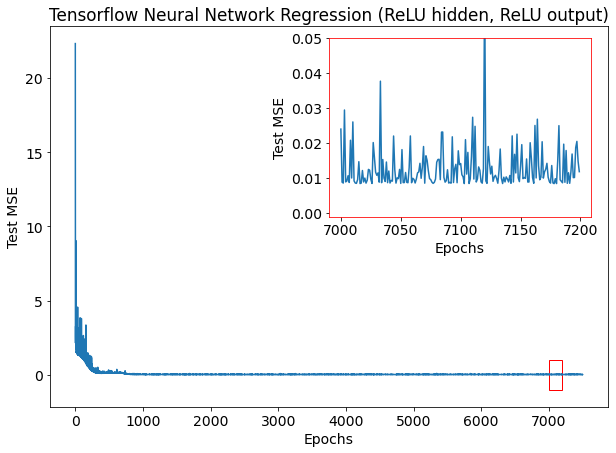

In [147]:
test_loss = train_history.history['val_loss']

plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(figsize=(10,7))

ax.plot(test_loss)
ax.set_ylabel('Test MSE')
ax.set_xlabel('Epochs')
rect = patches.Rectangle((7000, -1), 200, 2, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.set_title('Tensorflow Neural Network Regression (ReLU hidden, ReLU output)')


axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47]);
axins.plot(test_loss[7000:7200])
axins.set_xticklabels(range(6950, 7250, 50));
axins.set_ylabel('Test MSE')
axins.set_xlabel('Epochs')
axins.set_ylim(-0.001, 0.05)
plt.setp(axins.spines.values(), color='red');
fig.savefig('regression_nn_tensorflow.jpg', dpi=1000, bbox_inches='tight')

############################################################################################################################

# Classification

#############################################################################################################################

### From Scratch

In [108]:
breast_cancer = load_breast_cancer()

X, y = breast_cancer.data, breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler() 
scaler.fit(X_train) 
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [109]:
train_data = []
for i in range(X_train_scaled.shape[0]):
    x_arr = X_train_scaled[i,:]
    x_arr = np.reshape(x_arr, (30,1))
    y = y_train[i]
    
    if y == 0:
        y_arr = np.array([1.0, 0.0])
    else:
        y_arr = np.array([0.0, 1.0])

    train_data.append(tuple((x_arr, y_arr)))

test_data = []
for i in range(X_test_scaled.shape[0]):
    x_arr = X_test_scaled[i,:]
    x_arr = np.reshape(x_arr, (30,1))
    y_arr = y_test[i]

    test_data.append(tuple((x_arr, y_arr)))

### relu hidden layer test

In [113]:
activ_funcs = ['relu', 'sigmoid']
net_class = neural_network([30, 5, 2], activ_funcs, 'classification', lmbda=0.0)

data_size = len(train_data)
n_epochs = 200
eta = 0.1

np.random.seed(1)
test_acc_relu = net_class.SGD(train_data, test_data, n_epochs, data_size, eta)

Epoch 0: 0.4649122807017544
Epoch 1: 0.5350877192982456
Epoch 2: 0.6403508771929824
Epoch 3: 0.7543859649122807
Epoch 4: 0.8157894736842105
Epoch 5: 0.8333333333333334
Epoch 6: 0.8508771929824561
Epoch 7: 0.8333333333333334
Epoch 8: 0.8245614035087719
Epoch 9: 0.8245614035087719
Epoch 10: 0.8333333333333334
Epoch 11: 0.8333333333333334
Epoch 12: 0.8421052631578947
Epoch 13: 0.8508771929824561
Epoch 14: 0.8508771929824561
Epoch 15: 0.8508771929824561
Epoch 16: 0.8421052631578947
Epoch 17: 0.8421052631578947
Epoch 18: 0.868421052631579
Epoch 19: 0.8771929824561403
Epoch 20: 0.8859649122807017
Epoch 21: 0.8859649122807017
Epoch 22: 0.8947368421052632
Epoch 23: 0.9035087719298246
Epoch 24: 0.9035087719298246
Epoch 25: 0.9122807017543859
Epoch 26: 0.9122807017543859
Epoch 27: 0.9210526315789473
Epoch 28: 0.9210526315789473
Epoch 29: 0.9210526315789473
Epoch 30: 0.9210526315789473
Epoch 31: 0.9210526315789473
Epoch 32: 0.9210526315789473
Epoch 33: 0.9210526315789473
Epoch 34: 0.9210526315789

In [114]:
print(max(test_acc_relu))

0.9385964912280702


### sigmoid hidden layer test

In [115]:
activ_funcs = ['sigmoid', 'sigmoid']
net_class = neural_network([30, 5, 2], activ_funcs, 'classification', lmbda=0.0)

data_size = len(train_data)
n_epochs = 200
eta = 0.1

np.random.seed(1)
test_acc_sigmoid = net_class.SGD(train_data, test_data, n_epochs, data_size, eta)

Epoch 0: 0.41228070175438597
Epoch 1: 0.39473684210526316
Epoch 2: 0.6140350877192983
Epoch 3: 0.6578947368421053
Epoch 4: 0.6052631578947368
Epoch 5: 0.5964912280701754
Epoch 6: 0.5877192982456141
Epoch 7: 0.5877192982456141
Epoch 8: 0.5877192982456141
Epoch 9: 0.5877192982456141
Epoch 10: 0.5877192982456141
Epoch 11: 0.5877192982456141
Epoch 12: 0.5877192982456141
Epoch 13: 0.5877192982456141
Epoch 14: 0.5877192982456141
Epoch 15: 0.5877192982456141
Epoch 16: 0.5877192982456141
Epoch 17: 0.5877192982456141
Epoch 18: 0.5877192982456141
Epoch 19: 0.5877192982456141
Epoch 20: 0.5877192982456141
Epoch 21: 0.5877192982456141
Epoch 22: 0.5877192982456141
Epoch 23: 0.5877192982456141
Epoch 24: 0.5877192982456141
Epoch 25: 0.5877192982456141
Epoch 26: 0.5877192982456141
Epoch 27: 0.5877192982456141
Epoch 28: 0.5877192982456141
Epoch 29: 0.5877192982456141
Epoch 30: 0.5877192982456141
Epoch 31: 0.5877192982456141
Epoch 32: 0.5877192982456141
Epoch 33: 0.5877192982456141
Epoch 34: 0.5877192982

In [116]:
print(max(test_acc_sigmoid))

0.9473684210526315


### leakyrelu hidden layer test

In [117]:
activ_funcs = ['leaky_relu', 'sigmoid']
net_class = neural_network([30, 5, 2], activ_funcs, 'classification', lmbda=0.0)

data_size = len(train_data)
n_epochs = 200
eta = 0.1

np.random.seed(1)
test_acc_leaky = net_class.SGD(train_data, test_data, n_epochs, data_size, eta)

Epoch 0: 0.5350877192982456
Epoch 1: 0.7280701754385965
Epoch 2: 0.8508771929824561
Epoch 3: 0.8596491228070176
Epoch 4: 0.868421052631579
Epoch 5: 0.8771929824561403
Epoch 6: 0.8771929824561403
Epoch 7: 0.8771929824561403
Epoch 8: 0.8771929824561403
Epoch 9: 0.8771929824561403
Epoch 10: 0.8771929824561403
Epoch 11: 0.8771929824561403
Epoch 12: 0.8771929824561403
Epoch 13: 0.8947368421052632
Epoch 14: 0.8947368421052632
Epoch 15: 0.8947368421052632
Epoch 16: 0.9035087719298246
Epoch 17: 0.8947368421052632
Epoch 18: 0.8947368421052632
Epoch 19: 0.8947368421052632
Epoch 20: 0.8947368421052632
Epoch 21: 0.8947368421052632
Epoch 22: 0.9035087719298246
Epoch 23: 0.9035087719298246
Epoch 24: 0.9035087719298246
Epoch 25: 0.9122807017543859
Epoch 26: 0.9122807017543859
Epoch 27: 0.9122807017543859
Epoch 28: 0.9122807017543859
Epoch 29: 0.9122807017543859
Epoch 30: 0.9122807017543859
Epoch 31: 0.9122807017543859
Epoch 32: 0.9122807017543859
Epoch 33: 0.9122807017543859
Epoch 34: 0.9122807017543

In [121]:
print(max(test_acc_leaky))

0.9210526315789473


### additional hidden layer test (sigmoid sigmoid )

In [88]:
activ_funcs = ['sigmoid', 'sigmoid', 'sigmoid']
net_class = neural_network([30, 5, 5, 2], activ_funcs, 'classification', lmbda=0.0)

data_size = len(train_data)
n_epochs = 200
eta = 0.1

np.random.seed(1)
test_acc_sigmoid = net_class.SGD(train_data, test_data, n_epochs, data_size, eta)

Epoch 0: 0.41228070175438597
Epoch 1: 0.41228070175438597
Epoch 2: 0.41228070175438597
Epoch 3: 0.41228070175438597
Epoch 4: 0.41228070175438597
Epoch 5: 0.41228070175438597
Epoch 6: 0.41228070175438597
Epoch 7: 0.41228070175438597
Epoch 8: 0.5877192982456141
Epoch 9: 0.5877192982456141
Epoch 10: 0.5877192982456141
Epoch 11: 0.5877192982456141
Epoch 12: 0.5877192982456141
Epoch 13: 0.5877192982456141
Epoch 14: 0.5877192982456141
Epoch 15: 0.5877192982456141
Epoch 16: 0.5877192982456141
Epoch 17: 0.5877192982456141
Epoch 18: 0.5877192982456141
Epoch 19: 0.5877192982456141
Epoch 20: 0.5877192982456141
Epoch 21: 0.5877192982456141
Epoch 22: 0.5877192982456141
Epoch 23: 0.5877192982456141
Epoch 24: 0.5877192982456141
Epoch 25: 0.5877192982456141
Epoch 26: 0.5877192982456141
Epoch 27: 0.5877192982456141
Epoch 28: 0.5877192982456141
Epoch 29: 0.5877192982456141
Epoch 30: 0.5877192982456141
Epoch 31: 0.5877192982456141
Epoch 32: 0.5877192982456141
Epoch 33: 0.5877192982456141
Epoch 34: 0.5877

In [118]:
print(max(test_acc_leaky))

0.9210526315789473


### more nodes test (20 instead of 5)

In [119]:
activ_funcs = ['sigmoid', 'sigmoid']
net_class = neural_network([30, 20, 2], activ_funcs, 'classification', lmbda=0.0)

data_size = len(train_data)
n_epochs = 200
eta = 0.1

np.random.seed(1)
test_acc_sigmoid_20 = net_class.SGD(train_data, test_data, n_epochs, data_size, eta)

Epoch 0: 0.5789473684210527
Epoch 1: 0.5877192982456141
Epoch 2: 0.5877192982456141
Epoch 3: 0.5877192982456141
Epoch 4: 0.5877192982456141
Epoch 5: 0.5877192982456141
Epoch 6: 0.5877192982456141
Epoch 7: 0.5877192982456141
Epoch 8: 0.5877192982456141
Epoch 9: 0.5877192982456141
Epoch 10: 0.5877192982456141
Epoch 11: 0.5877192982456141
Epoch 12: 0.5877192982456141
Epoch 13: 0.5877192982456141
Epoch 14: 0.5877192982456141
Epoch 15: 0.5877192982456141
Epoch 16: 0.5877192982456141
Epoch 17: 0.5877192982456141
Epoch 18: 0.5877192982456141
Epoch 19: 0.5877192982456141
Epoch 20: 0.5877192982456141
Epoch 21: 0.5877192982456141
Epoch 22: 0.5877192982456141
Epoch 23: 0.5877192982456141
Epoch 24: 0.5877192982456141
Epoch 25: 0.5877192982456141
Epoch 26: 0.5877192982456141
Epoch 27: 0.5877192982456141
Epoch 28: 0.5877192982456141
Epoch 29: 0.5877192982456141
Epoch 30: 0.5877192982456141
Epoch 31: 0.5877192982456141
Epoch 32: 0.5877192982456141
Epoch 33: 0.5964912280701754
Epoch 34: 0.596491228070

In [120]:
print(max(test_acc_sigmoid_20))

0.956140350877193


### sigmoid seems to do the best, and we will use 20 nodes in the hidden layer. Now we do a grid search over eta and lambda (this takes a couple of minutes to run)

In [94]:
etas = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
lmbdas = np.array([0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])

nn_class_grid = np.zeros((len(etas), len(lmbdas)))
activ_funcs = ['sigmoid', 'sigmoid']                        
for eta,i in zip(etas, range(len(etas))):
    for lmbd,j in zip(lmbdas, range(len(lmbdas))):
        
        net_class = neural_network([30, 20, 2], activ_funcs, 'classification', lmbda=lmbd)
        test_accuracies = net_class.SGD(train_data, test_data, n_epochs, mini_batch_size=data_size, eta=eta)
                        
        final_acc = test_accuracies[-1]
        nn_class_grid[i,j] = final_acc
        
    print(i)

Epoch 0: 0.41228070175438597
Epoch 1: 0.41228070175438597
Epoch 2: 0.41228070175438597
Epoch 3: 0.41228070175438597
Epoch 4: 0.41228070175438597
Epoch 5: 0.41228070175438597
Epoch 6: 0.41228070175438597
Epoch 7: 0.41228070175438597
Epoch 8: 0.41228070175438597
Epoch 9: 0.41228070175438597
Epoch 10: 0.41228070175438597
Epoch 11: 0.41228070175438597
Epoch 12: 0.41228070175438597
Epoch 13: 0.41228070175438597
Epoch 14: 0.41228070175438597
Epoch 15: 0.41228070175438597
Epoch 16: 0.41228070175438597
Epoch 17: 0.41228070175438597
Epoch 18: 0.41228070175438597
Epoch 19: 0.41228070175438597
Epoch 20: 0.41228070175438597
Epoch 21: 0.41228070175438597
Epoch 22: 0.41228070175438597
Epoch 23: 0.41228070175438597
Epoch 24: 0.41228070175438597
Epoch 25: 0.41228070175438597
Epoch 26: 0.41228070175438597
Epoch 27: 0.41228070175438597
Epoch 28: 0.41228070175438597
Epoch 29: 0.41228070175438597
Epoch 30: 0.41228070175438597
Epoch 31: 0.41228070175438597
Epoch 32: 0.41228070175438597
Epoch 33: 0.41228070

Epoch 74: 0.5877192982456141
Epoch 75: 0.5877192982456141
Epoch 76: 0.5877192982456141
Epoch 77: 0.5877192982456141
Epoch 78: 0.5877192982456141
Epoch 79: 0.5877192982456141
Epoch 80: 0.5877192982456141
Epoch 81: 0.5877192982456141
Epoch 82: 0.5877192982456141
Epoch 83: 0.5877192982456141
Epoch 84: 0.5877192982456141
Epoch 85: 0.5877192982456141
Epoch 86: 0.5877192982456141
Epoch 87: 0.5877192982456141
Epoch 88: 0.5877192982456141
Epoch 89: 0.5877192982456141
Epoch 90: 0.5877192982456141
Epoch 91: 0.5877192982456141
Epoch 92: 0.5877192982456141
Epoch 93: 0.5877192982456141
Epoch 94: 0.5877192982456141
Epoch 95: 0.5877192982456141
Epoch 96: 0.5877192982456141
Epoch 97: 0.5877192982456141
Epoch 98: 0.5877192982456141
Epoch 99: 0.5877192982456141
Epoch 100: 0.5877192982456141
Epoch 101: 0.5877192982456141
Epoch 102: 0.5877192982456141
Epoch 103: 0.5877192982456141
Epoch 104: 0.5877192982456141
Epoch 105: 0.5877192982456141
Epoch 106: 0.5877192982456141
Epoch 107: 0.5877192982456141
Epoch 

Epoch 149: 0.41228070175438597
Epoch 150: 0.41228070175438597
Epoch 151: 0.41228070175438597
Epoch 152: 0.41228070175438597
Epoch 153: 0.41228070175438597
Epoch 154: 0.41228070175438597
Epoch 155: 0.41228070175438597
Epoch 156: 0.41228070175438597
Epoch 157: 0.41228070175438597
Epoch 158: 0.41228070175438597
Epoch 159: 0.41228070175438597
Epoch 160: 0.41228070175438597
Epoch 161: 0.41228070175438597
Epoch 162: 0.41228070175438597
Epoch 163: 0.41228070175438597
Epoch 164: 0.41228070175438597
Epoch 165: 0.41228070175438597
Epoch 166: 0.41228070175438597
Epoch 167: 0.41228070175438597
Epoch 168: 0.41228070175438597
Epoch 169: 0.41228070175438597
Epoch 170: 0.41228070175438597
Epoch 171: 0.41228070175438597
Epoch 172: 0.41228070175438597
Epoch 173: 0.41228070175438597
Epoch 174: 0.41228070175438597
Epoch 175: 0.41228070175438597
Epoch 176: 0.41228070175438597
Epoch 177: 0.41228070175438597
Epoch 178: 0.41228070175438597
Epoch 179: 0.41228070175438597
Epoch 180: 0.41228070175438597
Epoch 18

Epoch 23: 0.5877192982456141
Epoch 24: 0.5877192982456141
Epoch 25: 0.5877192982456141
Epoch 26: 0.5877192982456141
Epoch 27: 0.5877192982456141
Epoch 28: 0.5877192982456141
Epoch 29: 0.5877192982456141
Epoch 30: 0.5877192982456141
Epoch 31: 0.5877192982456141
Epoch 32: 0.5877192982456141
Epoch 33: 0.5877192982456141
Epoch 34: 0.5877192982456141
Epoch 35: 0.5877192982456141
Epoch 36: 0.5877192982456141
Epoch 37: 0.5877192982456141
Epoch 38: 0.5877192982456141
Epoch 39: 0.5877192982456141
Epoch 40: 0.5877192982456141
Epoch 41: 0.5877192982456141
Epoch 42: 0.5877192982456141
Epoch 43: 0.5877192982456141
Epoch 44: 0.5877192982456141
Epoch 45: 0.5877192982456141
Epoch 46: 0.5877192982456141
Epoch 47: 0.5877192982456141
Epoch 48: 0.5877192982456141
Epoch 49: 0.5877192982456141
Epoch 50: 0.5877192982456141
Epoch 51: 0.5877192982456141
Epoch 52: 0.5877192982456141
Epoch 53: 0.5877192982456141
Epoch 54: 0.5877192982456141
Epoch 55: 0.5877192982456141
Epoch 56: 0.5877192982456141
Epoch 57: 0.58

Epoch 103: 0.5877192982456141
Epoch 104: 0.5877192982456141
Epoch 105: 0.5877192982456141
Epoch 106: 0.5877192982456141
Epoch 107: 0.5877192982456141
Epoch 108: 0.5877192982456141
Epoch 109: 0.5877192982456141
Epoch 110: 0.5877192982456141
Epoch 111: 0.5877192982456141
Epoch 112: 0.5877192982456141
Epoch 113: 0.5877192982456141
Epoch 114: 0.5877192982456141
Epoch 115: 0.5877192982456141
Epoch 116: 0.5877192982456141
Epoch 117: 0.5877192982456141
Epoch 118: 0.5877192982456141
Epoch 119: 0.5877192982456141
Epoch 120: 0.5877192982456141
Epoch 121: 0.5877192982456141
Epoch 122: 0.5877192982456141
Epoch 123: 0.5877192982456141
Epoch 124: 0.5877192982456141
Epoch 125: 0.5877192982456141
Epoch 126: 0.5877192982456141
Epoch 127: 0.5877192982456141
Epoch 128: 0.5877192982456141
Epoch 129: 0.5877192982456141
Epoch 130: 0.5877192982456141
Epoch 131: 0.5877192982456141
Epoch 132: 0.5877192982456141
Epoch 133: 0.5877192982456141
Epoch 134: 0.5877192982456141
Epoch 135: 0.5877192982456141
Epoch 136:

Epoch 182: 0.5877192982456141
Epoch 183: 0.5877192982456141
Epoch 184: 0.5877192982456141
Epoch 185: 0.5877192982456141
Epoch 186: 0.5877192982456141
Epoch 187: 0.5877192982456141
Epoch 188: 0.5877192982456141
Epoch 189: 0.5877192982456141
Epoch 190: 0.5877192982456141
Epoch 191: 0.5877192982456141
Epoch 192: 0.5877192982456141
Epoch 193: 0.5877192982456141
Epoch 194: 0.5877192982456141
Epoch 195: 0.5877192982456141
Epoch 196: 0.5877192982456141
Epoch 197: 0.5877192982456141
Epoch 198: 0.5877192982456141
Epoch 199: 0.5877192982456141
0
Epoch 0: 0.2719298245614035
Epoch 1: 0.2719298245614035
Epoch 2: 0.2719298245614035
Epoch 3: 0.2719298245614035
Epoch 4: 0.2719298245614035
Epoch 5: 0.2719298245614035
Epoch 6: 0.2719298245614035
Epoch 7: 0.2719298245614035
Epoch 8: 0.2719298245614035
Epoch 9: 0.2719298245614035
Epoch 10: 0.2719298245614035
Epoch 11: 0.2719298245614035
Epoch 12: 0.2719298245614035
Epoch 13: 0.2719298245614035
Epoch 14: 0.2719298245614035
Epoch 15: 0.2719298245614035
Epoc

Epoch 62: 0.42105263157894735
Epoch 63: 0.42105263157894735
Epoch 64: 0.42105263157894735
Epoch 65: 0.42105263157894735
Epoch 66: 0.42105263157894735
Epoch 67: 0.42105263157894735
Epoch 68: 0.42105263157894735
Epoch 69: 0.42105263157894735
Epoch 70: 0.42105263157894735
Epoch 71: 0.42105263157894735
Epoch 72: 0.42105263157894735
Epoch 73: 0.42105263157894735
Epoch 74: 0.42105263157894735
Epoch 75: 0.42105263157894735
Epoch 76: 0.42105263157894735
Epoch 77: 0.42105263157894735
Epoch 78: 0.42105263157894735
Epoch 79: 0.42105263157894735
Epoch 80: 0.42105263157894735
Epoch 81: 0.42105263157894735
Epoch 82: 0.42105263157894735
Epoch 83: 0.42105263157894735
Epoch 84: 0.42105263157894735
Epoch 85: 0.42105263157894735
Epoch 86: 0.42105263157894735
Epoch 87: 0.42105263157894735
Epoch 88: 0.42105263157894735
Epoch 89: 0.42105263157894735
Epoch 90: 0.42105263157894735
Epoch 91: 0.42105263157894735
Epoch 92: 0.42105263157894735
Epoch 93: 0.42105263157894735
Epoch 94: 0.4298245614035088
Epoch 95: 0

Epoch 138: 0.39473684210526316
Epoch 139: 0.39473684210526316
Epoch 140: 0.39473684210526316
Epoch 141: 0.39473684210526316
Epoch 142: 0.39473684210526316
Epoch 143: 0.39473684210526316
Epoch 144: 0.39473684210526316
Epoch 145: 0.39473684210526316
Epoch 146: 0.39473684210526316
Epoch 147: 0.39473684210526316
Epoch 148: 0.39473684210526316
Epoch 149: 0.39473684210526316
Epoch 150: 0.39473684210526316
Epoch 151: 0.39473684210526316
Epoch 152: 0.39473684210526316
Epoch 153: 0.39473684210526316
Epoch 154: 0.39473684210526316
Epoch 155: 0.39473684210526316
Epoch 156: 0.39473684210526316
Epoch 157: 0.38596491228070173
Epoch 158: 0.38596491228070173
Epoch 159: 0.38596491228070173
Epoch 160: 0.38596491228070173
Epoch 161: 0.38596491228070173
Epoch 162: 0.38596491228070173
Epoch 163: 0.38596491228070173
Epoch 164: 0.38596491228070173
Epoch 165: 0.38596491228070173
Epoch 166: 0.38596491228070173
Epoch 167: 0.38596491228070173
Epoch 168: 0.38596491228070173
Epoch 169: 0.38596491228070173
Epoch 17

Epoch 11: 0.38596491228070173
Epoch 12: 0.37719298245614036
Epoch 13: 0.37719298245614036
Epoch 14: 0.3684210526315789
Epoch 15: 0.38596491228070173
Epoch 16: 0.38596491228070173
Epoch 17: 0.38596491228070173
Epoch 18: 0.38596491228070173
Epoch 19: 0.38596491228070173
Epoch 20: 0.38596491228070173
Epoch 21: 0.38596491228070173
Epoch 22: 0.39473684210526316
Epoch 23: 0.39473684210526316
Epoch 24: 0.39473684210526316
Epoch 25: 0.39473684210526316
Epoch 26: 0.39473684210526316
Epoch 27: 0.39473684210526316
Epoch 28: 0.40350877192982454
Epoch 29: 0.40350877192982454
Epoch 30: 0.40350877192982454
Epoch 31: 0.40350877192982454
Epoch 32: 0.39473684210526316
Epoch 33: 0.39473684210526316
Epoch 34: 0.39473684210526316
Epoch 35: 0.39473684210526316
Epoch 36: 0.39473684210526316
Epoch 37: 0.39473684210526316
Epoch 38: 0.39473684210526316
Epoch 39: 0.39473684210526316
Epoch 40: 0.39473684210526316
Epoch 41: 0.39473684210526316
Epoch 42: 0.39473684210526316
Epoch 43: 0.38596491228070173
Epoch 44: 0

Epoch 84: 0.5877192982456141
Epoch 85: 0.5877192982456141
Epoch 86: 0.5877192982456141
Epoch 87: 0.5877192982456141
Epoch 88: 0.5877192982456141
Epoch 89: 0.5877192982456141
Epoch 90: 0.5877192982456141
Epoch 91: 0.5877192982456141
Epoch 92: 0.5877192982456141
Epoch 93: 0.5877192982456141
Epoch 94: 0.5877192982456141
Epoch 95: 0.5877192982456141
Epoch 96: 0.5877192982456141
Epoch 97: 0.5877192982456141
Epoch 98: 0.5877192982456141
Epoch 99: 0.5877192982456141
Epoch 100: 0.5877192982456141
Epoch 101: 0.5877192982456141
Epoch 102: 0.5877192982456141
Epoch 103: 0.5877192982456141
Epoch 104: 0.5877192982456141
Epoch 105: 0.5877192982456141
Epoch 106: 0.5877192982456141
Epoch 107: 0.5877192982456141
Epoch 108: 0.5877192982456141
Epoch 109: 0.5877192982456141
Epoch 110: 0.5877192982456141
Epoch 111: 0.5877192982456141
Epoch 112: 0.5877192982456141
Epoch 113: 0.5877192982456141
Epoch 114: 0.5877192982456141
Epoch 115: 0.5877192982456141
Epoch 116: 0.5877192982456141
Epoch 117: 0.5877192982456

Epoch 165: 0.5877192982456141
Epoch 166: 0.5877192982456141
Epoch 167: 0.5877192982456141
Epoch 168: 0.5877192982456141
Epoch 169: 0.5877192982456141
Epoch 170: 0.5877192982456141
Epoch 171: 0.5877192982456141
Epoch 172: 0.5877192982456141
Epoch 173: 0.5877192982456141
Epoch 174: 0.5877192982456141
Epoch 175: 0.5877192982456141
Epoch 176: 0.5877192982456141
Epoch 177: 0.5877192982456141
Epoch 178: 0.5877192982456141
Epoch 179: 0.5877192982456141
Epoch 180: 0.5877192982456141
Epoch 181: 0.5877192982456141
Epoch 182: 0.5877192982456141
Epoch 183: 0.5877192982456141
Epoch 184: 0.5877192982456141
Epoch 185: 0.5877192982456141
Epoch 186: 0.5877192982456141
Epoch 187: 0.5877192982456141
Epoch 188: 0.5877192982456141
Epoch 189: 0.5877192982456141
Epoch 190: 0.5877192982456141
Epoch 191: 0.5877192982456141
Epoch 192: 0.5877192982456141
Epoch 193: 0.5877192982456141
Epoch 194: 0.5877192982456141
Epoch 195: 0.5877192982456141
Epoch 196: 0.5877192982456141
Epoch 197: 0.5877192982456141
Epoch 198:

Epoch 36: 0.41228070175438597
Epoch 37: 0.41228070175438597
Epoch 38: 0.41228070175438597
Epoch 39: 0.41228070175438597
Epoch 40: 0.41228070175438597
Epoch 41: 0.41228070175438597
Epoch 42: 0.41228070175438597
Epoch 43: 0.41228070175438597
Epoch 44: 0.41228070175438597
Epoch 45: 0.41228070175438597
Epoch 46: 0.41228070175438597
Epoch 47: 0.41228070175438597
Epoch 48: 0.41228070175438597
Epoch 49: 0.41228070175438597
Epoch 50: 0.41228070175438597
Epoch 51: 0.41228070175438597
Epoch 52: 0.41228070175438597
Epoch 53: 0.41228070175438597
Epoch 54: 0.41228070175438597
Epoch 55: 0.41228070175438597
Epoch 56: 0.41228070175438597
Epoch 57: 0.41228070175438597
Epoch 58: 0.41228070175438597
Epoch 59: 0.41228070175438597
Epoch 60: 0.41228070175438597
Epoch 61: 0.41228070175438597
Epoch 62: 0.41228070175438597
Epoch 63: 0.41228070175438597
Epoch 64: 0.41228070175438597
Epoch 65: 0.41228070175438597
Epoch 66: 0.41228070175438597
Epoch 67: 0.41228070175438597
Epoch 68: 0.41228070175438597
Epoch 69: 

Epoch 115: 0.41228070175438597
Epoch 116: 0.41228070175438597
Epoch 117: 0.41228070175438597
Epoch 118: 0.41228070175438597
Epoch 119: 0.41228070175438597
Epoch 120: 0.41228070175438597
Epoch 121: 0.41228070175438597
Epoch 122: 0.41228070175438597
Epoch 123: 0.41228070175438597
Epoch 124: 0.41228070175438597
Epoch 125: 0.41228070175438597
Epoch 126: 0.41228070175438597
Epoch 127: 0.41228070175438597
Epoch 128: 0.41228070175438597
Epoch 129: 0.41228070175438597
Epoch 130: 0.41228070175438597
Epoch 131: 0.41228070175438597
Epoch 132: 0.41228070175438597
Epoch 133: 0.41228070175438597
Epoch 134: 0.41228070175438597
Epoch 135: 0.41228070175438597
Epoch 136: 0.41228070175438597
Epoch 137: 0.41228070175438597
Epoch 138: 0.41228070175438597
Epoch 139: 0.41228070175438597
Epoch 140: 0.41228070175438597
Epoch 141: 0.41228070175438597
Epoch 142: 0.41228070175438597
Epoch 143: 0.41228070175438597
Epoch 144: 0.41228070175438597
Epoch 145: 0.41228070175438597
Epoch 146: 0.41228070175438597
Epoch 14

Epoch 193: 0.5964912280701754
Epoch 194: 0.5964912280701754
Epoch 195: 0.5964912280701754
Epoch 196: 0.5964912280701754
Epoch 197: 0.5964912280701754
Epoch 198: 0.5964912280701754
Epoch 199: 0.5964912280701754
Epoch 0: 0.5877192982456141
Epoch 1: 0.5877192982456141
Epoch 2: 0.5877192982456141
Epoch 3: 0.5877192982456141
Epoch 4: 0.5877192982456141
Epoch 5: 0.5877192982456141
Epoch 6: 0.5877192982456141
Epoch 7: 0.5877192982456141
Epoch 8: 0.5877192982456141
Epoch 9: 0.5877192982456141
Epoch 10: 0.5877192982456141
Epoch 11: 0.5877192982456141
Epoch 12: 0.5877192982456141
Epoch 13: 0.5877192982456141
Epoch 14: 0.5877192982456141
Epoch 15: 0.5877192982456141
Epoch 16: 0.5877192982456141
Epoch 17: 0.5877192982456141
Epoch 18: 0.5877192982456141
Epoch 19: 0.5877192982456141
Epoch 20: 0.5877192982456141
Epoch 21: 0.5877192982456141
Epoch 22: 0.5877192982456141
Epoch 23: 0.5877192982456141
Epoch 24: 0.5877192982456141
Epoch 25: 0.5877192982456141
Epoch 26: 0.5877192982456141
Epoch 27: 0.58771

Epoch 77: 0.5877192982456141
Epoch 78: 0.5877192982456141
Epoch 79: 0.5877192982456141
Epoch 80: 0.5877192982456141
Epoch 81: 0.5877192982456141
Epoch 82: 0.5877192982456141
Epoch 83: 0.5877192982456141
Epoch 84: 0.5877192982456141
Epoch 85: 0.5877192982456141
Epoch 86: 0.5877192982456141
Epoch 87: 0.5877192982456141
Epoch 88: 0.5877192982456141
Epoch 89: 0.5877192982456141
Epoch 90: 0.5877192982456141
Epoch 91: 0.5877192982456141
Epoch 92: 0.5877192982456141
Epoch 93: 0.5877192982456141
Epoch 94: 0.5877192982456141
Epoch 95: 0.5877192982456141
Epoch 96: 0.5877192982456141
Epoch 97: 0.5877192982456141
Epoch 98: 0.5877192982456141
Epoch 99: 0.5877192982456141
Epoch 100: 0.5877192982456141
Epoch 101: 0.5877192982456141
Epoch 102: 0.5877192982456141
Epoch 103: 0.5877192982456141
Epoch 104: 0.5877192982456141
Epoch 105: 0.5877192982456141
Epoch 106: 0.5877192982456141
Epoch 107: 0.5877192982456141
Epoch 108: 0.5877192982456141
Epoch 109: 0.5877192982456141
Epoch 110: 0.5877192982456141
Epo

Epoch 159: 0.5877192982456141
Epoch 160: 0.5877192982456141
Epoch 161: 0.5877192982456141
Epoch 162: 0.5877192982456141
Epoch 163: 0.5877192982456141
Epoch 164: 0.5877192982456141
Epoch 165: 0.5877192982456141
Epoch 166: 0.5877192982456141
Epoch 167: 0.5877192982456141
Epoch 168: 0.5877192982456141
Epoch 169: 0.5877192982456141
Epoch 170: 0.5877192982456141
Epoch 171: 0.5877192982456141
Epoch 172: 0.5877192982456141
Epoch 173: 0.5877192982456141
Epoch 174: 0.5877192982456141
Epoch 175: 0.5877192982456141
Epoch 176: 0.5877192982456141
Epoch 177: 0.5877192982456141
Epoch 178: 0.5877192982456141
Epoch 179: 0.5877192982456141
Epoch 180: 0.5877192982456141
Epoch 181: 0.5877192982456141
Epoch 182: 0.5877192982456141
Epoch 183: 0.5877192982456141
Epoch 184: 0.5877192982456141
Epoch 185: 0.5877192982456141
Epoch 186: 0.5877192982456141
Epoch 187: 0.5877192982456141
Epoch 188: 0.5877192982456141
Epoch 189: 0.5877192982456141
Epoch 190: 0.5877192982456141
Epoch 191: 0.5877192982456141
Epoch 192:

Epoch 39: 0.7192982456140351
Epoch 40: 0.7192982456140351
Epoch 41: 0.7192982456140351
Epoch 42: 0.7105263157894737
Epoch 43: 0.7105263157894737
Epoch 44: 0.7105263157894737
Epoch 45: 0.7105263157894737
Epoch 46: 0.7017543859649122
Epoch 47: 0.7017543859649122
Epoch 48: 0.7017543859649122
Epoch 49: 0.7017543859649122
Epoch 50: 0.6929824561403509
Epoch 51: 0.6929824561403509
Epoch 52: 0.6842105263157895
Epoch 53: 0.6842105263157895
Epoch 54: 0.6754385964912281
Epoch 55: 0.6754385964912281
Epoch 56: 0.6754385964912281
Epoch 57: 0.6754385964912281
Epoch 58: 0.6754385964912281
Epoch 59: 0.6754385964912281
Epoch 60: 0.6666666666666666
Epoch 61: 0.6578947368421053
Epoch 62: 0.6491228070175439
Epoch 63: 0.6491228070175439
Epoch 64: 0.6491228070175439
Epoch 65: 0.6491228070175439
Epoch 66: 0.6403508771929824
Epoch 67: 0.6403508771929824
Epoch 68: 0.631578947368421
Epoch 69: 0.631578947368421
Epoch 70: 0.631578947368421
Epoch 71: 0.631578947368421
Epoch 72: 0.631578947368421
Epoch 73: 0.6315789

Epoch 119: 0.5877192982456141
Epoch 120: 0.5877192982456141
Epoch 121: 0.5877192982456141
Epoch 122: 0.5877192982456141
Epoch 123: 0.5877192982456141
Epoch 124: 0.5877192982456141
Epoch 125: 0.5877192982456141
Epoch 126: 0.5877192982456141
Epoch 127: 0.5877192982456141
Epoch 128: 0.5877192982456141
Epoch 129: 0.5877192982456141
Epoch 130: 0.5877192982456141
Epoch 131: 0.5877192982456141
Epoch 132: 0.5877192982456141
Epoch 133: 0.5877192982456141
Epoch 134: 0.5877192982456141
Epoch 135: 0.5877192982456141
Epoch 136: 0.5877192982456141
Epoch 137: 0.5877192982456141
Epoch 138: 0.5877192982456141
Epoch 139: 0.5877192982456141
Epoch 140: 0.5877192982456141
Epoch 141: 0.5877192982456141
Epoch 142: 0.5877192982456141
Epoch 143: 0.5877192982456141
Epoch 144: 0.5877192982456141
Epoch 145: 0.5877192982456141
Epoch 146: 0.5877192982456141
Epoch 147: 0.5877192982456141
Epoch 148: 0.5877192982456141
Epoch 149: 0.5877192982456141
Epoch 150: 0.5877192982456141
Epoch 151: 0.5877192982456141
Epoch 152:

Epoch 199: 0.5877192982456141
Epoch 0: 0.5877192982456141
Epoch 1: 0.5877192982456141
Epoch 2: 0.5877192982456141
Epoch 3: 0.5877192982456141
Epoch 4: 0.5877192982456141
Epoch 5: 0.5877192982456141
Epoch 6: 0.5877192982456141
Epoch 7: 0.5877192982456141
Epoch 8: 0.5877192982456141
Epoch 9: 0.5877192982456141
Epoch 10: 0.5877192982456141
Epoch 11: 0.5877192982456141
Epoch 12: 0.5877192982456141
Epoch 13: 0.5877192982456141
Epoch 14: 0.5877192982456141
Epoch 15: 0.5877192982456141
Epoch 16: 0.5877192982456141
Epoch 17: 0.5877192982456141
Epoch 18: 0.5877192982456141
Epoch 19: 0.5877192982456141
Epoch 20: 0.5877192982456141
Epoch 21: 0.5877192982456141
Epoch 22: 0.5877192982456141
Epoch 23: 0.5877192982456141
Epoch 24: 0.5877192982456141
Epoch 25: 0.5877192982456141
Epoch 26: 0.5877192982456141
Epoch 27: 0.5877192982456141
Epoch 28: 0.5877192982456141
Epoch 29: 0.5877192982456141
Epoch 30: 0.5877192982456141
Epoch 31: 0.5877192982456141
Epoch 32: 0.5877192982456141
Epoch 33: 0.58771929824

Epoch 83: 0.5877192982456141
Epoch 84: 0.5877192982456141
Epoch 85: 0.5877192982456141
Epoch 86: 0.5877192982456141
Epoch 87: 0.5877192982456141
Epoch 88: 0.5877192982456141
Epoch 89: 0.5877192982456141
Epoch 90: 0.5877192982456141
Epoch 91: 0.5877192982456141
Epoch 92: 0.5877192982456141
Epoch 93: 0.5877192982456141
Epoch 94: 0.5877192982456141
Epoch 95: 0.5877192982456141
Epoch 96: 0.5877192982456141
Epoch 97: 0.5877192982456141
Epoch 98: 0.5877192982456141
Epoch 99: 0.5877192982456141
Epoch 100: 0.5877192982456141
Epoch 101: 0.5877192982456141
Epoch 102: 0.5877192982456141
Epoch 103: 0.5877192982456141
Epoch 104: 0.5877192982456141
Epoch 105: 0.5877192982456141
Epoch 106: 0.5877192982456141
Epoch 107: 0.5877192982456141
Epoch 108: 0.5877192982456141
Epoch 109: 0.5877192982456141
Epoch 110: 0.5877192982456141
Epoch 111: 0.5877192982456141
Epoch 112: 0.5877192982456141
Epoch 113: 0.5877192982456141
Epoch 114: 0.5877192982456141
Epoch 115: 0.5877192982456141
Epoch 116: 0.58771929824561

Epoch 162: 0.5877192982456141
Epoch 163: 0.5877192982456141
Epoch 164: 0.5877192982456141
Epoch 165: 0.5877192982456141
Epoch 166: 0.5877192982456141
Epoch 167: 0.5877192982456141
Epoch 168: 0.5877192982456141
Epoch 169: 0.5877192982456141
Epoch 170: 0.5877192982456141
Epoch 171: 0.5877192982456141
Epoch 172: 0.5877192982456141
Epoch 173: 0.5877192982456141
Epoch 174: 0.5877192982456141
Epoch 175: 0.5877192982456141
Epoch 176: 0.5877192982456141
Epoch 177: 0.5877192982456141
Epoch 178: 0.5877192982456141
Epoch 179: 0.5877192982456141
Epoch 180: 0.5877192982456141
Epoch 181: 0.5877192982456141
Epoch 182: 0.5877192982456141
Epoch 183: 0.5877192982456141
Epoch 184: 0.5877192982456141
Epoch 185: 0.5877192982456141
Epoch 186: 0.5877192982456141
Epoch 187: 0.5877192982456141
Epoch 188: 0.5877192982456141
Epoch 189: 0.5877192982456141
Epoch 190: 0.5877192982456141
Epoch 191: 0.5877192982456141
Epoch 192: 0.5877192982456141
Epoch 193: 0.5877192982456141
Epoch 194: 0.5877192982456141
Epoch 195:

Epoch 41: 0.6052631578947368
Epoch 42: 0.6052631578947368
Epoch 43: 0.6052631578947368
Epoch 44: 0.6140350877192983
Epoch 45: 0.6140350877192983
Epoch 46: 0.6140350877192983
Epoch 47: 0.6140350877192983
Epoch 48: 0.6140350877192983
Epoch 49: 0.631578947368421
Epoch 50: 0.631578947368421
Epoch 51: 0.631578947368421
Epoch 52: 0.6403508771929824
Epoch 53: 0.6491228070175439
Epoch 54: 0.6491228070175439
Epoch 55: 0.6491228070175439
Epoch 56: 0.6666666666666666
Epoch 57: 0.6842105263157895
Epoch 58: 0.6929824561403509
Epoch 59: 0.6929824561403509
Epoch 60: 0.6929824561403509
Epoch 61: 0.6929824561403509
Epoch 62: 0.7017543859649122
Epoch 63: 0.7368421052631579
Epoch 64: 0.7368421052631579
Epoch 65: 0.7368421052631579
Epoch 66: 0.7368421052631579
Epoch 67: 0.7368421052631579
Epoch 68: 0.7456140350877193
Epoch 69: 0.7543859649122807
Epoch 70: 0.7543859649122807
Epoch 71: 0.7543859649122807
Epoch 72: 0.7631578947368421
Epoch 73: 0.7719298245614035
Epoch 74: 0.7807017543859649
Epoch 75: 0.78947

Epoch 129: 0.956140350877193
Epoch 130: 0.956140350877193
Epoch 131: 0.956140350877193
Epoch 132: 0.956140350877193
Epoch 133: 0.956140350877193
Epoch 134: 0.956140350877193
Epoch 135: 0.956140350877193
Epoch 136: 0.956140350877193
Epoch 137: 0.956140350877193
Epoch 138: 0.956140350877193
Epoch 139: 0.956140350877193
Epoch 140: 0.956140350877193
Epoch 141: 0.956140350877193
Epoch 142: 0.956140350877193
Epoch 143: 0.956140350877193
Epoch 144: 0.956140350877193
Epoch 145: 0.956140350877193
Epoch 146: 0.956140350877193
Epoch 147: 0.956140350877193
Epoch 148: 0.956140350877193
Epoch 149: 0.956140350877193
Epoch 150: 0.956140350877193
Epoch 151: 0.956140350877193
Epoch 152: 0.956140350877193
Epoch 153: 0.956140350877193
Epoch 154: 0.956140350877193
Epoch 155: 0.956140350877193
Epoch 156: 0.956140350877193
Epoch 157: 0.956140350877193
Epoch 158: 0.956140350877193
Epoch 159: 0.956140350877193
Epoch 160: 0.956140350877193
Epoch 161: 0.956140350877193
Epoch 162: 0.956140350877193
Epoch 163: 0.9

Epoch 11: 0.5877192982456141
Epoch 12: 0.5877192982456141
Epoch 13: 0.5877192982456141
Epoch 14: 0.5877192982456141
Epoch 15: 0.5877192982456141
Epoch 16: 0.5877192982456141
Epoch 17: 0.5877192982456141
Epoch 18: 0.5877192982456141
Epoch 19: 0.5877192982456141
Epoch 20: 0.5877192982456141
Epoch 21: 0.5877192982456141
Epoch 22: 0.5877192982456141
Epoch 23: 0.5877192982456141
Epoch 24: 0.5877192982456141
Epoch 25: 0.5877192982456141
Epoch 26: 0.5877192982456141
Epoch 27: 0.5877192982456141
Epoch 28: 0.5877192982456141
Epoch 29: 0.5877192982456141
Epoch 30: 0.5877192982456141
Epoch 31: 0.5877192982456141
Epoch 32: 0.5877192982456141
Epoch 33: 0.5877192982456141
Epoch 34: 0.5877192982456141
Epoch 35: 0.5877192982456141
Epoch 36: 0.5877192982456141
Epoch 37: 0.5877192982456141
Epoch 38: 0.5877192982456141
Epoch 39: 0.5877192982456141
Epoch 40: 0.5877192982456141
Epoch 41: 0.5877192982456141
Epoch 42: 0.5877192982456141
Epoch 43: 0.5877192982456141
Epoch 44: 0.5877192982456141
Epoch 45: 0.58

Epoch 100: 0.5877192982456141
Epoch 101: 0.5877192982456141
Epoch 102: 0.5877192982456141
Epoch 103: 0.5877192982456141
Epoch 104: 0.5877192982456141
Epoch 105: 0.5877192982456141
Epoch 106: 0.5877192982456141
Epoch 107: 0.5877192982456141
Epoch 108: 0.5877192982456141
Epoch 109: 0.5877192982456141
Epoch 110: 0.5877192982456141
Epoch 111: 0.5877192982456141
Epoch 112: 0.5877192982456141
Epoch 113: 0.5877192982456141
Epoch 114: 0.5877192982456141
Epoch 115: 0.5877192982456141
Epoch 116: 0.5877192982456141
Epoch 117: 0.5877192982456141
Epoch 118: 0.5877192982456141
Epoch 119: 0.5877192982456141
Epoch 120: 0.5877192982456141
Epoch 121: 0.5877192982456141
Epoch 122: 0.5877192982456141
Epoch 123: 0.5877192982456141
Epoch 124: 0.5877192982456141
Epoch 125: 0.5877192982456141
Epoch 126: 0.5877192982456141
Epoch 127: 0.5877192982456141
Epoch 128: 0.5877192982456141
Epoch 129: 0.5877192982456141
Epoch 130: 0.5877192982456141
Epoch 131: 0.5877192982456141
Epoch 132: 0.5877192982456141
Epoch 133:

Epoch 182: 0.5877192982456141
Epoch 183: 0.5877192982456141
Epoch 184: 0.5877192982456141
Epoch 185: 0.5877192982456141
Epoch 186: 0.5877192982456141
Epoch 187: 0.5877192982456141
Epoch 188: 0.5877192982456141
Epoch 189: 0.5877192982456141
Epoch 190: 0.5877192982456141
Epoch 191: 0.5877192982456141
Epoch 192: 0.5877192982456141
Epoch 193: 0.5877192982456141
Epoch 194: 0.5877192982456141
Epoch 195: 0.5877192982456141
Epoch 196: 0.5877192982456141
Epoch 197: 0.5877192982456141
Epoch 198: 0.5877192982456141
Epoch 199: 0.5877192982456141
4
Epoch 0: 0.5877192982456141
Epoch 1: 0.5877192982456141
Epoch 2: 0.5877192982456141
Epoch 3: 0.5877192982456141
Epoch 4: 0.5877192982456141
Epoch 5: 0.5877192982456141
Epoch 6: 0.5964912280701754
Epoch 7: 0.6140350877192983
Epoch 8: 0.6754385964912281
Epoch 9: 0.7192982456140351
Epoch 10: 0.7894736842105263
Epoch 11: 0.8157894736842105
Epoch 12: 0.868421052631579
Epoch 13: 0.9035087719298246
Epoch 14: 0.9210526315789473
Epoch 15: 0.9473684210526315
Epoch

Epoch 68: 0.9736842105263158
Epoch 69: 0.9736842105263158
Epoch 70: 0.9736842105263158
Epoch 71: 0.9736842105263158
Epoch 72: 0.9736842105263158
Epoch 73: 0.9736842105263158
Epoch 74: 0.9736842105263158
Epoch 75: 0.9736842105263158
Epoch 76: 0.9736842105263158
Epoch 77: 0.9736842105263158
Epoch 78: 0.9736842105263158
Epoch 79: 0.9736842105263158
Epoch 80: 0.9736842105263158
Epoch 81: 0.9736842105263158
Epoch 82: 0.9736842105263158
Epoch 83: 0.9736842105263158
Epoch 84: 0.9736842105263158
Epoch 85: 0.9736842105263158
Epoch 86: 0.9736842105263158
Epoch 87: 0.9736842105263158
Epoch 88: 0.9736842105263158
Epoch 89: 0.9736842105263158
Epoch 90: 0.9649122807017544
Epoch 91: 0.9649122807017544
Epoch 92: 0.9649122807017544
Epoch 93: 0.9649122807017544
Epoch 94: 0.9649122807017544
Epoch 95: 0.9649122807017544
Epoch 96: 0.9649122807017544
Epoch 97: 0.9649122807017544
Epoch 98: 0.9649122807017544
Epoch 99: 0.9649122807017544
Epoch 100: 0.9649122807017544
Epoch 101: 0.9649122807017544
Epoch 102: 0

Epoch 154: 0.9649122807017544
Epoch 155: 0.9649122807017544
Epoch 156: 0.9649122807017544
Epoch 157: 0.9649122807017544
Epoch 158: 0.9649122807017544
Epoch 159: 0.9649122807017544
Epoch 160: 0.9649122807017544
Epoch 161: 0.9649122807017544
Epoch 162: 0.9649122807017544
Epoch 163: 0.9649122807017544
Epoch 164: 0.9649122807017544
Epoch 165: 0.9649122807017544
Epoch 166: 0.9649122807017544
Epoch 167: 0.9649122807017544
Epoch 168: 0.9649122807017544
Epoch 169: 0.9649122807017544
Epoch 170: 0.9649122807017544
Epoch 171: 0.9649122807017544
Epoch 172: 0.9649122807017544
Epoch 173: 0.9649122807017544
Epoch 174: 0.9649122807017544
Epoch 175: 0.9649122807017544
Epoch 176: 0.9649122807017544
Epoch 177: 0.9649122807017544
Epoch 178: 0.9649122807017544
Epoch 179: 0.9649122807017544
Epoch 180: 0.9649122807017544
Epoch 181: 0.9649122807017544
Epoch 182: 0.9649122807017544
Epoch 183: 0.9649122807017544
Epoch 184: 0.9649122807017544
Epoch 185: 0.9649122807017544
Epoch 186: 0.9649122807017544
Epoch 187:

Epoch 41: 0.9473684210526315
Epoch 42: 0.9473684210526315
Epoch 43: 0.956140350877193
Epoch 44: 0.956140350877193
Epoch 45: 0.956140350877193
Epoch 46: 0.956140350877193
Epoch 47: 0.956140350877193
Epoch 48: 0.956140350877193
Epoch 49: 0.956140350877193
Epoch 50: 0.956140350877193
Epoch 51: 0.956140350877193
Epoch 52: 0.956140350877193
Epoch 53: 0.956140350877193
Epoch 54: 0.956140350877193
Epoch 55: 0.956140350877193
Epoch 56: 0.956140350877193
Epoch 57: 0.956140350877193
Epoch 58: 0.956140350877193
Epoch 59: 0.956140350877193
Epoch 60: 0.956140350877193
Epoch 61: 0.956140350877193
Epoch 62: 0.956140350877193
Epoch 63: 0.956140350877193
Epoch 64: 0.956140350877193
Epoch 65: 0.956140350877193
Epoch 66: 0.956140350877193
Epoch 67: 0.956140350877193
Epoch 68: 0.956140350877193
Epoch 69: 0.956140350877193
Epoch 70: 0.956140350877193
Epoch 71: 0.956140350877193
Epoch 72: 0.956140350877193
Epoch 73: 0.956140350877193
Epoch 74: 0.956140350877193
Epoch 75: 0.956140350877193
Epoch 76: 0.956140

Epoch 132: 0.9298245614035088
Epoch 133: 0.9298245614035088
Epoch 134: 0.9298245614035088
Epoch 135: 0.9298245614035088
Epoch 136: 0.9298245614035088
Epoch 137: 0.9298245614035088
Epoch 138: 0.9298245614035088
Epoch 139: 0.9298245614035088
Epoch 140: 0.9298245614035088
Epoch 141: 0.9298245614035088
Epoch 142: 0.9298245614035088
Epoch 143: 0.9298245614035088
Epoch 144: 0.9298245614035088
Epoch 145: 0.9298245614035088
Epoch 146: 0.9298245614035088
Epoch 147: 0.9298245614035088
Epoch 148: 0.9298245614035088
Epoch 149: 0.9298245614035088
Epoch 150: 0.9298245614035088
Epoch 151: 0.9298245614035088
Epoch 152: 0.9298245614035088
Epoch 153: 0.9298245614035088
Epoch 154: 0.9298245614035088
Epoch 155: 0.9298245614035088
Epoch 156: 0.9298245614035088
Epoch 157: 0.9298245614035088
Epoch 158: 0.9298245614035088
Epoch 159: 0.9298245614035088
Epoch 160: 0.9298245614035088
Epoch 161: 0.9298245614035088
Epoch 162: 0.9298245614035088
Epoch 163: 0.9298245614035088
Epoch 164: 0.9298245614035088
Epoch 165:

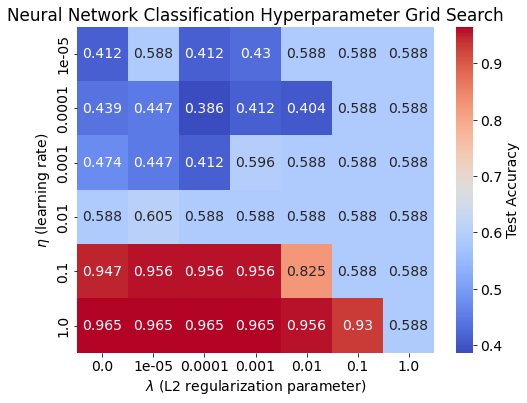

In [104]:
fig,ax = plt.subplots(figsize=(8,6))

sns.heatmap(nn_class_grid, annot=True, cmap='coolwarm', fmt='.3g', cbar_kws={'label': 'Test Accuracy'})
ax.set_xticklabels(lmbdas.round(5))
ax.set_yticklabels(etas.round(5))
ax.set_ylabel("$\\eta$ (learning rate)")
ax.set_xlabel("$\\lambda$ (L2 regularization parameter)")
ax.set_title('Neural Network Classification Hyperparameter Grid Search')
fig.savefig('classification_nn_grid.jpg', dpi=1000, bbox_inches='tight')

In [149]:
activ_funcs = ['sigmoid', 'sigmoid']
net_class = neural_network([30, 20, 2], activ_funcs, 'classification', lmbda=0.0)

data_size = len(train_data)
n_epochs = 200
eta = 1

test_acc_sigmoid = net_class.SGD(train_data, test_data, n_epochs, data_size, eta)

Epoch 0: 0.5877192982456141
Epoch 1: 0.5877192982456141
Epoch 2: 0.6052631578947368
Epoch 3: 0.631578947368421
Epoch 4: 0.6754385964912281
Epoch 5: 0.7631578947368421
Epoch 6: 0.7982456140350878
Epoch 7: 0.8333333333333334
Epoch 8: 0.8947368421052632
Epoch 9: 0.9210526315789473
Epoch 10: 0.956140350877193
Epoch 11: 0.956140350877193
Epoch 12: 0.956140350877193
Epoch 13: 0.956140350877193
Epoch 14: 0.9473684210526315
Epoch 15: 0.9473684210526315
Epoch 16: 0.9473684210526315
Epoch 17: 0.9473684210526315
Epoch 18: 0.9473684210526315
Epoch 19: 0.9473684210526315
Epoch 20: 0.9473684210526315
Epoch 21: 0.9473684210526315
Epoch 22: 0.9473684210526315
Epoch 23: 0.9473684210526315
Epoch 24: 0.9473684210526315
Epoch 25: 0.956140350877193
Epoch 26: 0.956140350877193
Epoch 27: 0.9649122807017544
Epoch 28: 0.956140350877193
Epoch 29: 0.9649122807017544
Epoch 30: 0.9649122807017544
Epoch 31: 0.9649122807017544
Epoch 32: 0.9649122807017544
Epoch 33: 0.9649122807017544
Epoch 34: 0.9649122807017544
Epo

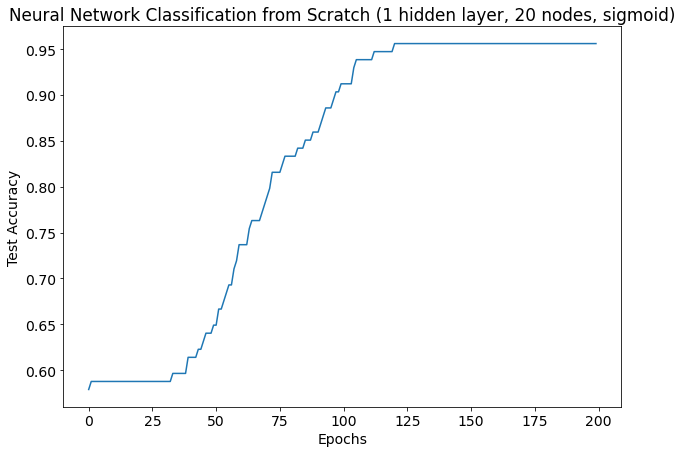

In [105]:
plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(figsize=(10,7))

ax.plot(test_acc_sigmoid)
ax.set_ylabel('Test Accuracy')
ax.set_xlabel('Epochs')
ax.set_title('Neural Network Classification from Scratch (1 hidden layer, 20 nodes, sigmoid)')
fig.savefig('classification_nn_scratch.jpg', dpi=1000, bbox_inches='tight')

### Tensorflow

In [102]:
set_seed(1)
model = Sequential([
    Dense(units = 20, activation = 'sigmoid', input_dim=30),
    Dense(units = 2, activation = 'sigmoid')
])

model.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics=['accuracy'])

train_history = model.fit(X_train_scaled,y_train, batch_size = 10, epochs = 200, validation_data=(X_test_scaled, y_test))

Epoch 1/200
46/46 [==============================] - 1s 4ms/step - loss: 0.2257 - accuracy: 0.6440 - val_loss: 0.2012 - val_accuracy: 0.6316
Epoch 2/200
46/46 [==============================] - 0s 2ms/step - loss: 0.1718 - accuracy: 0.8044 - val_loss: 0.1587 - val_accuracy: 0.8158
Epoch 3/200
46/46 [==============================] - 0s 2ms/step - loss: 0.1366 - accuracy: 0.8989 - val_loss: 0.1296 - val_accuracy: 0.8246
Epoch 4/200
46/46 [==============================] - 0s 2ms/step - loss: 0.1116 - accuracy: 0.8901 - val_loss: 0.1066 - val_accuracy: 0.8509
Epoch 5/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0923 - accuracy: 0.8835 - val_loss: 0.0899 - val_accuracy: 0.8509
Epoch 6/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0777 - accuracy: 0.8879 - val_loss: 0.0769 - val_accuracy: 0.8596
Epoch 7/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0659 - accuracy: 0.8901 - val_loss: 0.0663 - val_accuracy: 0.8684
Epoch 8/200
4

Epoch 59/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9648 - val_loss: 0.0230 - val_accuracy: 0.9298
Epoch 60/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9648 - val_loss: 0.0229 - val_accuracy: 0.9298
Epoch 61/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.9648 - val_loss: 0.0230 - val_accuracy: 0.9298
Epoch 62/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0127 - accuracy: 0.9670 - val_loss: 0.0229 - val_accuracy: 0.9298
Epoch 63/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0127 - accuracy: 0.9670 - val_loss: 0.0231 - val_accuracy: 0.9298
Epoch 64/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0126 - accuracy: 0.9670 - val_loss: 0.0230 - val_accuracy: 0.9298
Epoch 65/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0126 - accuracy: 0.9670 - val_loss: 0.0229 - val_accuracy: 0.9298
Epoch 

46/46 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 0.9846 - val_loss: 0.0243 - val_accuracy: 0.9561
Epoch 117/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 0.9868 - val_loss: 0.0245 - val_accuracy: 0.9561
Epoch 118/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 0.9868 - val_loss: 0.0245 - val_accuracy: 0.9561
Epoch 119/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 0.9868 - val_loss: 0.0246 - val_accuracy: 0.9561
Epoch 120/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0102 - accuracy: 0.9846 - val_loss: 0.0245 - val_accuracy: 0.9561
Epoch 121/200
46/46 [==============================] - 0s 1ms/step - loss: 0.0102 - accuracy: 0.9846 - val_loss: 0.0246 - val_accuracy: 0.9561
Epoch 122/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0102 - accuracy: 0.9868 - val_loss: 0.0247 - val_accuracy: 0.9561
Epoch 123/200

46/46 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 0.9890 - val_loss: 0.0271 - val_accuracy: 0.9561
Epoch 174/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 0.9890 - val_loss: 0.0272 - val_accuracy: 0.9561
Epoch 175/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 0.9890 - val_loss: 0.0270 - val_accuracy: 0.9561
Epoch 176/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 0.9890 - val_loss: 0.0272 - val_accuracy: 0.9561
Epoch 177/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 0.9890 - val_loss: 0.0271 - val_accuracy: 0.9561
Epoch 178/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 0.9890 - val_loss: 0.0272 - val_accuracy: 0.9561
Epoch 179/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0092 - accuracy: 0.9890 - val_loss: 0.0273 - val_accuracy: 0.9561
Epoch 180/200

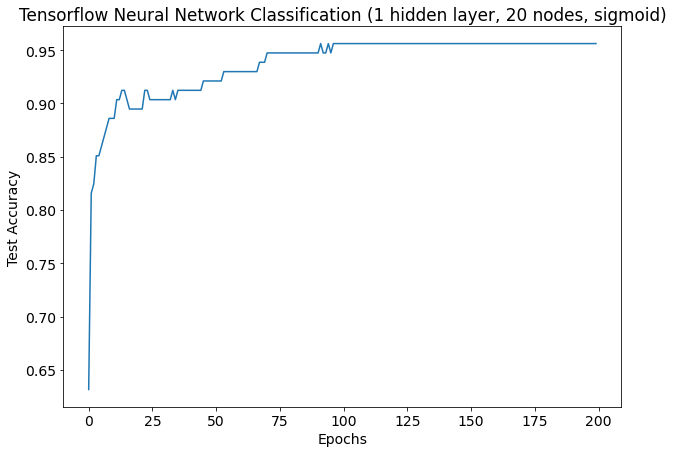

In [106]:
test_accuracy = train_history.history['val_accuracy']

plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(figsize=(10,7))

ax.plot(test_accuracy)
ax.set_ylabel('Test Accuracy')
ax.set_xlabel('Epochs')
ax.set_title('Tensorflow Neural Network Classification (1 hidden layer, 20 nodes, sigmoid)')
fig.savefig('classification_nn_tensorflow.jpg', dpi=1000, bbox_inches='tight')